### Purpose of Notebook: build model to predict whether or not a premier league match will have a score greater than 2 (or 2.5 as the bettings firms classify the cutoff point)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson,skellam
from pandas.plotting import scatter_matrix
import datetime
from functools import reduce
#from astropy.stats import boostrap
%matplotlib inline
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_info_columns', 150)
pd.set_option('display.max_info_rows', 150)
plt.style.use('seaborn')

In [2]:
# pull data and explore
df = pd.read_csv("season-1819.csv")
df2 = pd.read_csv("season-1718.csv")

# create total score field, which will need for binary label
df['total_score'] = (df.FTHG + df.FTAG)
df2['total_score'] = (df2.FTHG + df2.FTAG)

# get overview of dataframes
print('18-19 df info and head:\n')
df.info()
df.head()
df.describe()

print('\n18-19 df info and head:\n')
df2.info()
df2.head()
df2.describe()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 54.7+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2018-08-10    Man United       Leicester     2     1   H     1     0   H   
1  2018-08-11   Bournemouth         Cardiff     2     0   H     1     0   H   
2  2018-08-11        Fulham  Crystal Palace     0     2   A     0     1   A   
3  2018-08-11  Huddersfield         Chelsea     0     3   A     0     2   A   
4  2018-08-11     Newcastle       Tottenham     1     2   A     1     2   A   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3  
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2  
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2  
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3  
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  304.000000  304.000000  304.000000  304.000000  304.000000  304.000000   
mean     1.588816    1.259868    0.687500    0.588816   14.128289   10.855263   
std      1.334490    1.152513    0.873732    0.778426    5.859183    4.362922   
min      0.000000    0.000000    0.000000    0.000000    0.000000    2.000000   
25%      1.000000    0.000000    0.000000    0.000000   10.000000    8.000000   
50%      1.000000    1.000000    0.000000    0.000000   14.000000   10.000000   
75%      2.000000    2.000000    1.000000    1.000000   17.250000   14.000000   
max      6.000000    6.000000    4.000000    3.000000   36.000000   25.000000   

              HST         AST          HF          AF          HC         AC  \
count  304.000000  304.000000  304.000000  304.000000  304.000000  304.00000   
mean     4.822368    3.911184   10.486842   10.411184    5.703947    4.56250   
std      2.675156    2.216501    3.234482    3.576418    2.931200    2.75921   
min      0.000000    0.000000    2.000000    3.000000    0.000000    0.00000   
25%      3.000000    2.000000    8.000000    8.000000    4.000000    2.00000   
50%      5.000000    4.000000   10.000000   10.000000    5.000000    4.00000   
75%      6.000000    5.000000   12.000000   13.000000    8.000000    6.00000   
max     14.000000   12.000000   23.000000   21.000000   14.000000   14.00000   

               HY          AY          HR          AR  total_score  
count  304.000000  304.000000  304.000000  304.000000   304.000000  
mean     1.559211    1.726974    0.049342    0.082237     2.848684  
std      1.214508    1.213699    0.216938    0.275178     1.611673  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      1.000000    1.000000    0.000000    0.000000     2.000000  
50%      1.000000    2.000000    0.000000    0.000000     3.000000  
75%      2.000000    2.000000    0.000000    0.000000     4.000000  
max      6.000000    5.000000    1.000000    1.000000     8.000000


18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 68.4+ KB


Date        HomeTeam      AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2017-08-11         Arsenal     Leicester     4     3   H     2     2   D   
1  2017-08-12        Brighton      Man City     0     2   A     0     0   D   
2  2017-08-12         Chelsea       Burnley     2     3   A     0     3   A   
3  2017-08-12  Crystal Palace  Huddersfield     0     3   A     0     2   A   
4  2017-08-12         Everton         Stoke     1     0   H     1     0   H   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7  
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2  
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5  
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3  
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     1.531579    1.147368    0.607895    0.515789   13.584211   10.855263   
std      1.340087    1.177793    0.793403    0.756511    5.771439    4.858700   
min      0.000000    0.000000    0.000000    0.000000    2.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    9.000000    7.000000   
50%      1.000000    1.000000    0.000000    0.000000   13.000000   10.500000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   14.000000   
max      7.000000    6.000000    4.000000    3.000000   35.000000   30.000000   

              HST         AST          HF          AF          HC          AC  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     4.626316    3.763158   10.218421   10.478947    5.739474    4.544737   
std      2.706845    2.317015    3.256360    3.336388    2.993047    2.767241   
min      0.000000    0.000000    2.000000    3.000000    0.000000    0.000000   
25%      3.000000    2.000000    8.000000    8.000000    4.000000    2.000000   
50%      4.000000    3.500000   10.000000   10.000000    5.000000    4.000000   
75%      6.000000    5.000000   12.000000   13.000000    8.000000    6.000000   
max     15.000000   14.000000   19.000000   26.000000   18.000000   13.000000   

               HY          AY          HR          AR  total_score  
count  380.000000  380.000000  380.000000  380.000000   380.000000  
mean     1.478947    1.565789    0.044737    0.057895     2.678947  
std      1.256993    1.259639    0.219375    0.233852     1.665125  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      1.000000    1.000000    0.000000    0.000000     1.000000  
50%      1.000000    1.000000    0.000000    0.000000     3.000000  
75%      2.000000    2.000000    0.000000    0.000000     4.000000  
max      6.000000    7.000000    2.000000    1.000000     9.000000

### ^^ Great, we don't have to worry about missing data.

# first look at goal distribution

In [3]:
# creating hist plotting function, 
# overlay with poisson pmf, common distribution for sports goals
def hagoal_plot(df=df, title='#Goals/Match', 
                bin_field=['FTHG','FTAG'], 
                hist_label=['Home', 'Away'], 
                set_alpha=0.5,
                goal_max=10):
    """function to create the home/away goal histogram with poisson pmf overlay"""
    
    pos_pred = np.column_stack([[poisson.pmf(i, df[bin_field].mean()[j]) for i in range(goal_max)] 
                                    for j in range(len(bin_field))])

    # poisson pmf lines
    if len(bin_field) == 2:
        plt.hist(df[bin_field].values, range(10), 
                  alpha=set_alpha, label=hist_label,
                  density=True, color=['r', 'b'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'r')
        _pois2, = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'b')
    else:
        plt.hist(df[bin_field].values, range(10), 
                 alpha=set_alpha, label=hist_label,density=True, color=['r'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Total Score", color = 'r')

    plt.xticks([i-0.5 for i in range(1,goal_max+1)],[i for i in range(10)])
    leg=plt.legend(loc='upper right', fontsize=15, ncol=2)
    leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
    plt.xlabel("#Goals/Match",size=13)
    plt.ylabel("% of Matches",size=13)
    plt.title(title, size=14, fontweight='bold')
    plt.ylim([-0.004, 0.4])
    plt.tight_layout()
    plt.show() 

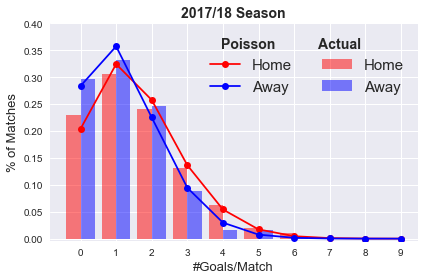

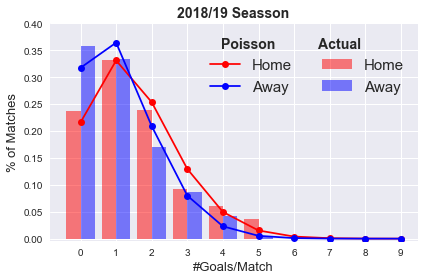

In [4]:
# run goal plotting function on 2017/18 and 2017/18 seasons and combined
hagoal_plot(df=df, title='2017/18 Season')
hagoal_plot(df=df2, title='2018/19 Seasson')

### ^^^ Looks like home/away goals hist follow quite closely to their relative poisson pmfs

In [5]:
# create total score field, which will be label/y value of model
df_total = pd.concat([df, df2], ignore_index=True)
print('18-19 df info and head:\n')
df_total.info()
df_total.head()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 123.0+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2018-08-10    Man United       Leicester     2     1   H     1     0   H   
1  2018-08-11   Bournemouth         Cardiff     2     0   H     1     0   H   
2  2018-08-11        Fulham  Crystal Palace     0     2   A     0     1   A   
3  2018-08-11  Huddersfield         Chelsea     0     3   A     0     2   A   
4  2018-08-11     Newcastle       Tottenham     1     2   A     1     2   A   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3  
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2  
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2  
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3  
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3

In [6]:
# now lets look at the mean of the home/away goals
df[['FTHG','FTAG']].mean()
df2[['FTHG','FTAG']].mean()
df_total[['FTHG','FTAG']].mean()

# now look at variance
np.var(df[['FTHG','FTAG']])
np.var(df2[['FTHG','FTAG']])
np.var(df_total[['FTHG','FTAG']])

# for reference in poisson distribution the
# expected value = variance

FTHG    1.588816
FTAG    1.259868
dtype: float64

FTHG    1.531579
FTAG    1.147368
dtype: float64

FTHG    1.557018
FTAG    1.197368
dtype: float64

FTHG    1.775006
FTAG    1.323916
dtype: float64

FTHG    1.791108
FTAG    1.383546
dtype: float64

FTHG    1.784761
FTAG    1.360169
dtype: float64

#### ^^ the variance looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

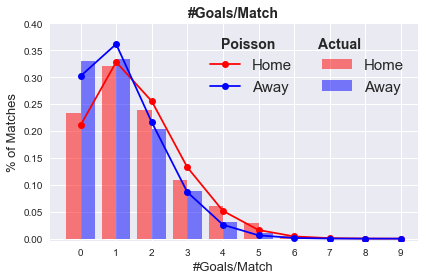

In [7]:
hagoal_plot(df=df_total)

### ^^^ both seasons combined also follows closely to the poisson

## Now lets do the same plotting exercise but for total goals 

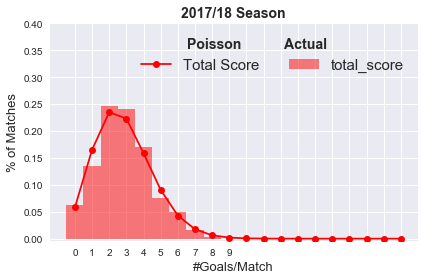

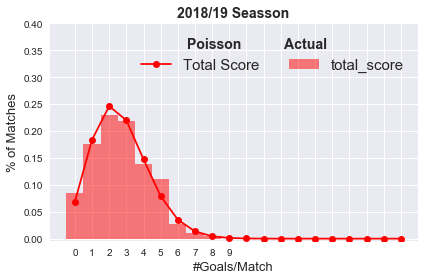

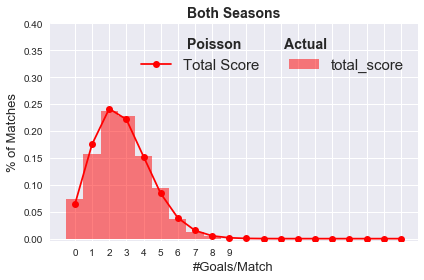

In [8]:
hagoal_plot(df=df, title='2017/18 Season', 
            bin_field=['total_score'], 
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df2, title='2018/19 Seasson',
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df_total, title='Both Seasons', 
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)

In [9]:
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

2.848684210526316

2.6789473684210527

2.754385964912281

In [10]:
# now lets look at the mean of the home/away goals
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

# now look at variance
np.var(df['total_score'])
np.var(df2['total_score'])
np.var(df_total['total_score'])

# for reference in poisson distribution the
# expected value = variance

2.848684210526316

2.6789473684210527

2.754385964912281

2.5889456371191137

2.7653462603878114

2.694059710680209

#### ^^ the variance for total score also looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

### now lets set up our binary y variable for classification/binary regression prep

### we are going to use the combined data of 2017 through the current 2018/19 season and use days/months from match date to current date as a field in our future classifier

In [11]:
# lets create some more variables; mostly totals of the home and away features 
df_total['y'] = df_total['total_score'].apply(lambda x: 1 if x > 2.5 else 0)
df_total['total_half_score'] = df_total.HTHG + df_total.HTAG
df_total['TS'] = df_total.HS + df_total.AS # TS = total shots
df_total['TST'] = df_total.HST + df_total.AST # TST = total shots on target
df_total['corners'] = df_total.HC + df_total.AC
df_total['yellows'] = df_total.HY + df_total.AY
df_total['reds'] = df_total.HR + df_total.AR
df_total['fouls'] = df_total.HF + df_total.AF

# remove FTR and HTR since we can get result info from scores
df_total = df_total.drop(columns=['FTR', 'HTR'])

df_total.info()
df_total.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 29 columns):
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 155.0+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  2018-08-10    Man United       Leicester     2     1     1     0   
1  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  2018-08-11     Newcastle       Tottenham     1     2     1     2   
5  2018-08-11       Watford        Brighton     2     0     1     0   
6  2018-08-11        Wolves         Everton     2     2     1     1   
7  2018-08-12       Arsenal        Man City     0     2     0     1   
8  2018-08-12     Liverpool        West Ham     4     0     2     0   
9  2018-08-12   Southampton         Burnley     0     0     0     0   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   
5      J Moss  19   6    5    0  10  16   8   2   2   2   0   0            2   
6    C Pawson  11   6    4    5   8   7   3   6   0   1   0   1            4   
7    M Oliver   9  17    3    8  11  14   2   9   2   2   0   0            2   
8    A Taylor  18   5    8    2  14   9   5   4   1   2   0   0            4   
9     G Scott  18  16    3    6  10   9   8   5   0   1   0   0            0   

   y  total_half_score  TS  TST  corners  yellows  reds  fouls  
0  1                 1  21   10        7        3     0     19  
1  0                 1  22    5       11        2     0     20  
2  0                 1  25   15       10        3     0     20  
3  1                 2  19    5        7        3     0     17  
4  1                 3  30    7        8        4     0     23  
5  0                 1  25    5       10        4     0     26  
6  1                 2  17    9        9        1     1     15  
7  0                 1  26   11       11        4     0     25  
8  1                 2  23   10        9        3     0     23  
9  0                 0  34    9       13        1     0     19

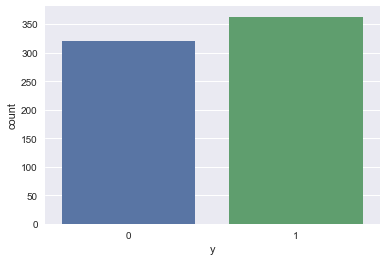

In [12]:
sns.countplot(x='y', data=df_total)
plt.show()

<Figure size 1800x720 with 0 Axes>

total score swarmplot by HomeTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by AwayTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by Referee


<Figure size 1800x720 with 0 Axes>

total score swarmplot by total_half_score


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TS


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TST


<Figure size 1800x720 with 0 Axes>

total score swarmplot by corners


<Figure size 1800x720 with 0 Axes>

total score swarmplot by yellows


<Figure size 1800x720 with 0 Axes>

total score swarmplot by reds


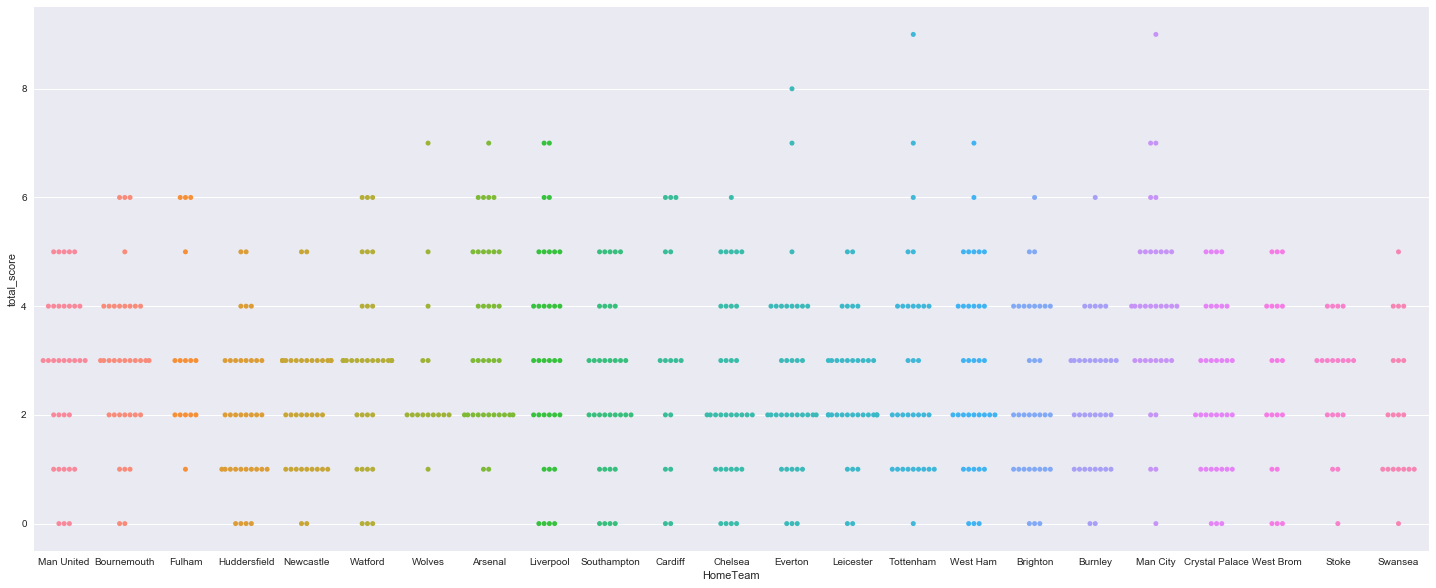

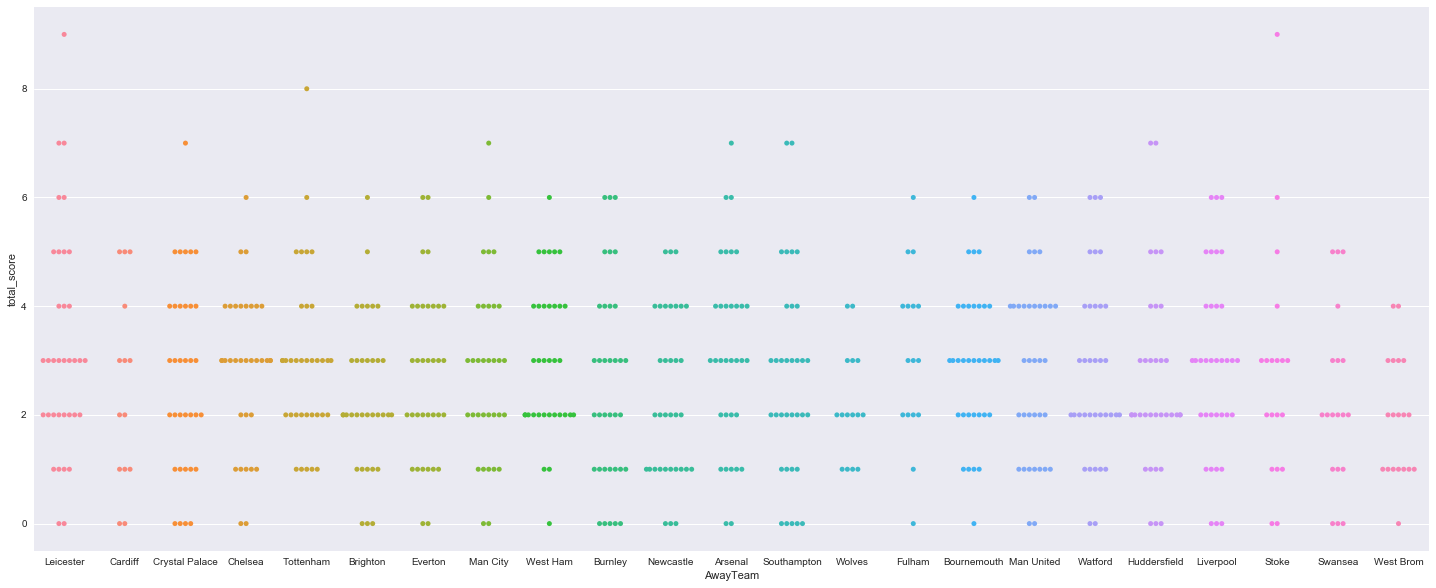

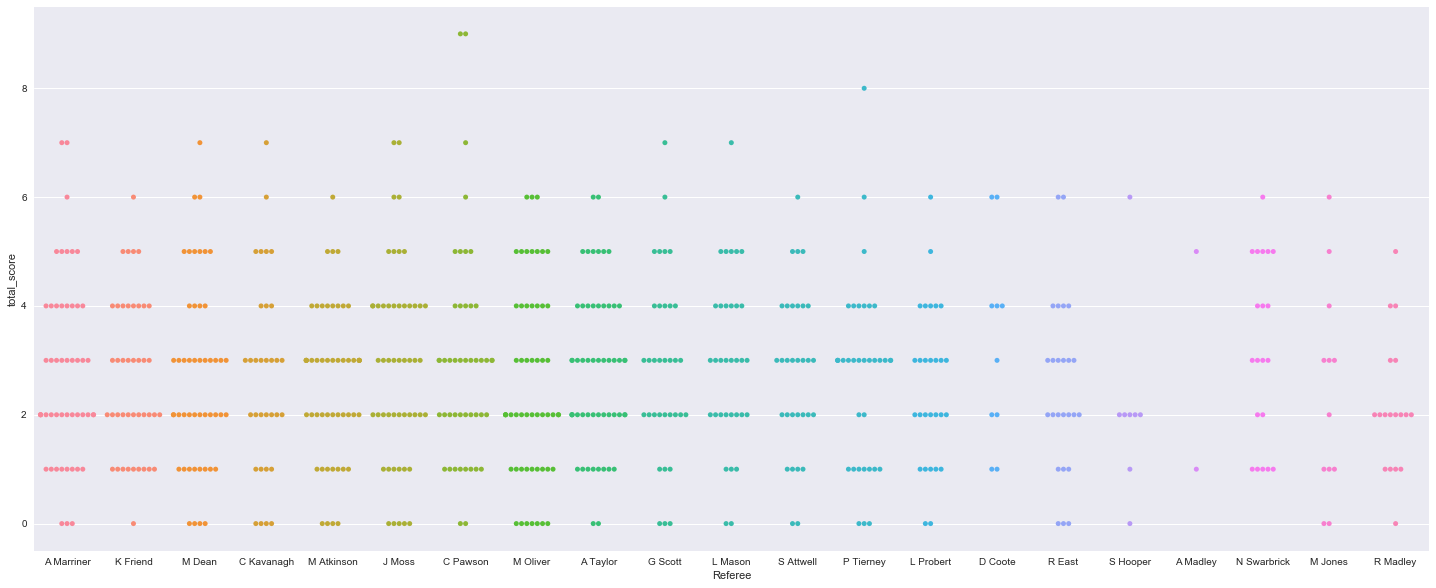

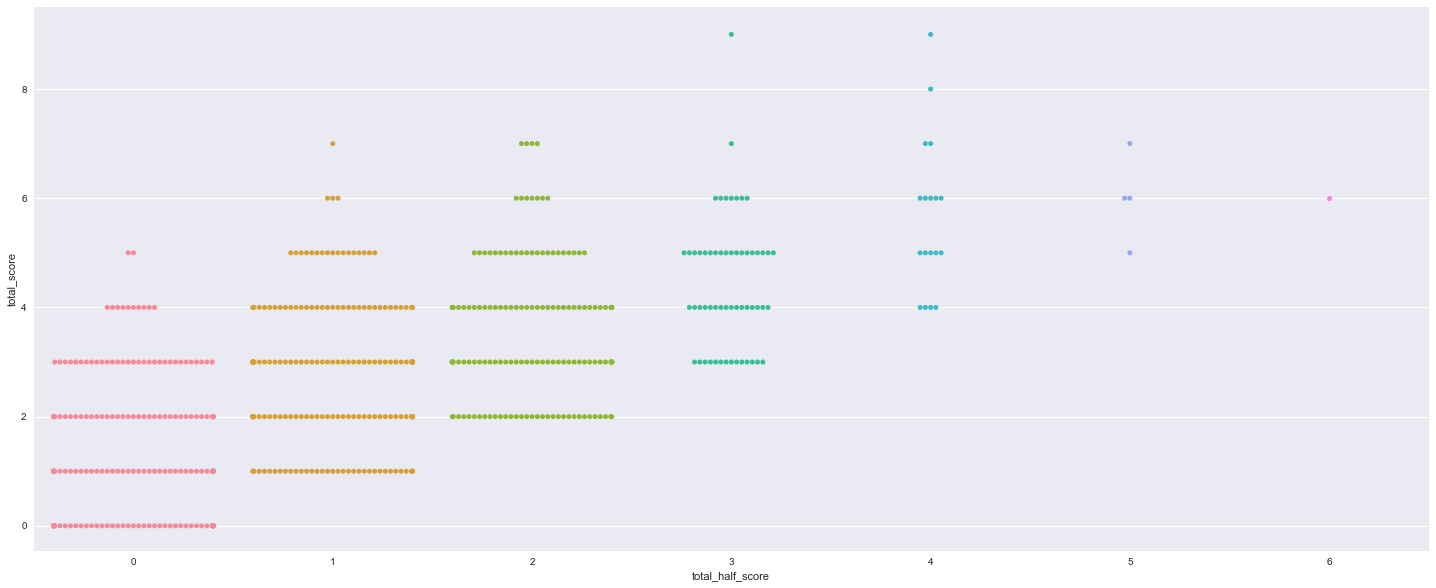

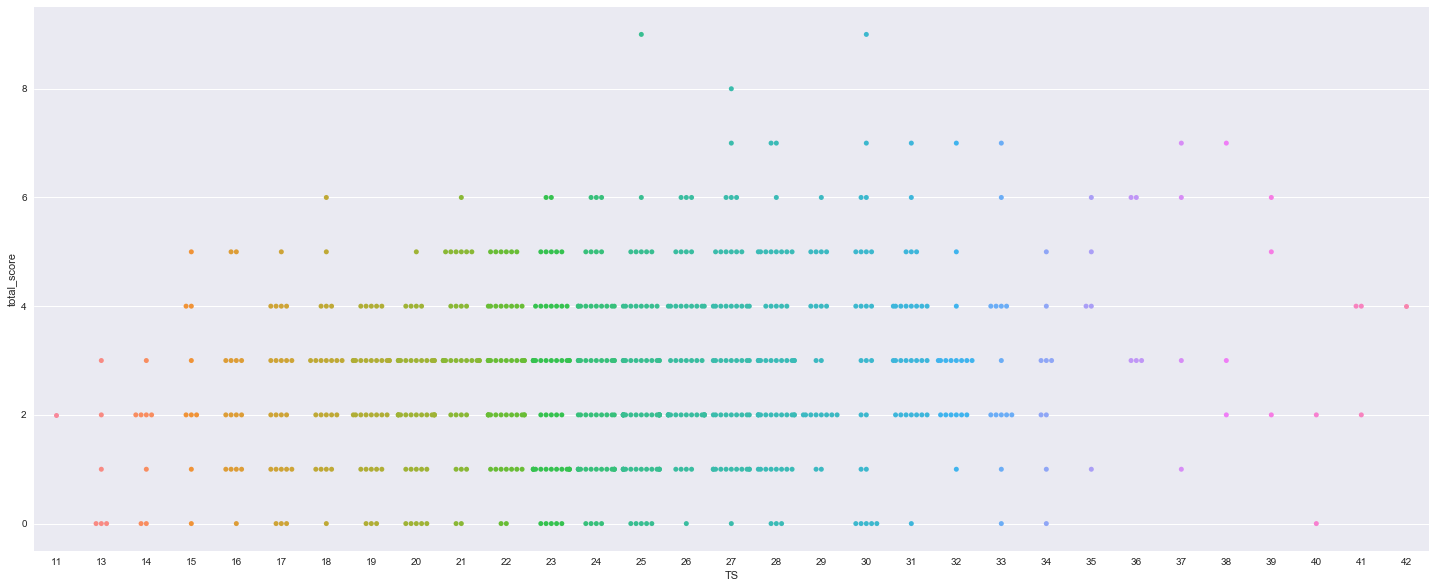

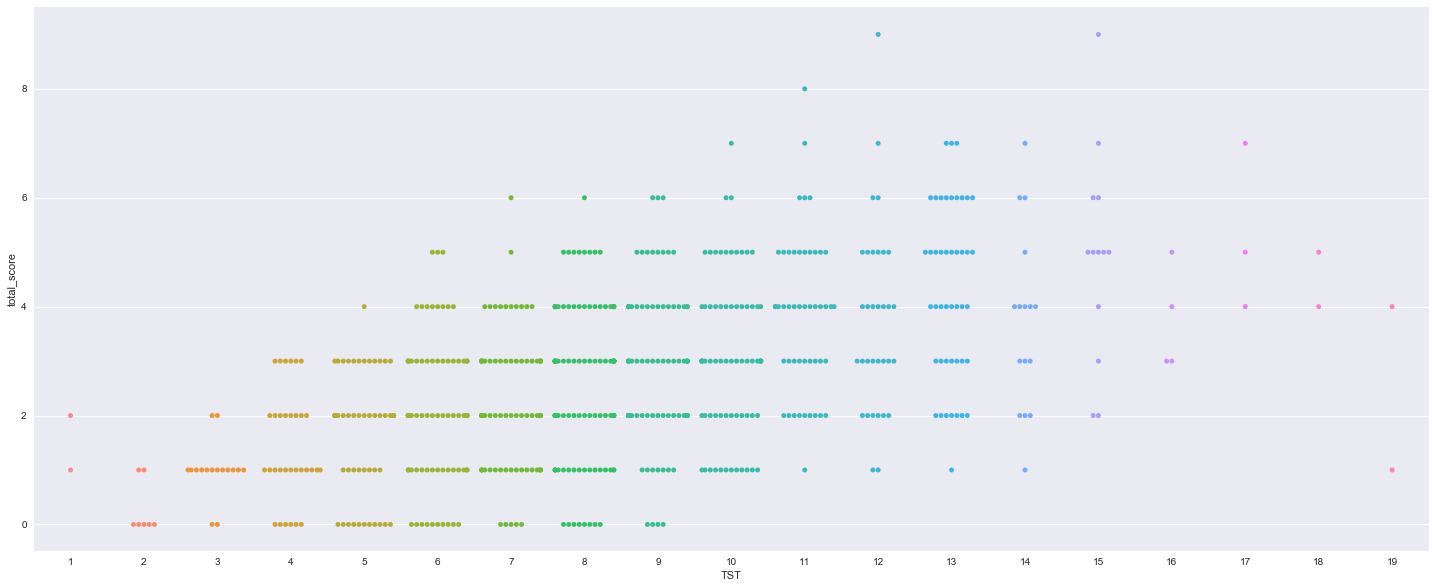

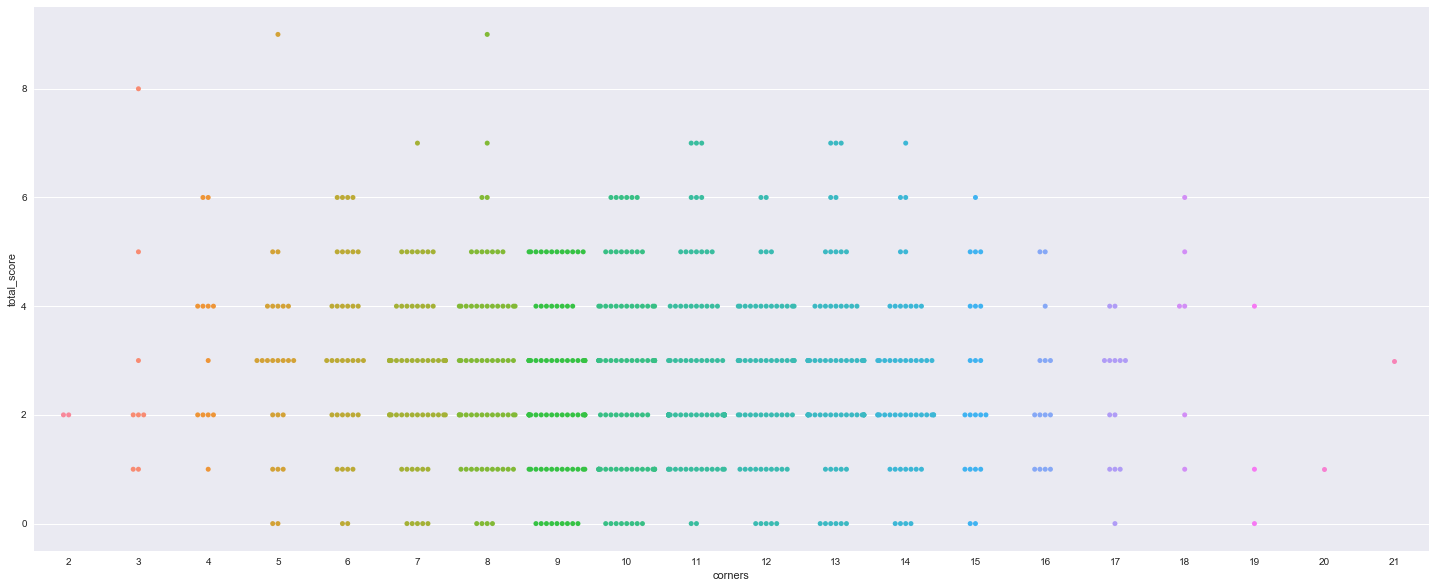

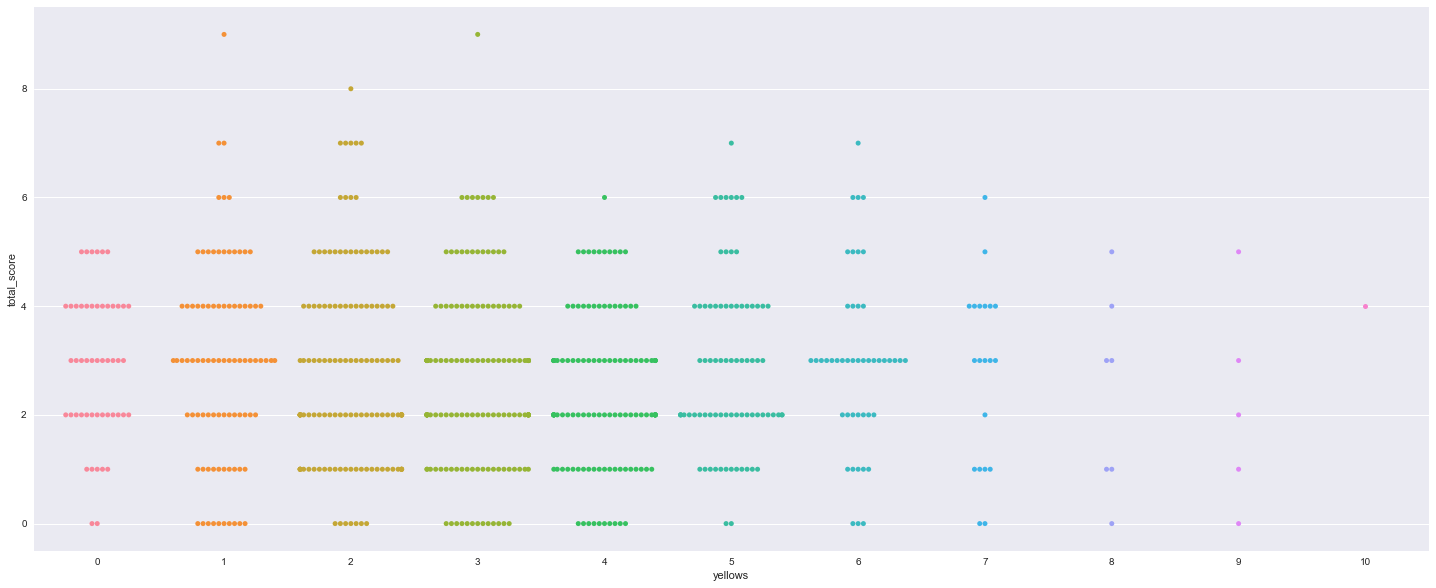

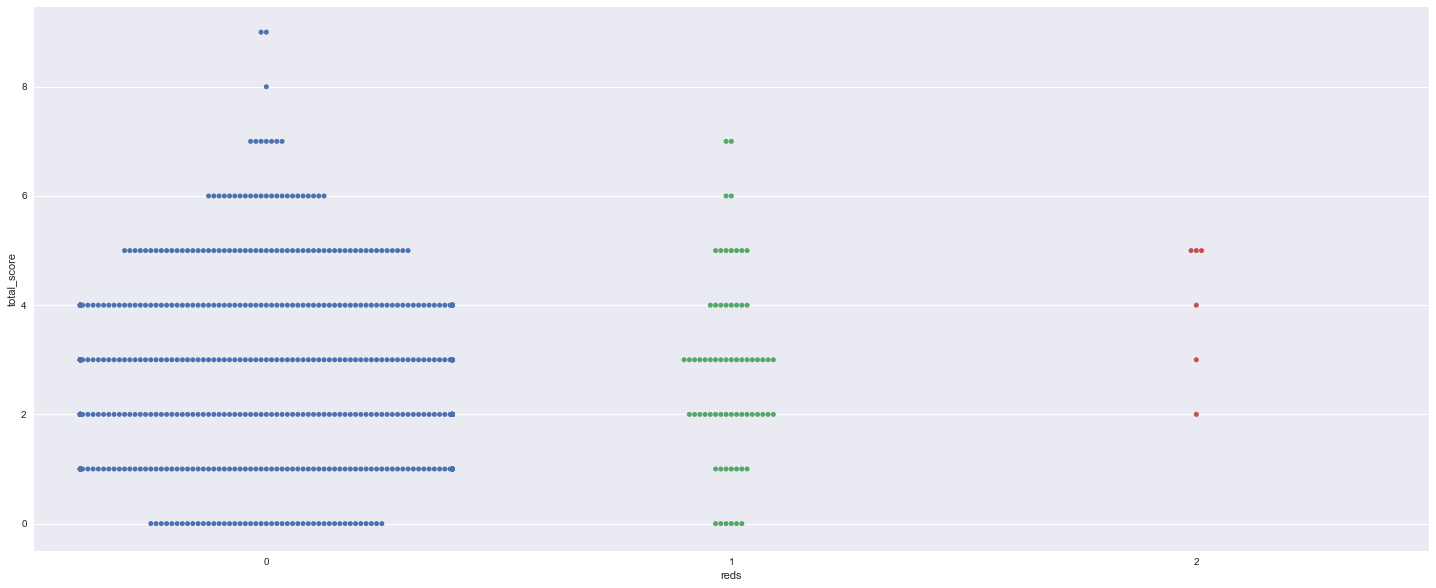

In [13]:
# now lets look at total score swarm plots by various features
swarm_list = ['HomeTeam', 'AwayTeam', 'Referee','total_half_score', 
              'TS', 'TST', 'corners', 'yellows', 'reds']

for x in swarm_list:
    plt.figure(figsize=(25,10))
    print('total score swarmplot by ' + x)
    sns.swarmplot(df_total[x], df_total.total_score)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

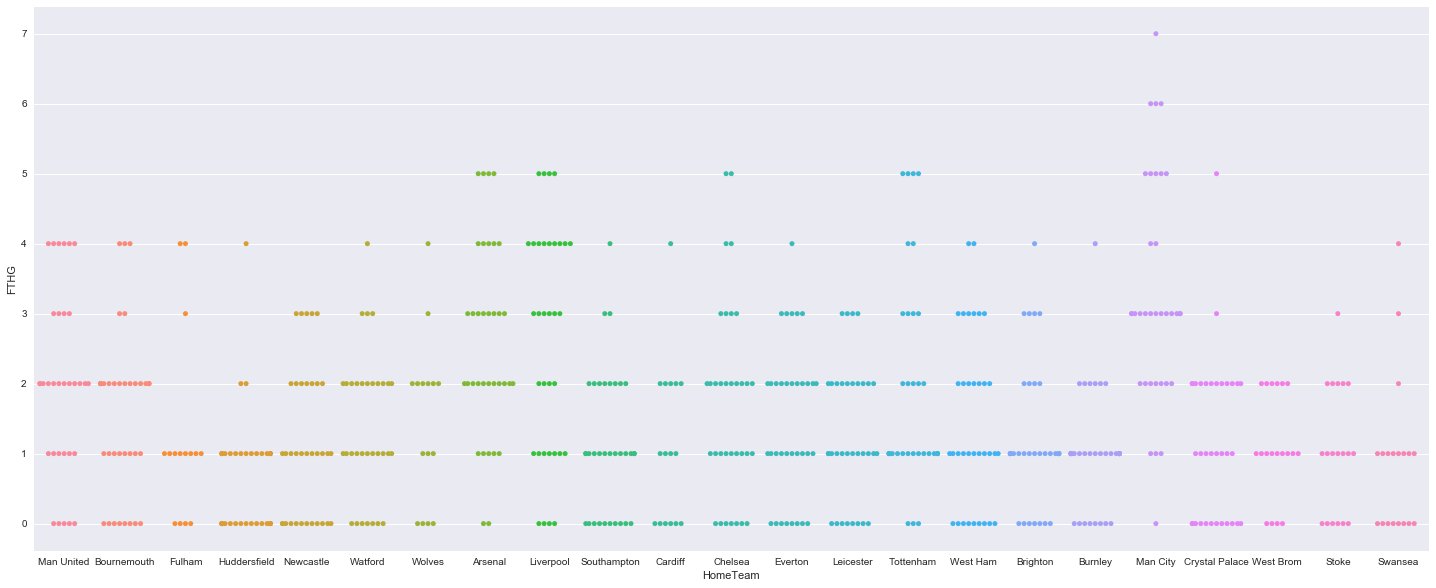

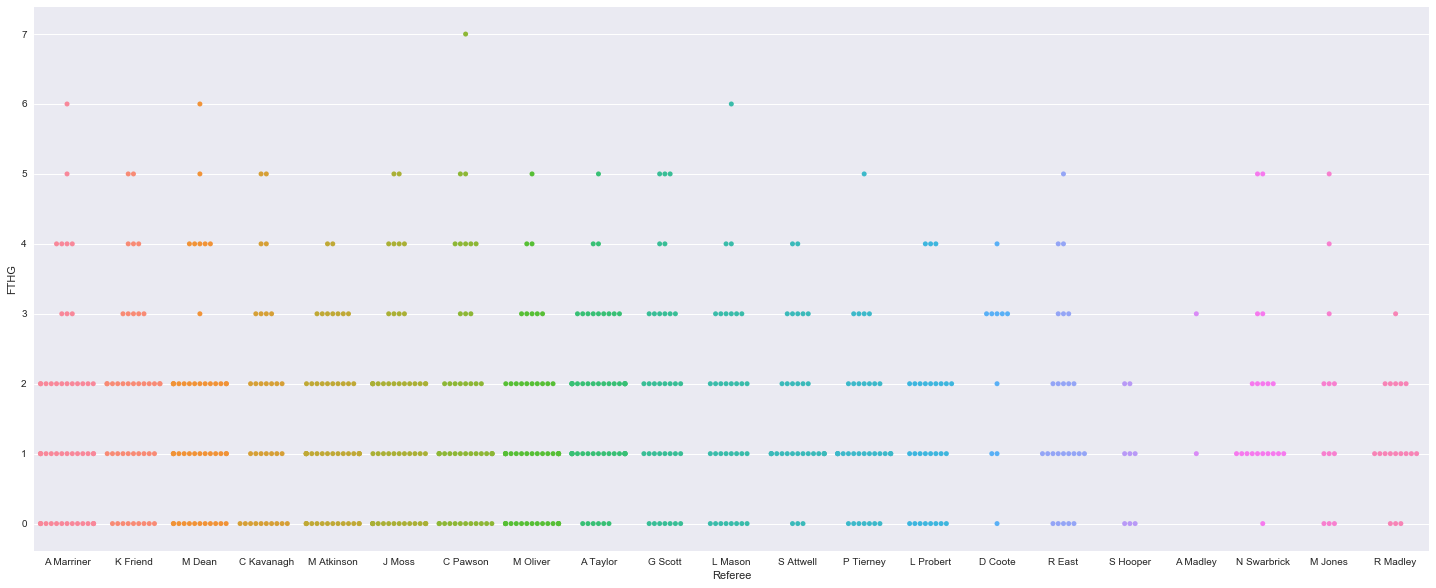

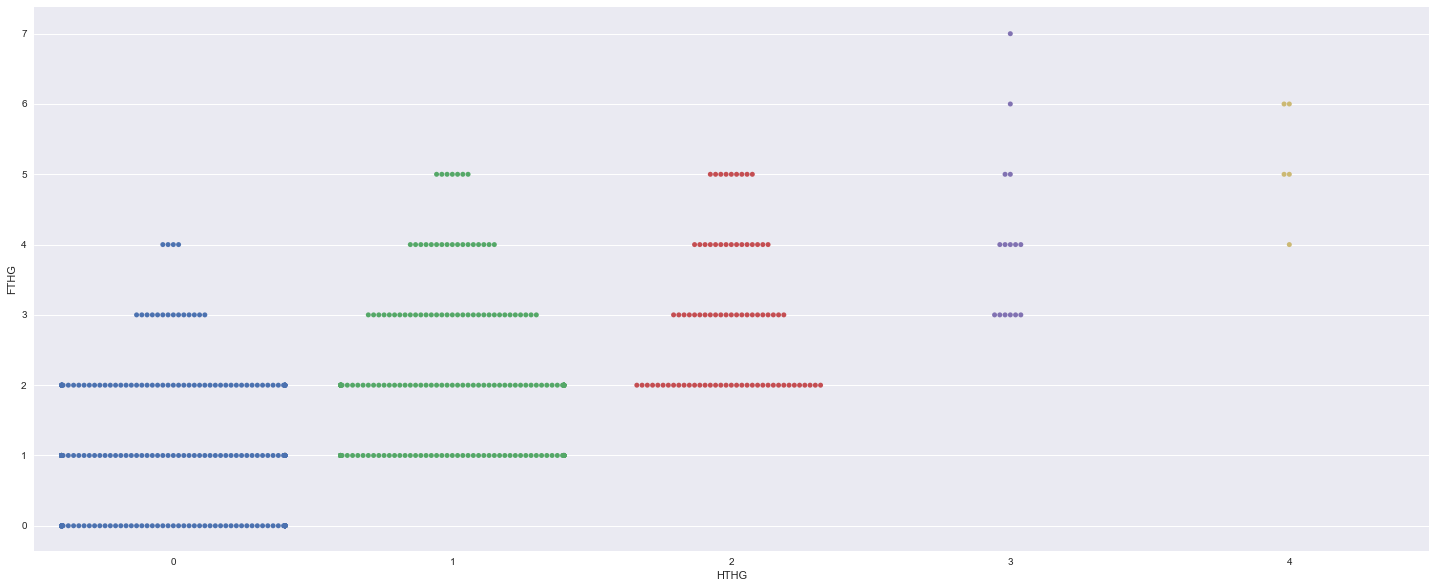

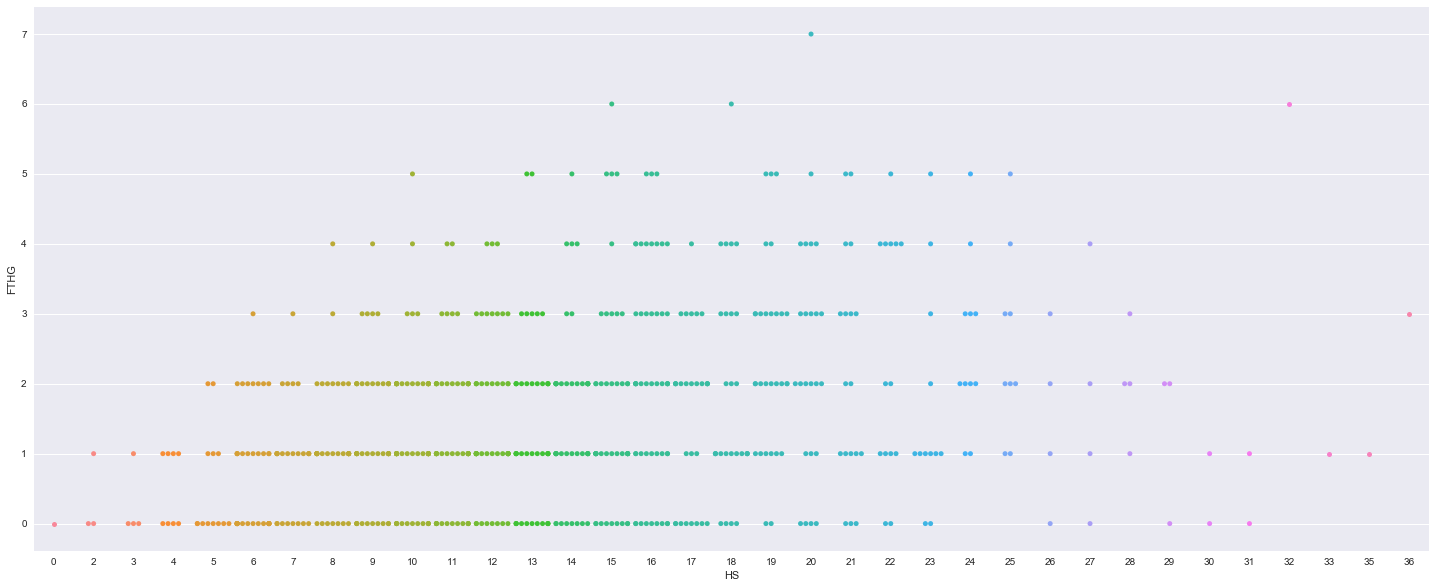

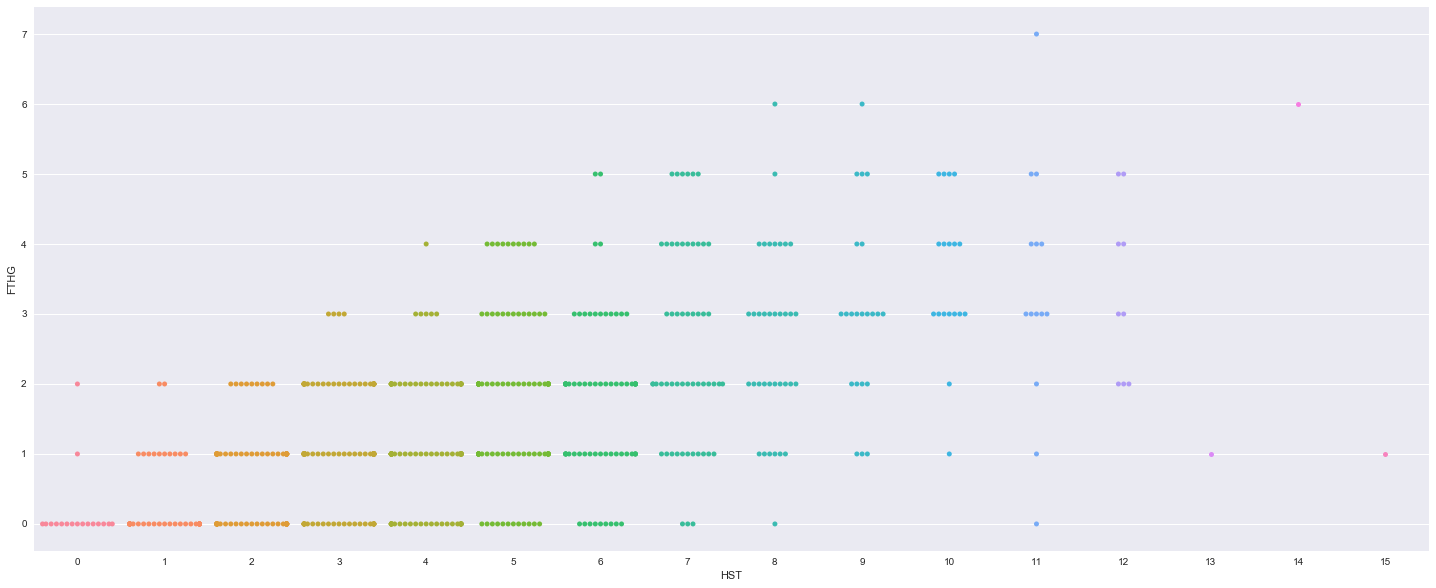

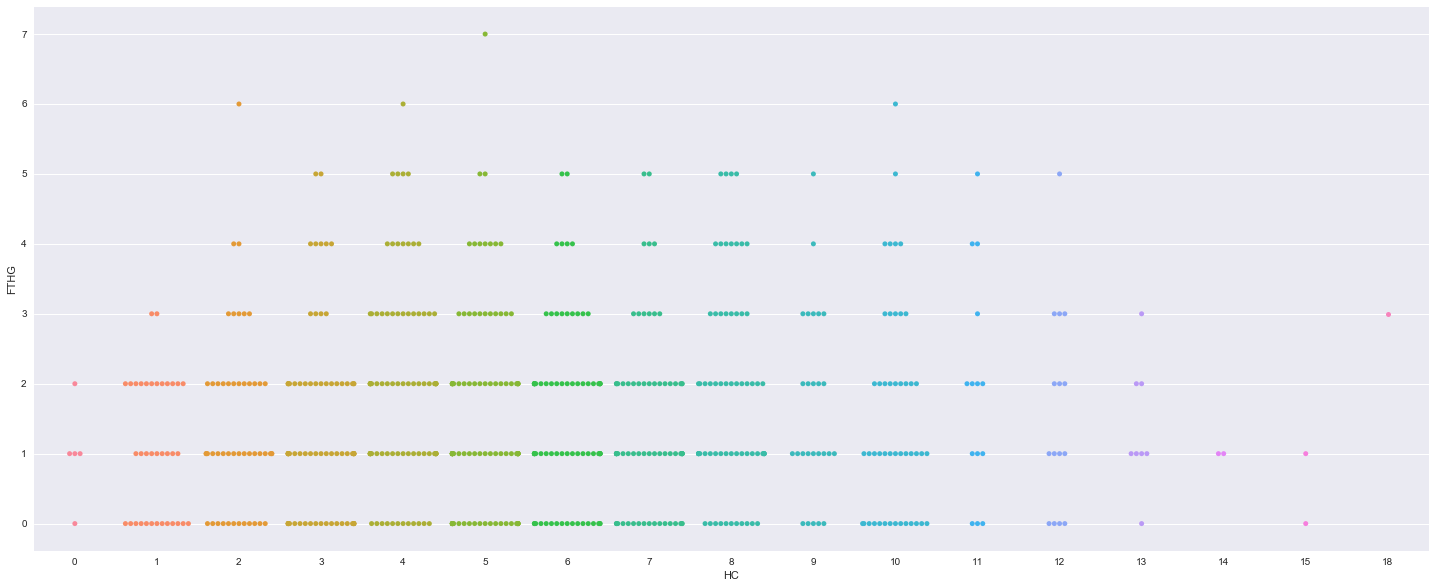

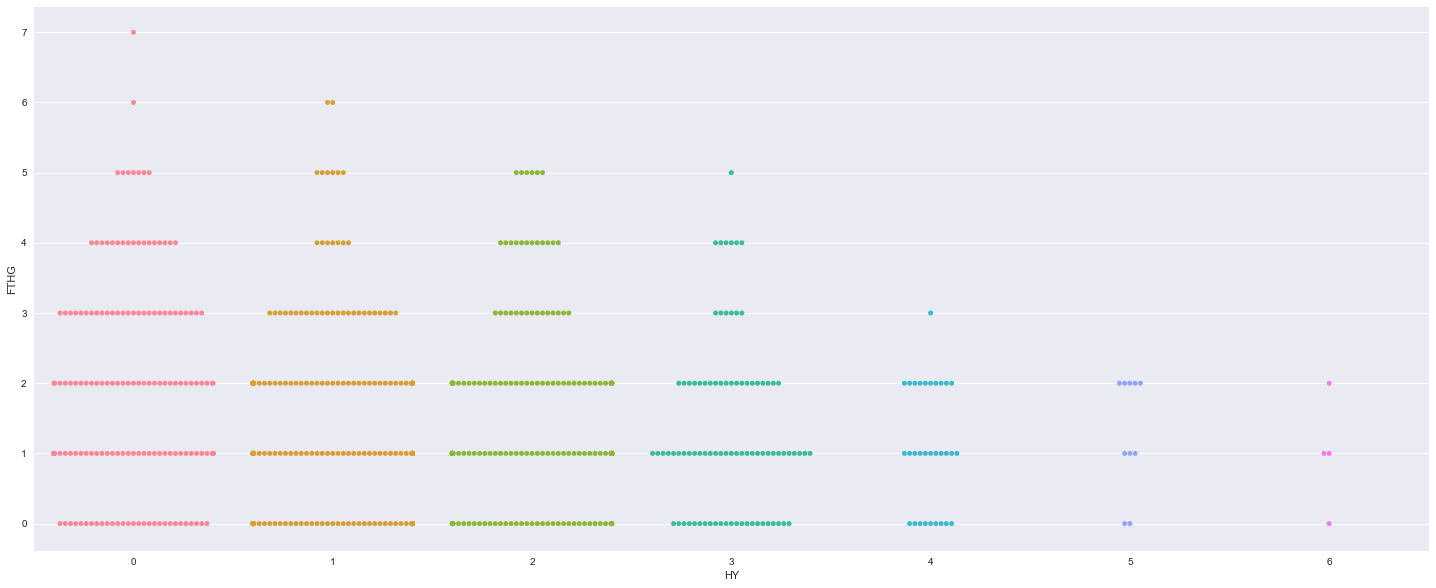

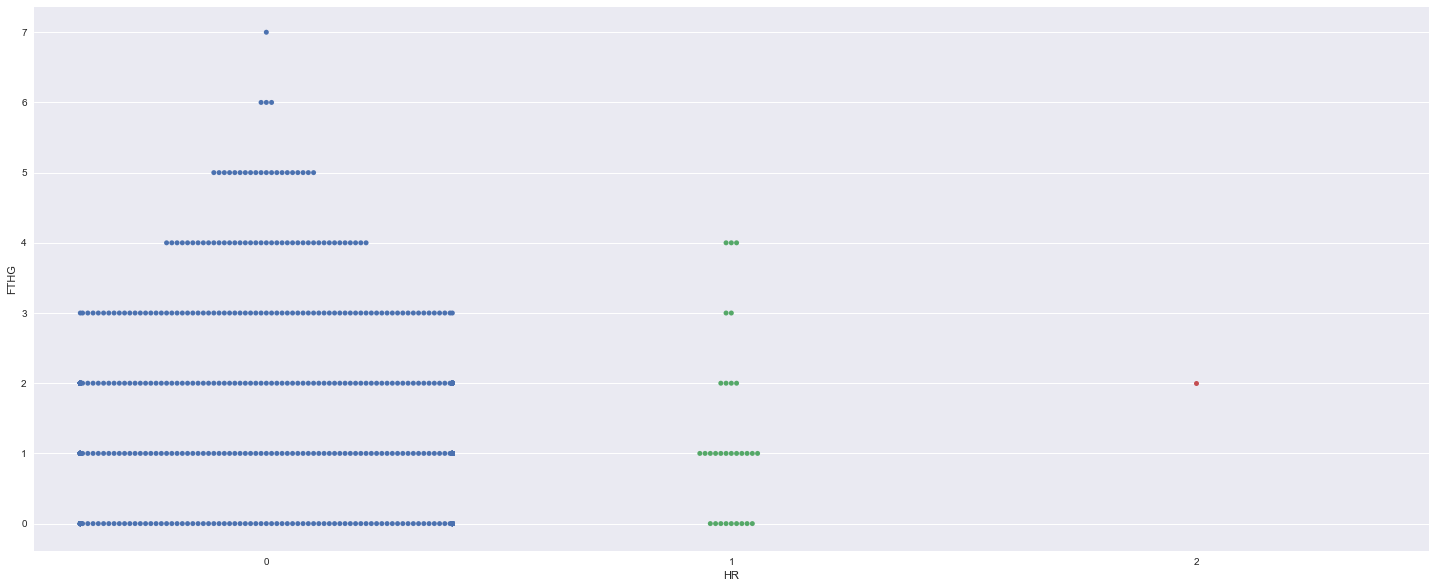

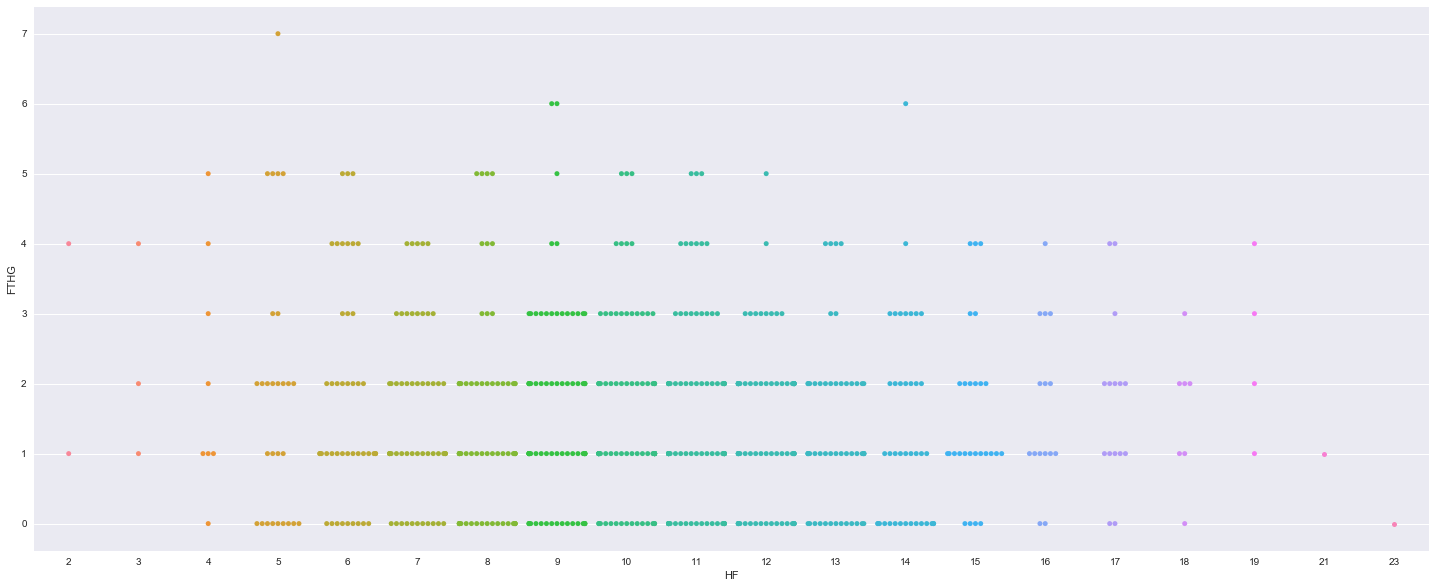

In [14]:
# now lets look at home score swarm plots by home features
total_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in total_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTHG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

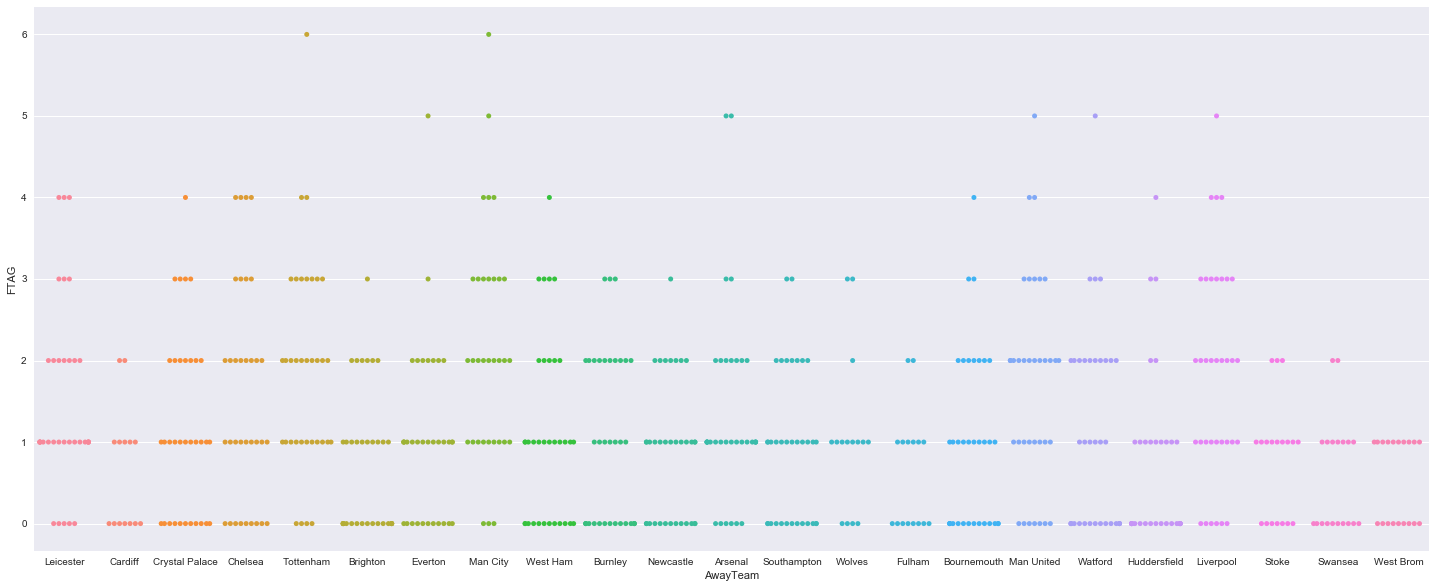

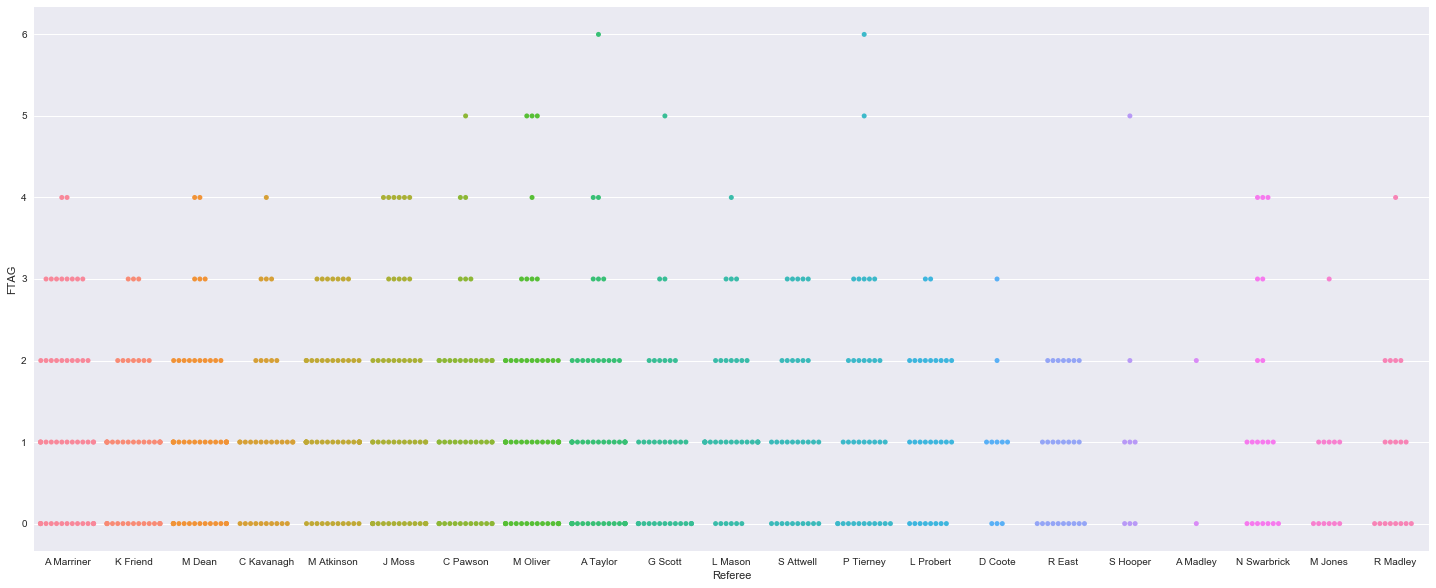

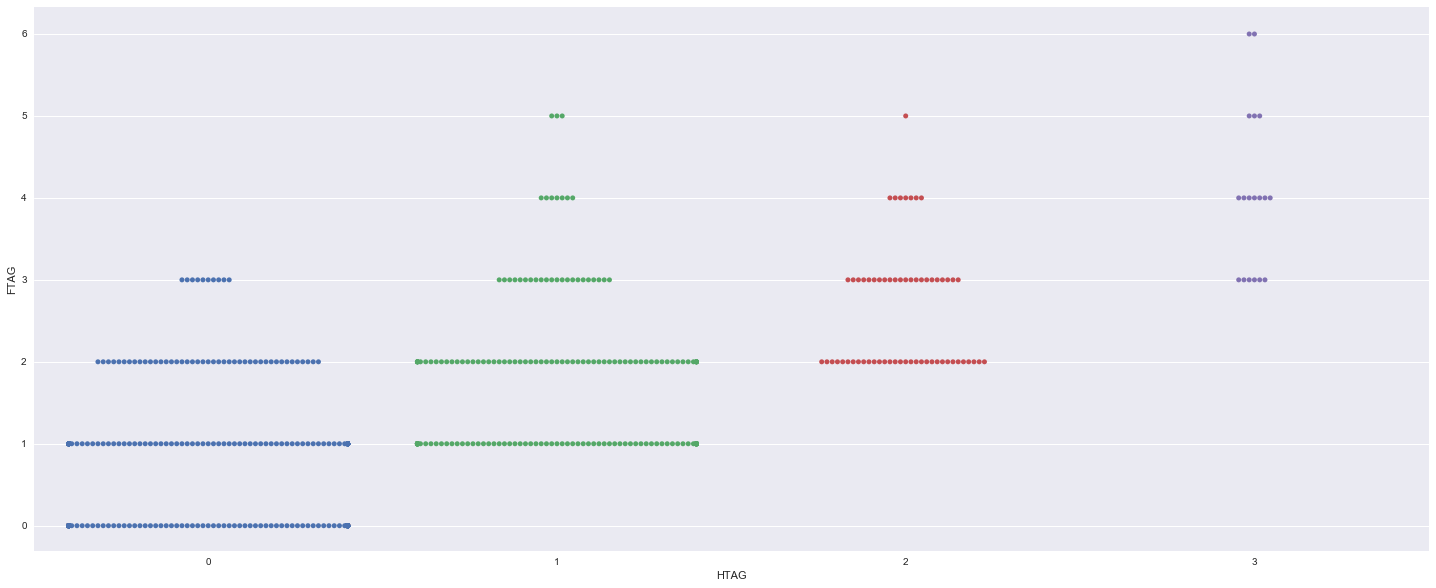

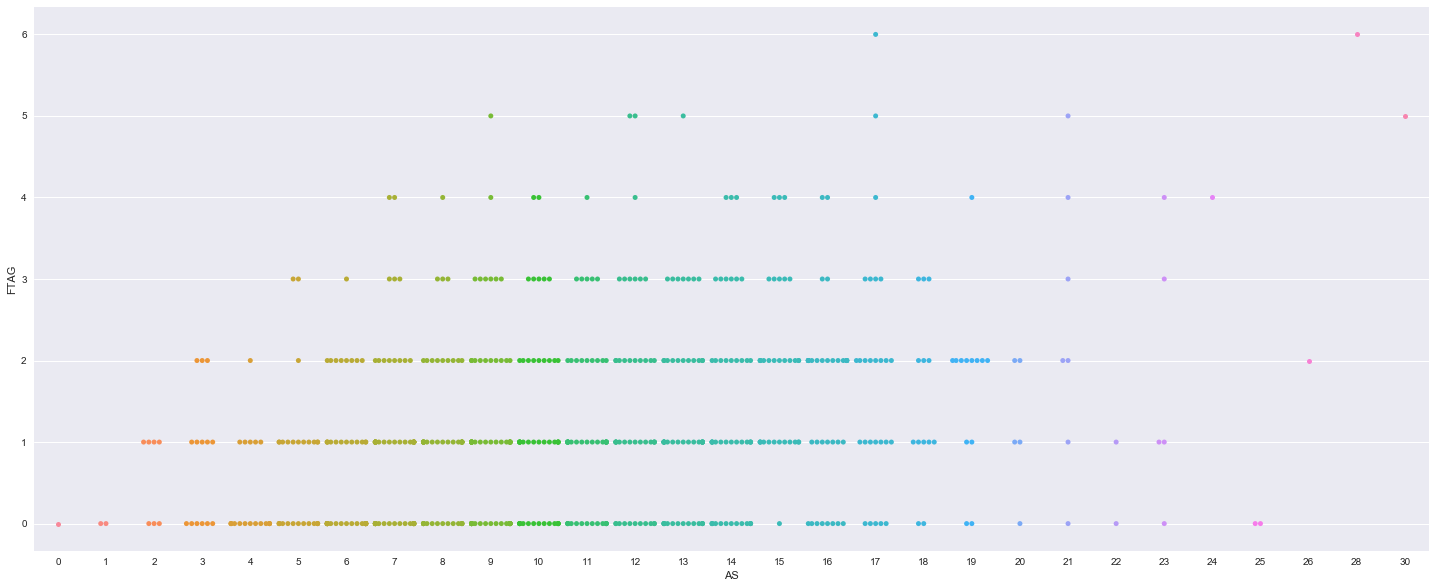

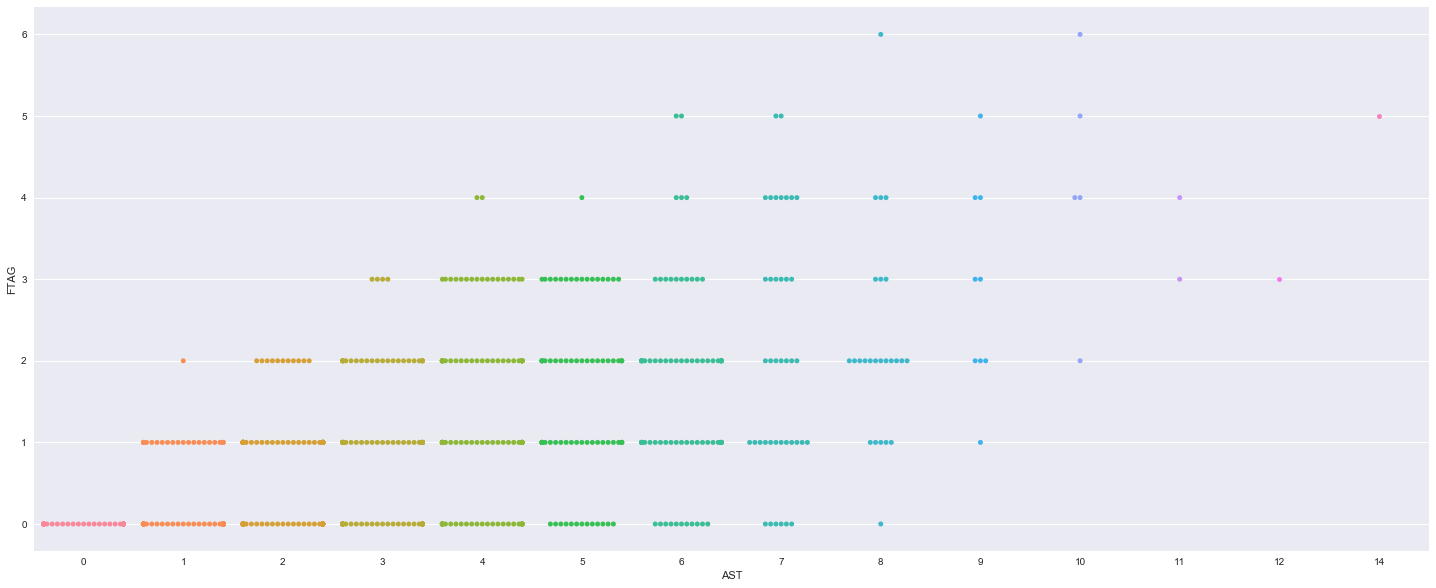

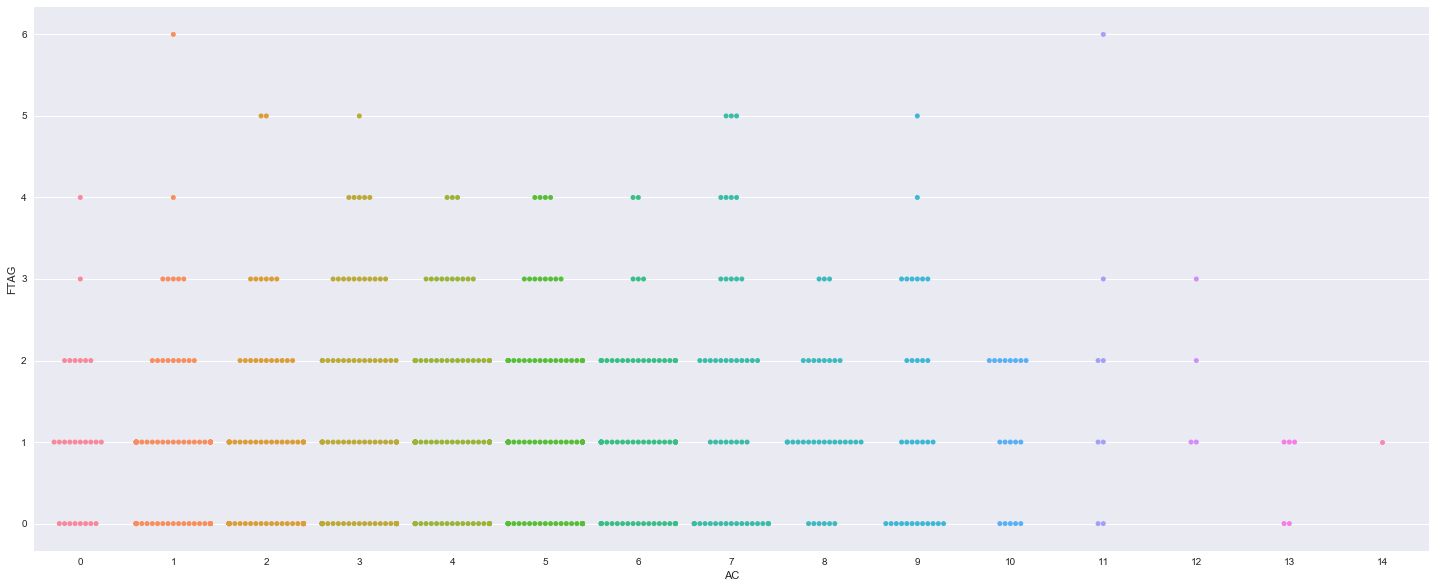

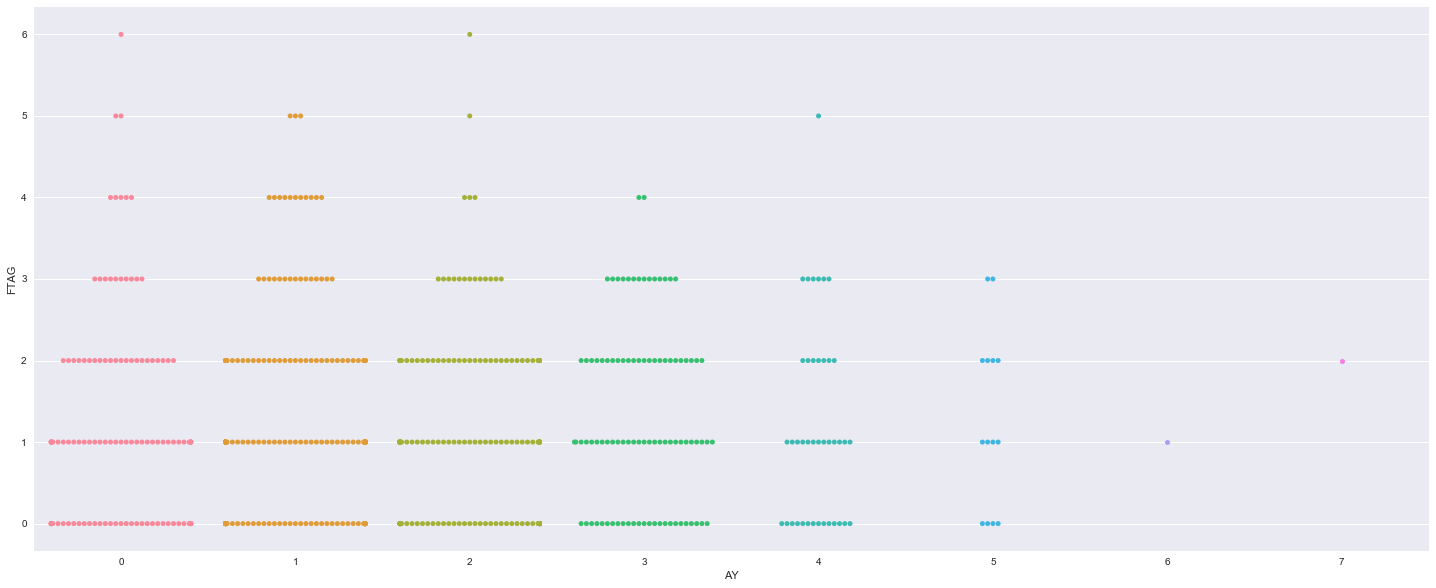

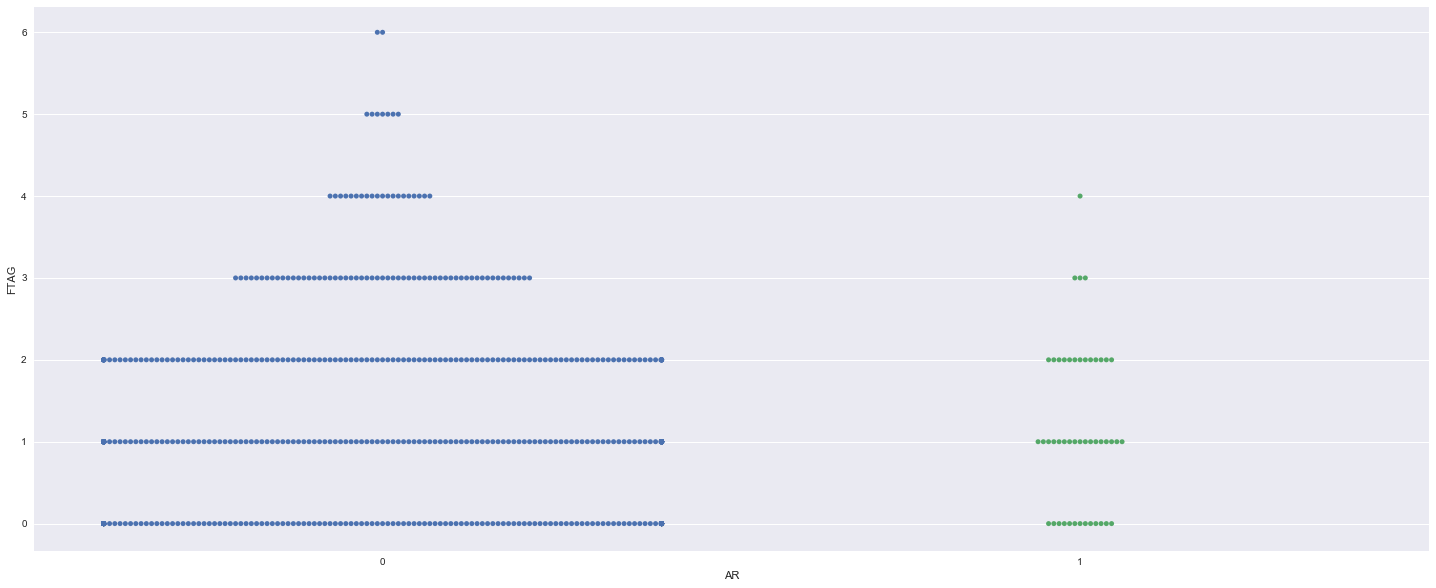

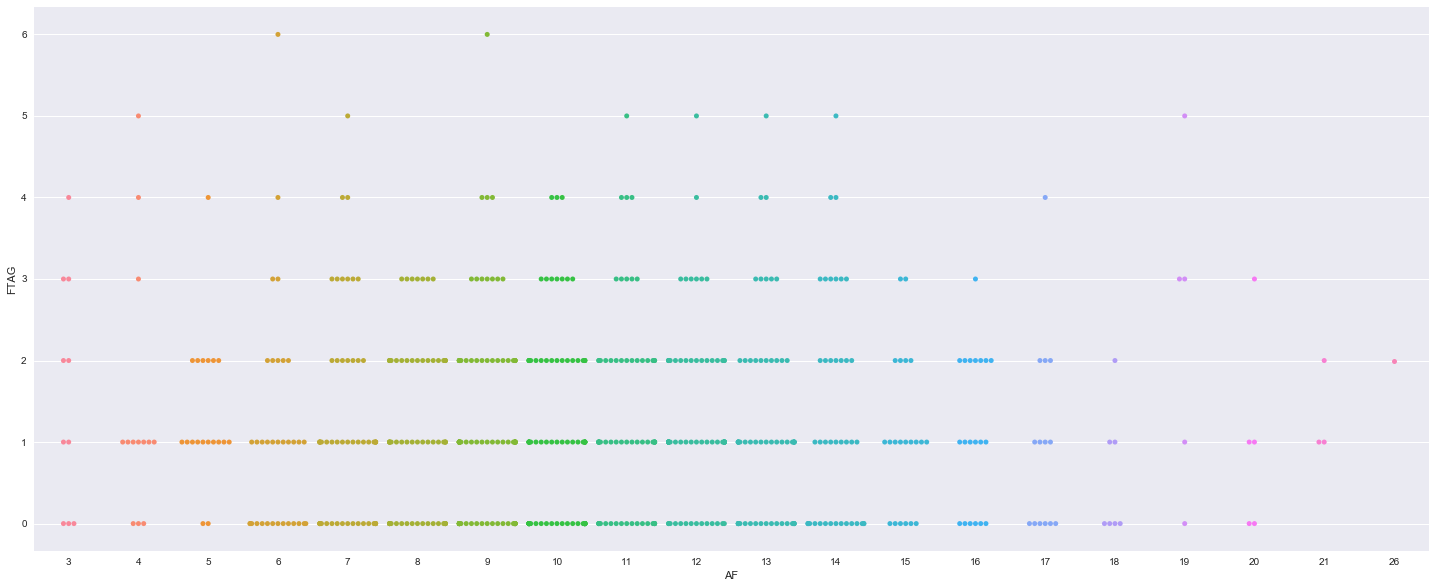

In [15]:
# now lets look at away score swarm plots by away features
away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

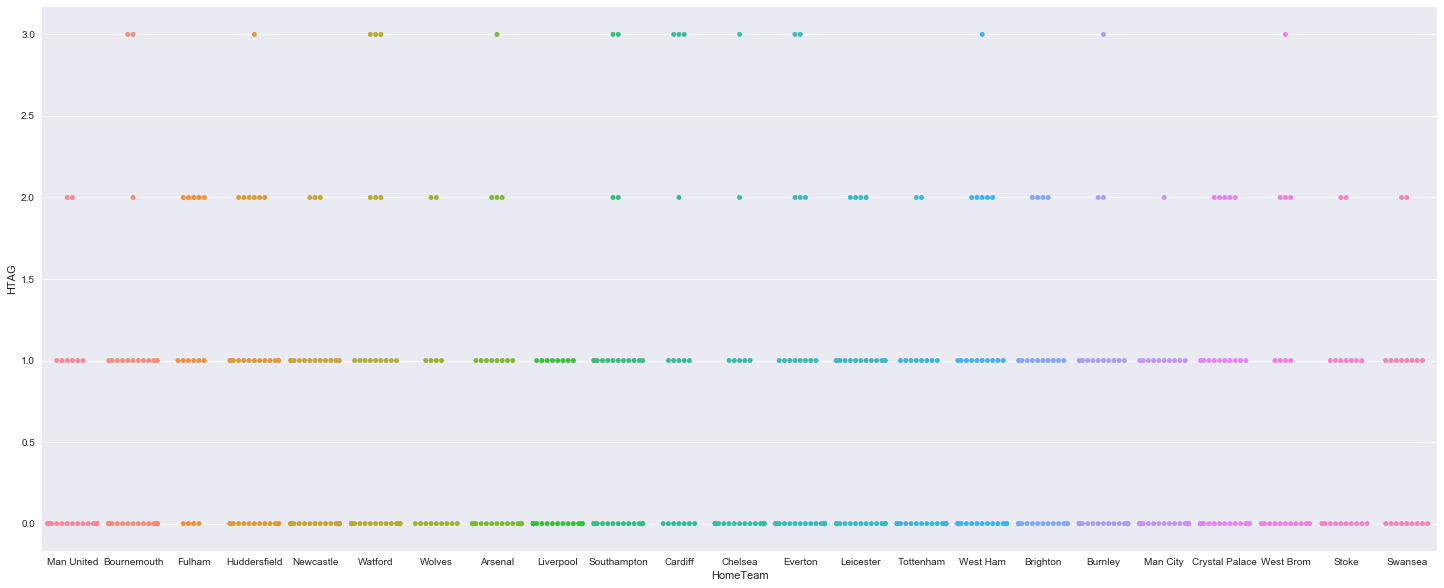

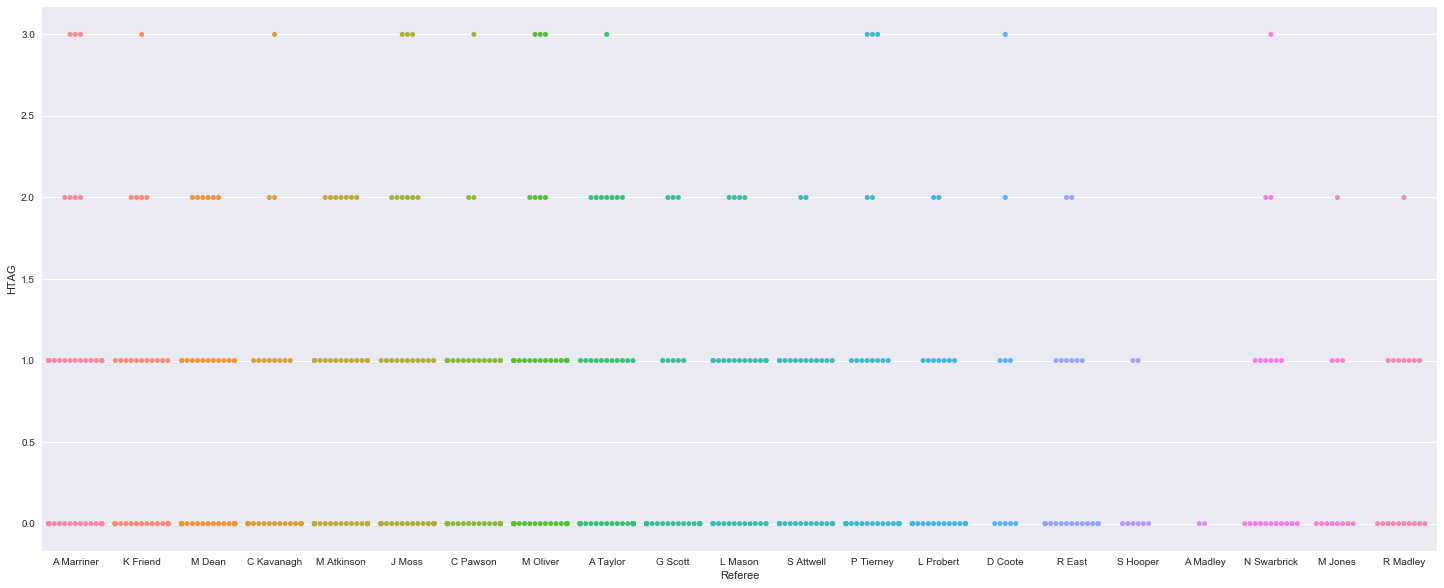

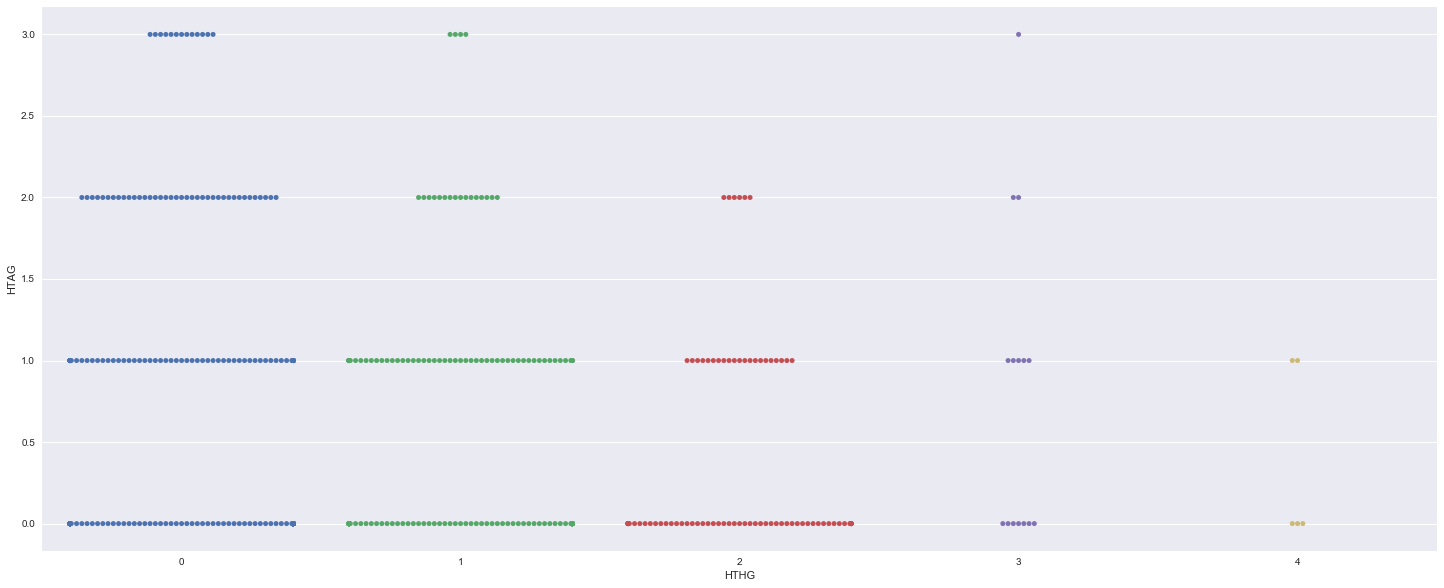

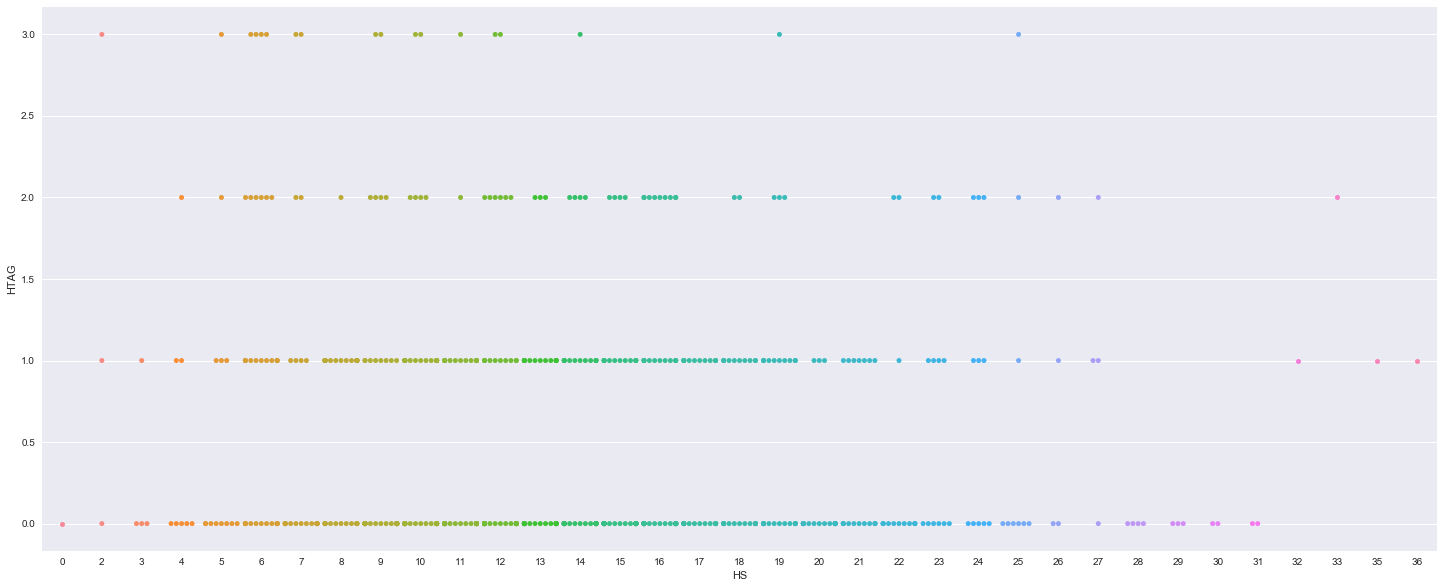

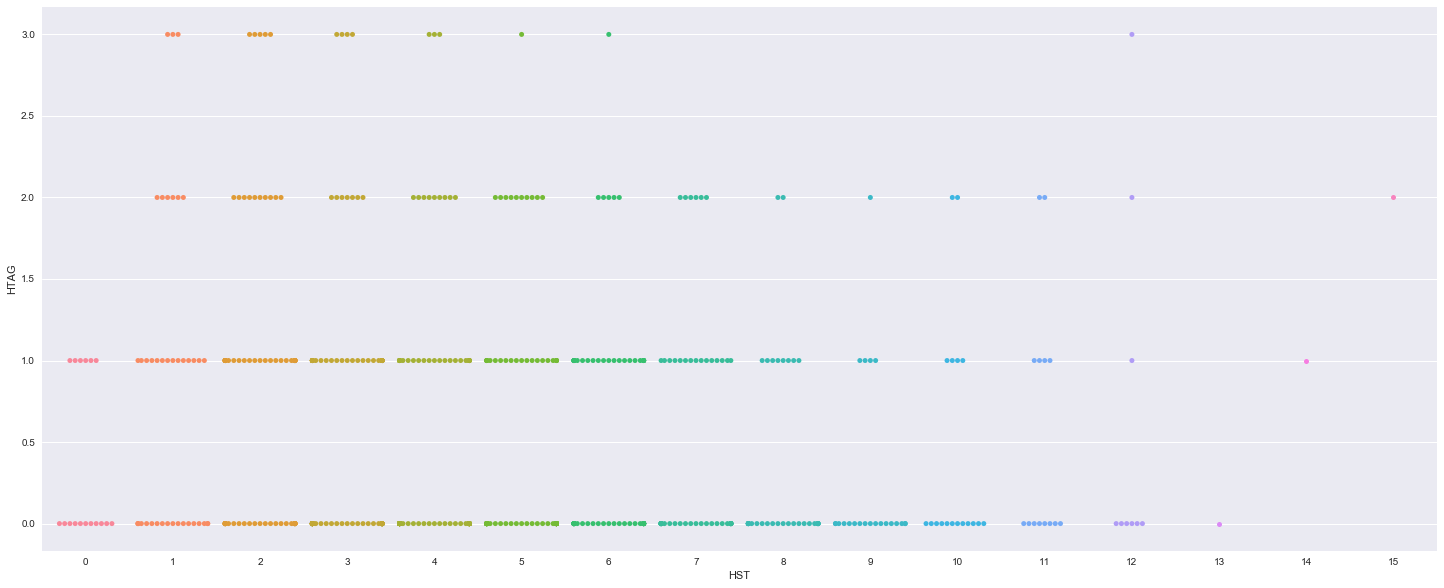

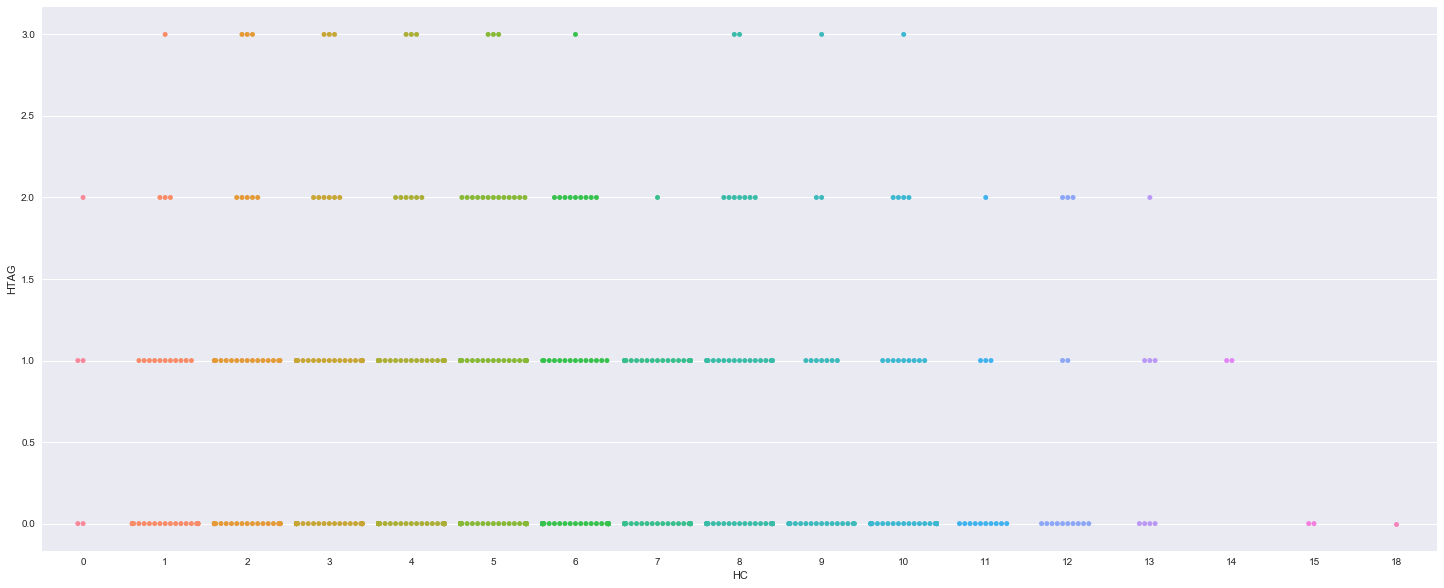

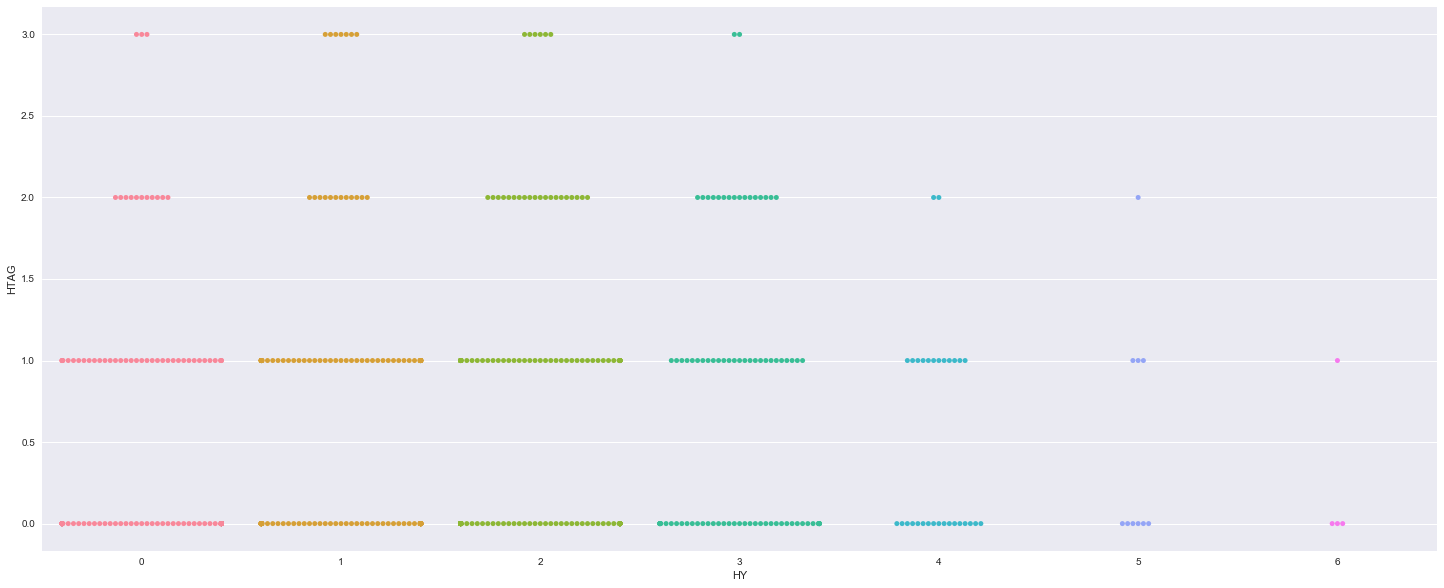

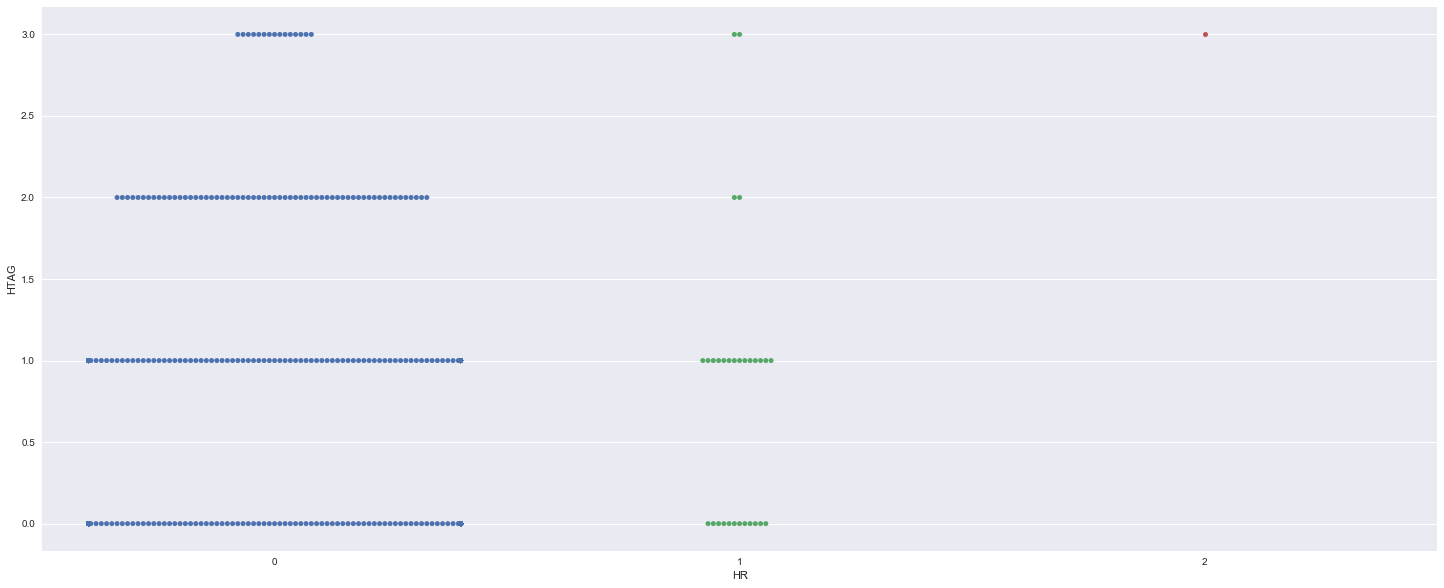

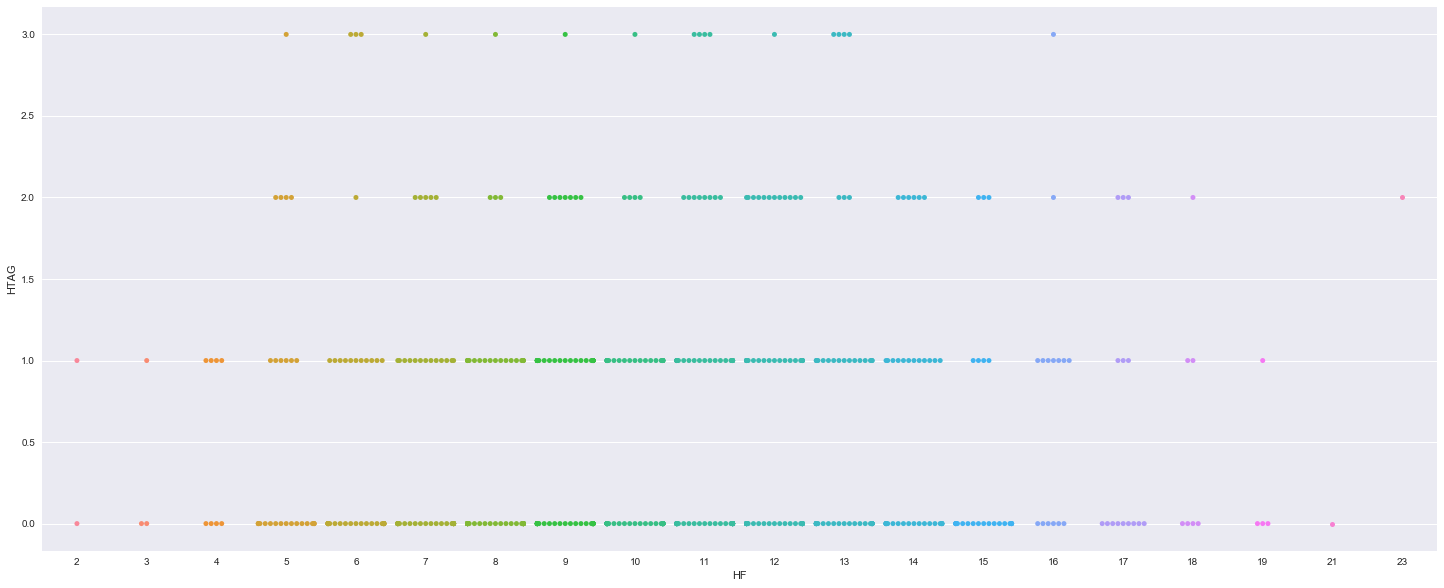

In [16]:
# now lets look at total score swarm plots by home features
home_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in home_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

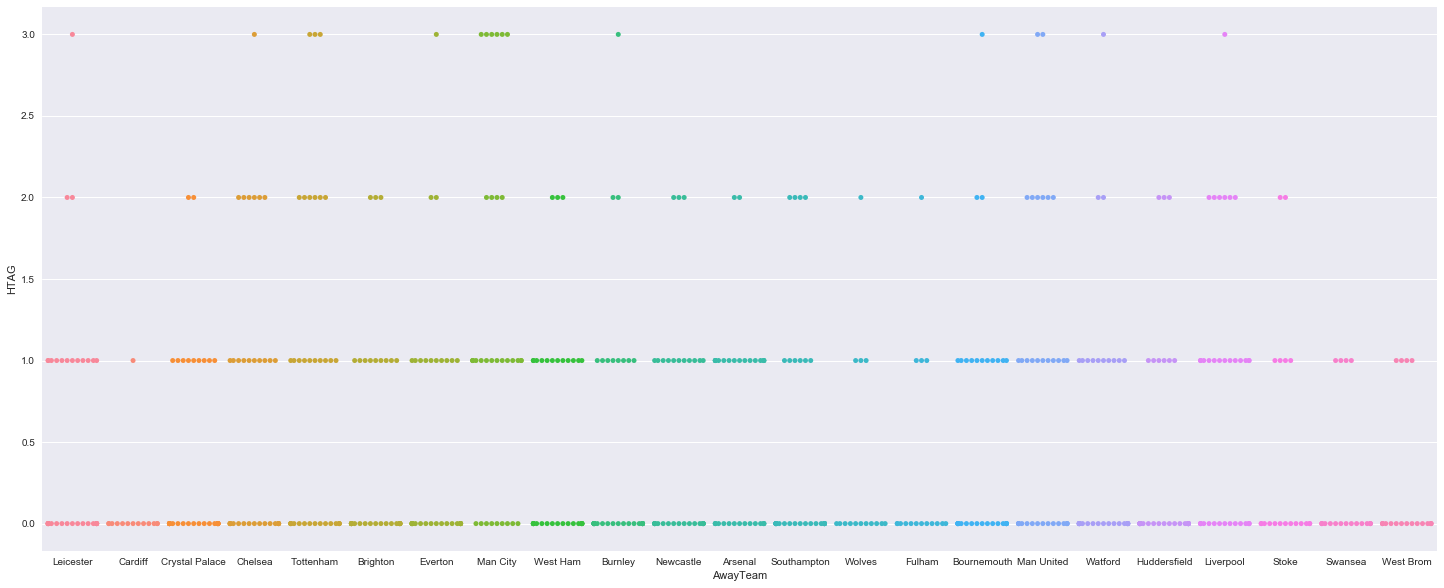

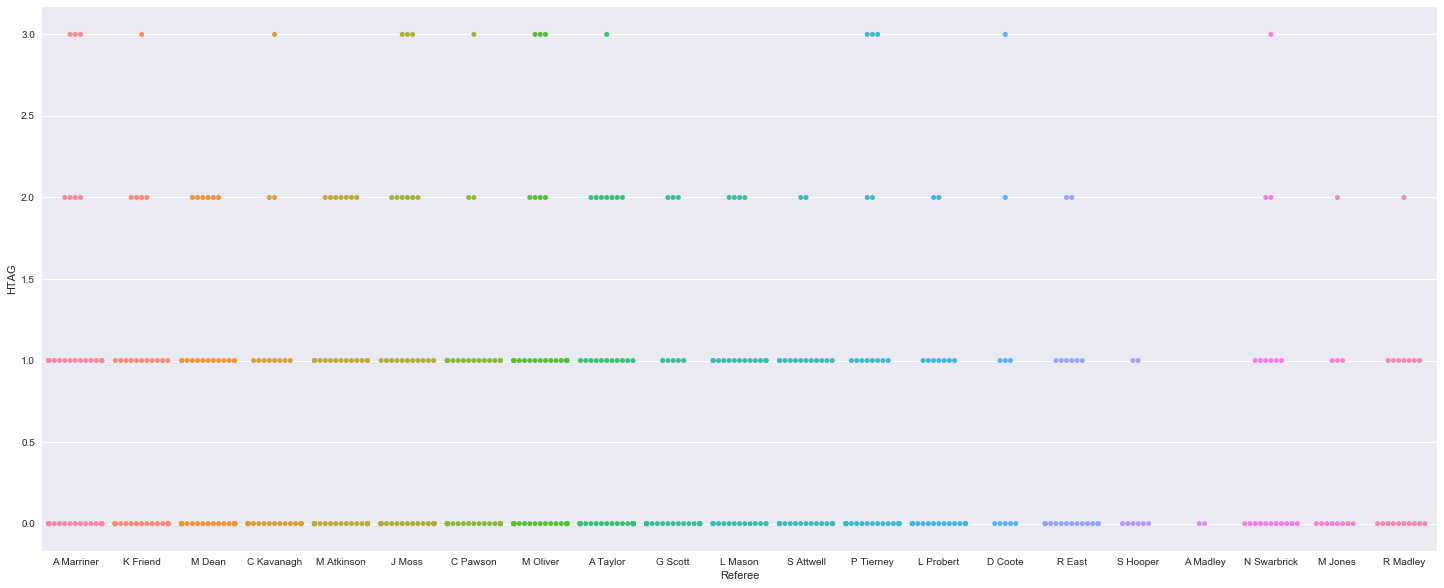

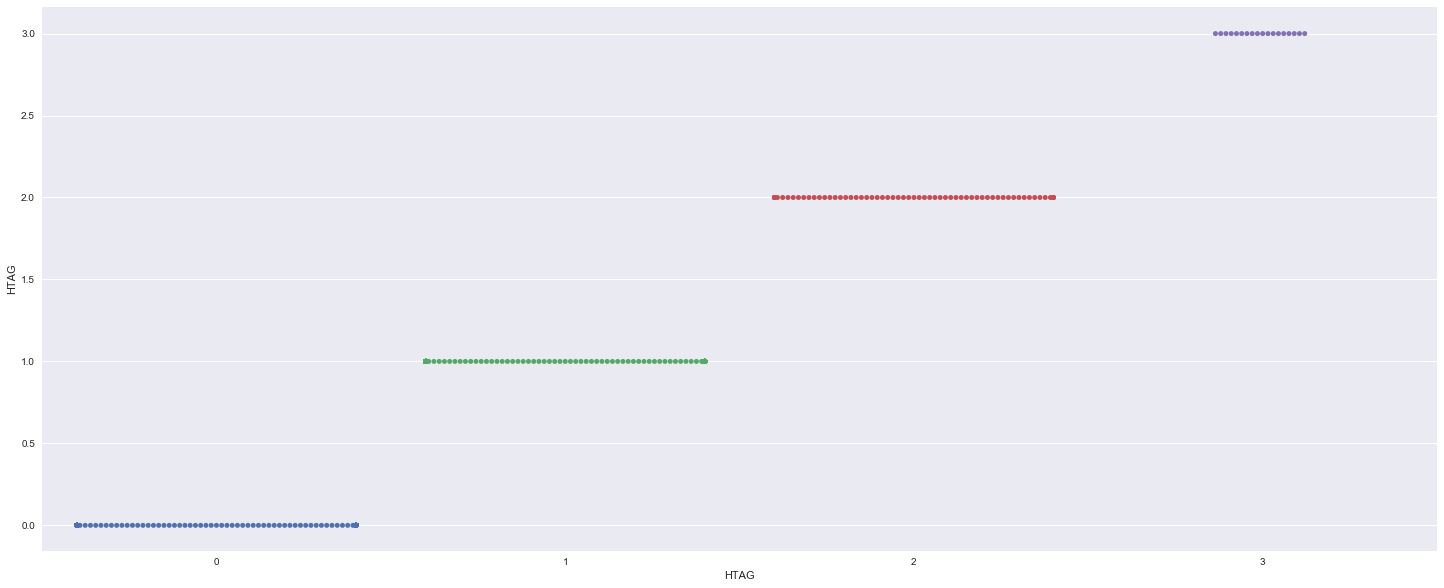

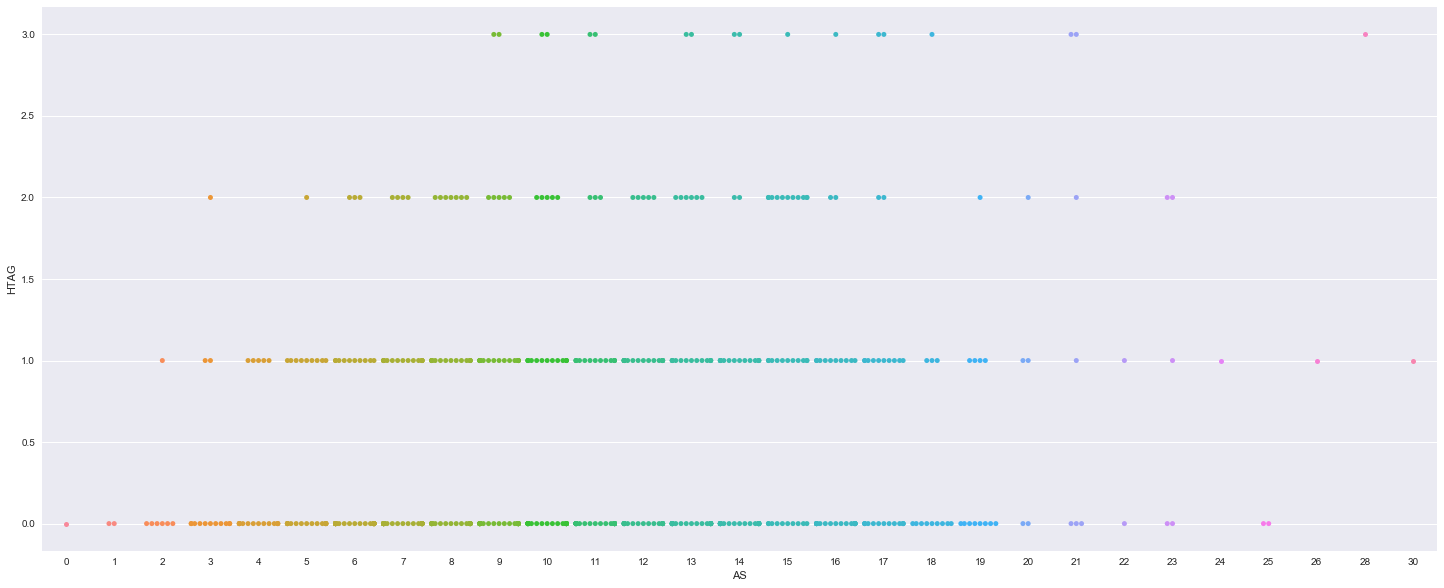

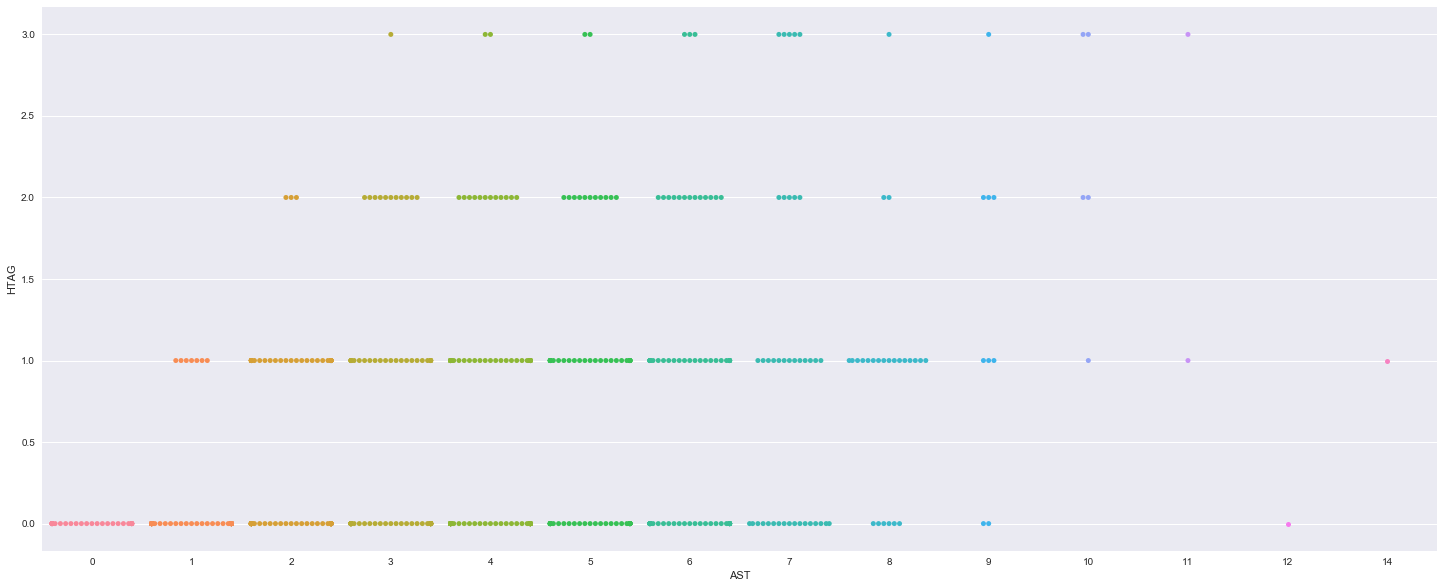

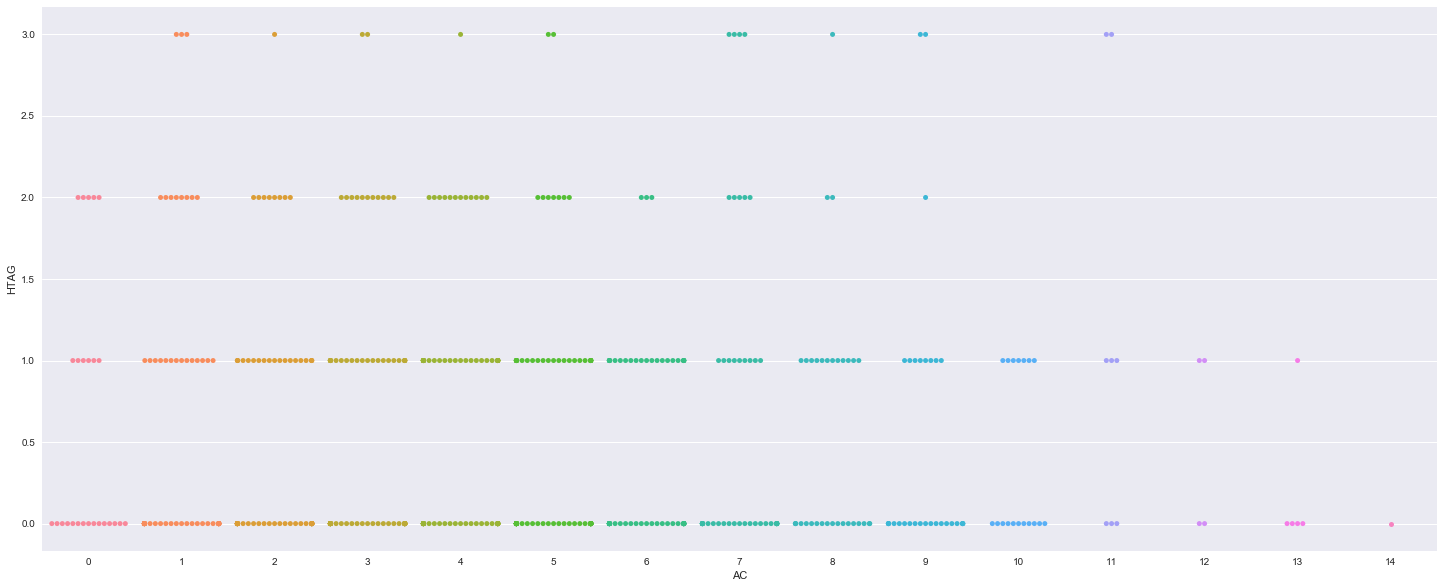

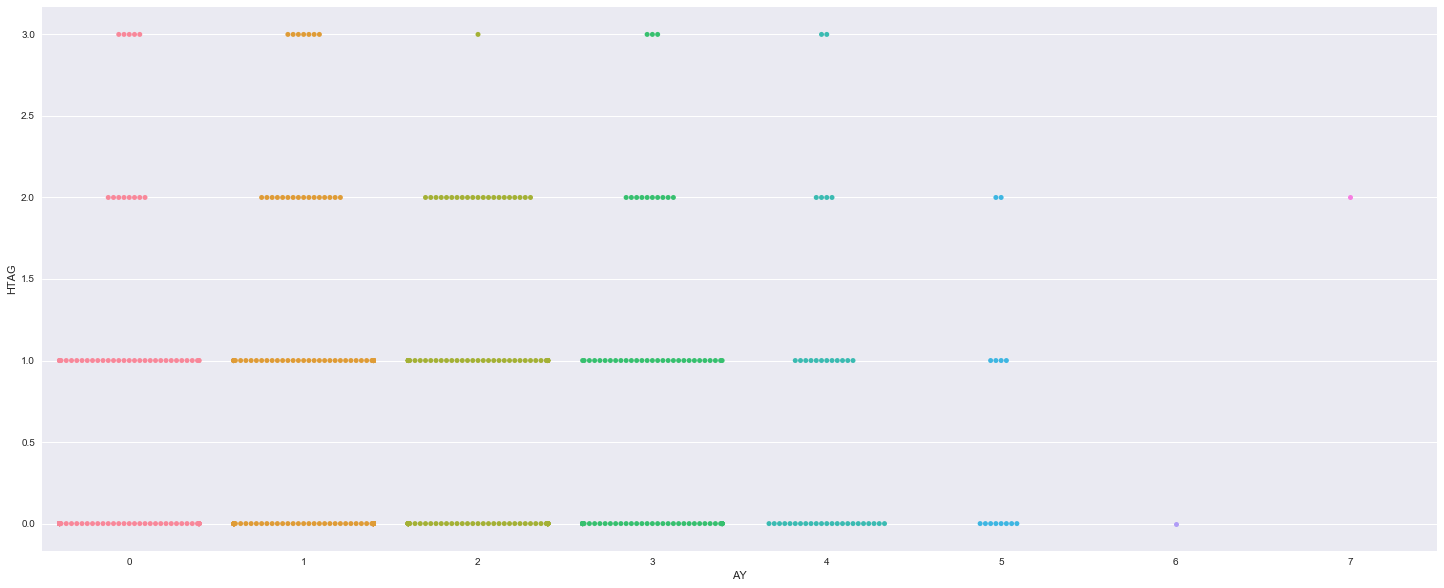

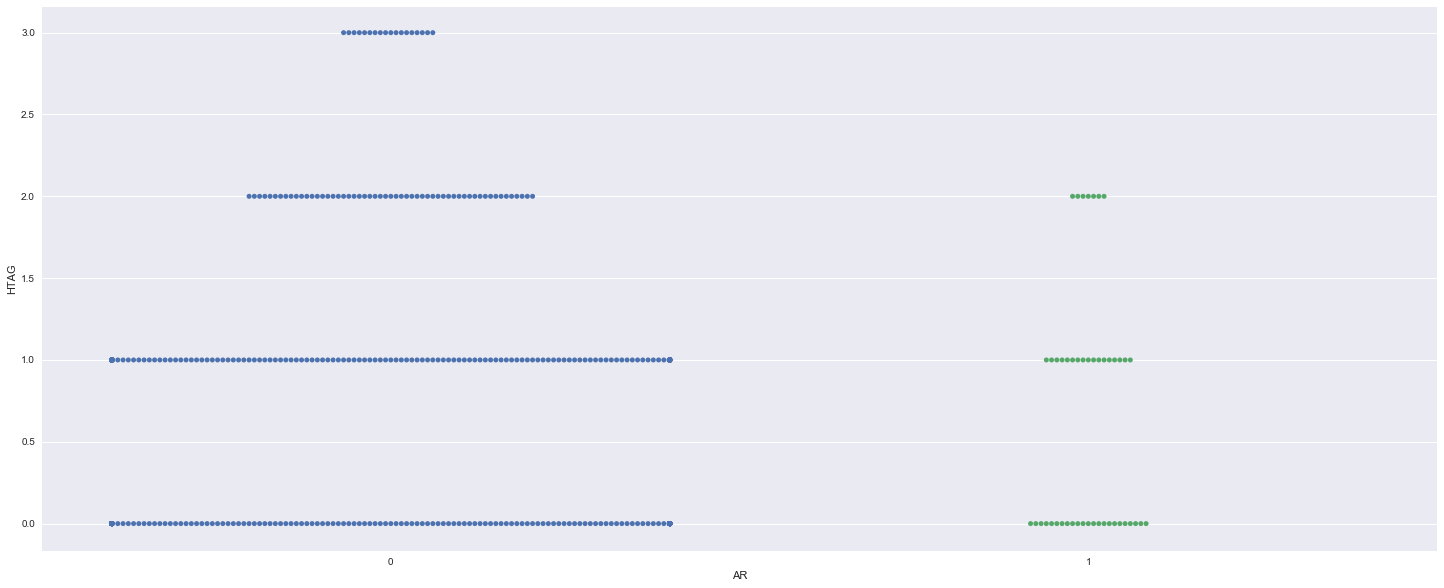

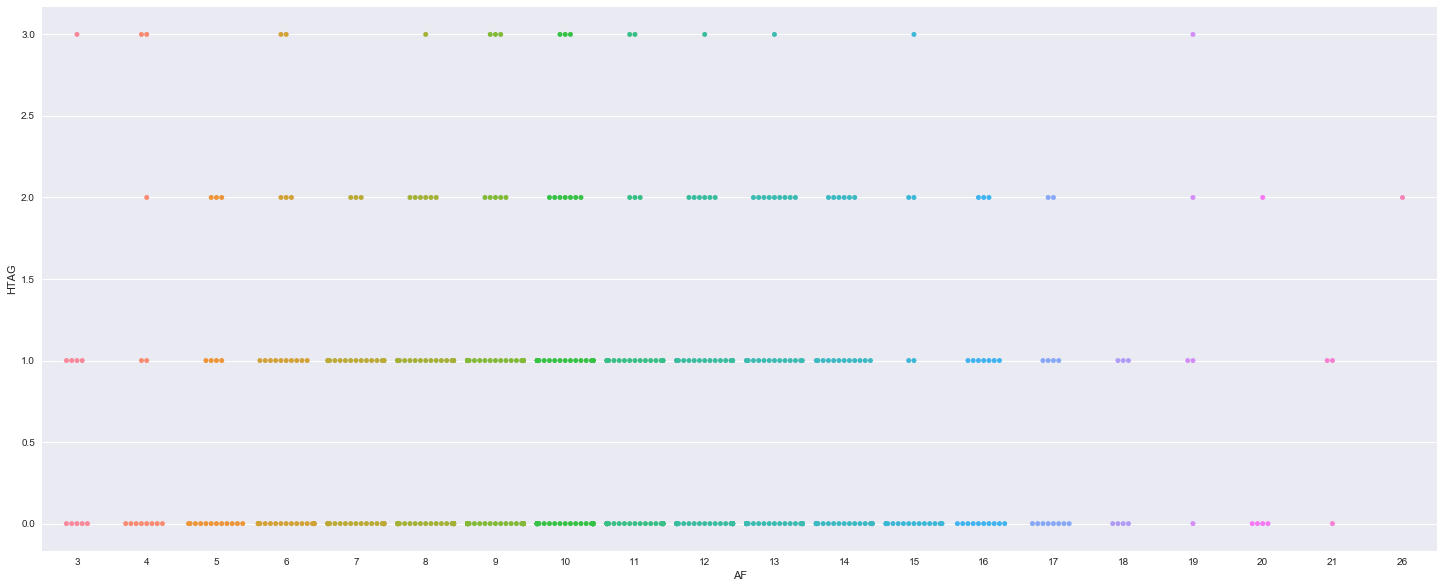

In [17]:
# now lets look at total score swarm plots by away features
away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1440x720 with 0 Axes>

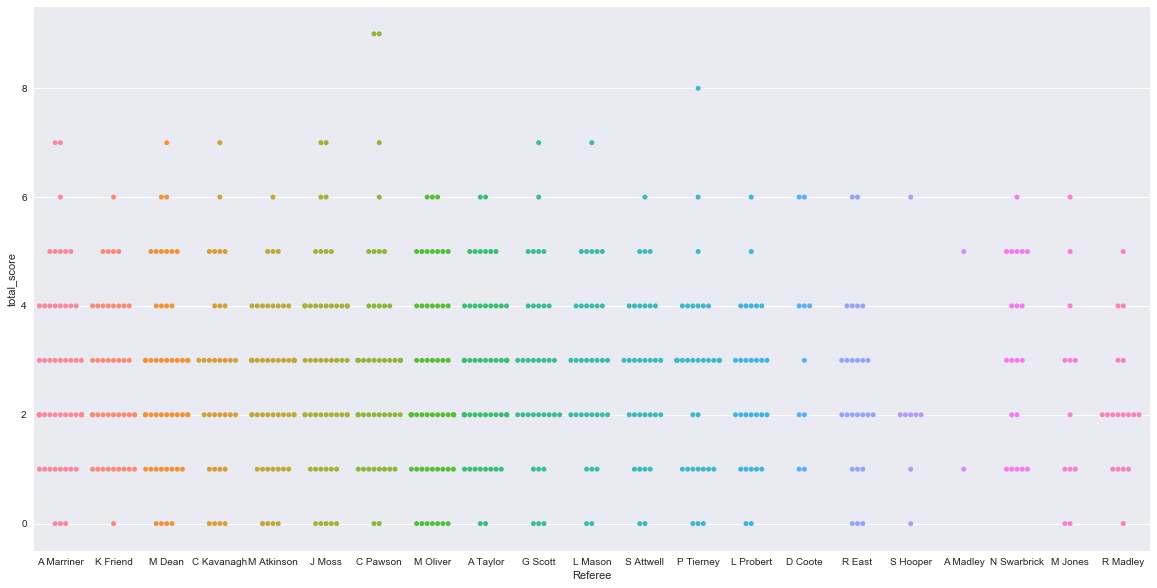

In [18]:
# total score swarmplots by referee
plt.figure(figsize=(20,10)) 
sns.swarmplot(df_total.Referee, df_total.total_score)

<Figure size 1800x720 with 0 Axes>

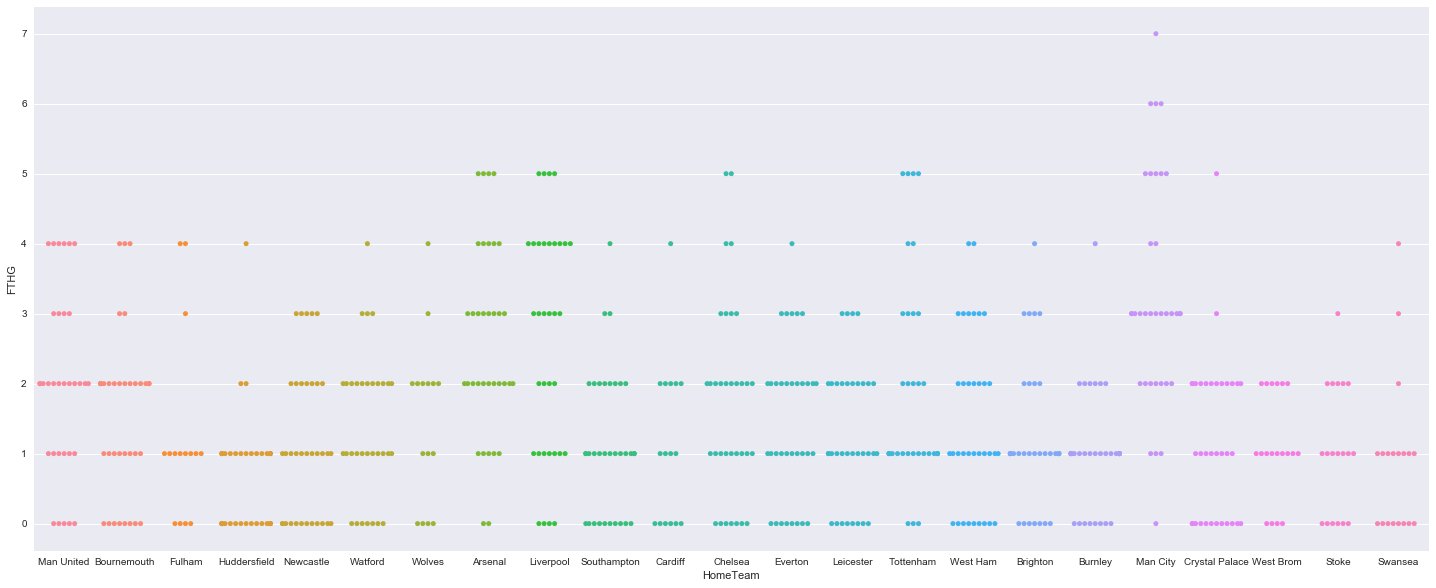

In [19]:
# home score swarmplots by HomeTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.HomeTeam, df_total.FTHG)

### Looks like Man City, Man United, and Liverpool (YNWA) have been doing great at home recently which makes sense if you have been following the EPL the past couple seasons

<Figure size 1800x720 with 0 Axes>

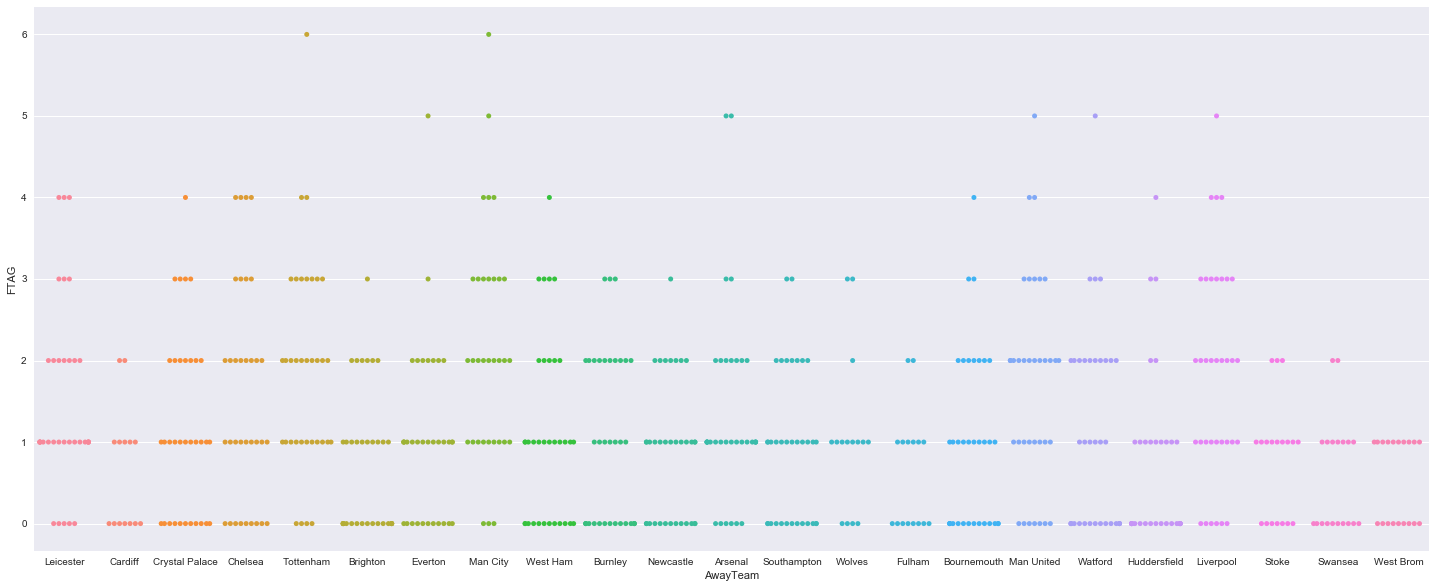

In [20]:
# away score swarmplots by AwayTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.AwayTeam, df_total.FTAG)

### looks like Spurs, Man City, and Liverpool (YNWA) have been doing great away from home lately which makes sense if you have been following the EPL the past couple seasons

<Figure size 1440x720 with 0 Axes>

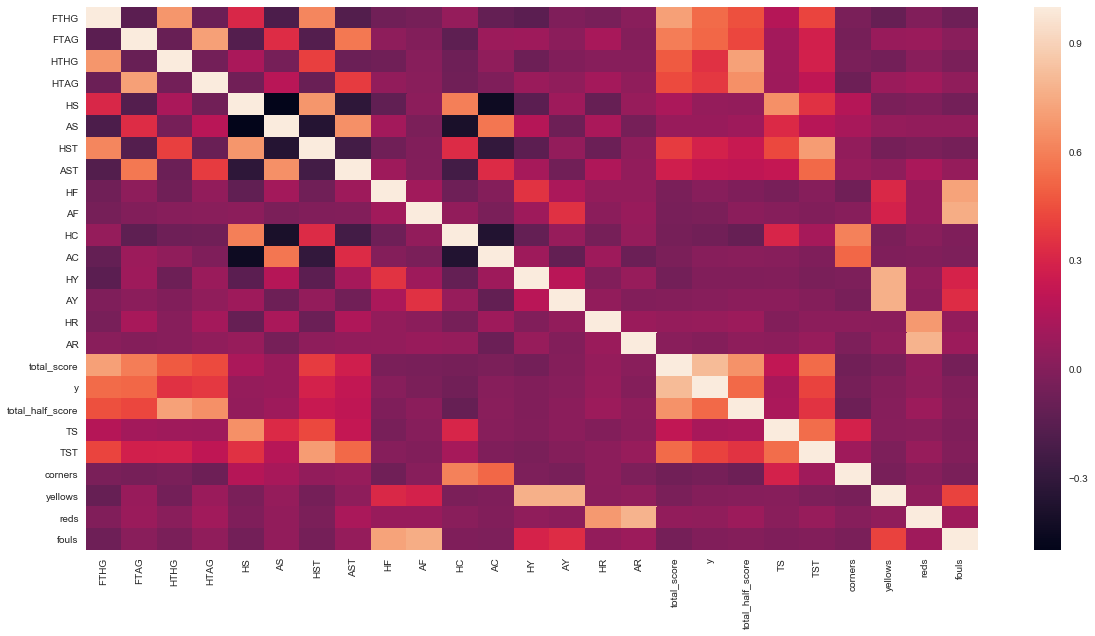

In [21]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_total.corr())
plt.show()

In [22]:
df_total.insert(loc=0, column='y', 
              value=df_total.y, 
              allow_duplicates=True) # move y to front of dataframe
df_total.info()
df_total.head()
df_total.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(26), object(4)
memory usage: 160.4+ KB


y        Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2018-08-10    Man United       Leicester     2     1     1     0   
1  0  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  0  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  1  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  1  2018-08-11     Newcastle       Tottenham     1     2     1     2   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   

   y  total_half_score  TS  TST  corners  yellows  reds  fouls  
0  1                 1  21   10        7        3     0     19  
1  0                 1  22    5       11        2     0     20  
2  0                 1  25   15       10        3     0     20  
3  1                 2  19    5        7        3     0     17  
4  1                 3  30    7        8        4     0     23

y        Date     HomeTeam   AwayTeam  FTHG  FTAG  HTHG  HTAG  \
679  1  2018-05-13    Newcastle    Chelsea     3     0     1     0   
680  0  2018-05-13  Southampton   Man City     0     1     0     0   
681  1  2018-05-13      Swansea      Stoke     1     2     1     2   
682  1  2018-05-13    Tottenham  Leicester     5     4     1     2   
683  1  2018-05-13     West Ham    Everton     3     1     1     0   

        Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  \
679  M Atkinson  16   6    6    2  11  10   4   2   0   1   0   0   
680  A Marriner   8  13    3    2   8  10   1  12   3   1   0   0   
681    A Taylor  26   8   11    5  12   9   6   0   1   2   0   0   
682    C Pawson  14  16    6    9   9  13   4   4   1   2   0   0   
683     G Scott  15  14    4    7  10  13   6   6   0   1   0   0   

     total_score  y  total_half_score  TS  TST  corners  yellows  reds  fouls  
679            3  1                 1  22    8        6        1     0     21  
680            1  0                 0  21    5       13        4     0     18  
681            3  1                 3  34   16        6        3     0     21  
682            9  1                 3  30   15        8        3     0     22  
683            4  1                 1  29   11       12        1     0     23

In [23]:
df_total = df_total.loc[:,~df_total.columns.duplicated()]
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 29 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 155.0+ KB


y        Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2018-08-10    Man United       Leicester     2     1     1     0   
1  0  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  0  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  1  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  1  2018-08-11     Newcastle       Tottenham     1     2     1     2   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   

   total_half_score  TS  TST  corners  yellows  reds  fouls  
0                 1  21   10        7        3     0     19  
1                 1  22    5       11        2     0     20  
2                 1  25   15       10        3     0     20  
3                 2  19    5        7        3     0     17  
4                 3  30    7        8        4     0     23

### Although a lot of the features we have analyze so far are very interesting in how they relate to our binary variable we are intending to predict, astute machine learning engineers following along closely will have noticed that a number of these features provided with each sample will not be available to be used in our model to predict whether or not a game will have more than 2.5 goals at the time before the game.  For example, we will not know how many goals an away or home side will score in the game we want to predict until after the game has occured.  However, we can draw useful information from these features by calculating features such as a particular teams last total goals scored in last 5 games (we can also do the same for other features like shots and # of cards).  

### lets start creating a function to create these fields as it will be tedious given the structure of the data (away/home, yet last 5 scores doesn't care about home or away

In [24]:
df_list = set(df.HomeTeam.unique().tolist())
df2_list = set(df2.AwayTeam.unique().tolist())
df_set = df_list.union(df2_list)
teamList = list(df_set)
teamList
len(teamList) # check # teams

['Huddersfield',
 'Wolves',
 'Southampton',
 'Man City',
 'Cardiff',
 'Brighton',
 'West Brom',
 'Fulham',
 'Newcastle',
 'Arsenal',
 'Chelsea',
 'Watford',
 'Leicester',
 'West Ham',
 'Man United',
 'Liverpool',
 'Bournemouth',
 'Tottenham',
 'Crystal Palace',
 'Stoke',
 'Swansea',
 'Burnley',
 'Everton']

23

In [25]:
df_total = df_total.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
df_total['idx_test'] = df_total.index
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 160.4+ KB


y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12       West Brom   Bournemouth     1     0     1     0   
2  0  2017-08-12        Brighton      Man City     0     2     0     0   
3  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
4  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   

    Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0    M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1  R Madley  16   9    6    2  15   3   8   2   3   1   0   0            1   
2  M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
3  C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
4    J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  
0                 4  33   13       13        1     0     21         0  
1                 1  25    8       10        4     0     18         1  
2                 0  20    6       13        2     0     15         2  
3                 3  29   11       13        6     2     27         3  
4                 2  22   10       21        4     0     26         4

In [26]:
def last5_byteam(df=df_total, team='Arsenal'):
    dfteam = df_total.loc[((df_total.HomeTeam == team) | (df_total.AwayTeam == team)), :]
    dfteam = dfteam.drop(columns=['Referee'])
    dfteam.head()
    dfteam['team'] = team

    def goals(row, home, away):
        if row["HomeTeam"] == team:
            return row[home]
        elif row["AwayTeam"] == team:
            return row[away]

    dfteam['goals'] = dfteam.apply(goals, axis=1, home='FTHG', away='FTAG')
    dfteam['h_goals'] = dfteam.apply(goals, axis=1, home='HTHG', away='HTAG')
    dfteam['shots'] = dfteam.apply(goals, axis=1, home='HS', away='AS')
    dfteam['shots_on'] = dfteam.apply(goals, axis=1, home='HST', away='AST')
    dfteam['fls'] = dfteam.apply(goals, axis=1, home='HF', away='AF')
    dfteam['corns'] = dfteam.apply(goals, axis=1, home='HC', away='AC')
    dfteam['yells'] = dfteam.apply(goals, axis=1, home='HY', away='AY')
    dfteam['rds'] = dfteam.apply(goals, axis=1, home='HR', away='AR')
    
    dfteam = dfteam.sort_values(by=['Date']).reset_index(drop=True)
    
    dfteam['last5goals'] = dfteam.goals.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5Hgoals'] = dfteam.h_goals.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5shots'] = dfteam.shots.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5shots_on'] = dfteam.shots_on.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5fls'] = dfteam.fls.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5corns'] = dfteam.corns.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5yells'] = dfteam.yells.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5reds'] = dfteam.rds.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5total_goals'] = dfteam.total_score.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5total_Hgoals'] = dfteam.total_half_score.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam2 = dfteam[['Date','team', 'last5goals', 'last5Hgoals',
                      'last5shots', 'last5shots_on', 'last5fls',
                      'last5corns', 'last5yells', 'last5reds',
                      'last5total_goals', 'last5total_Hgoals']] # drop columns don't need
    
    return dfteam2

df_dict = {}
for team in teamList:
    df_dict[team] = last5_byteam(team=team)
    
df_dict['Man United'].head()
len(df_dict) # check df # matches # of teams

Date        team  last5goals  last5Hgoals  last5shots  last5shots_on  \
0  2017-08-13  Man United         0.0          0.0         0.0            0.0   
1  2017-08-19  Man United         4.0          1.0        22.0            6.0   
2  2017-08-26  Man United         8.0          2.0        39.0           14.0   
3  2017-09-09  Man United        10.0          2.0        61.0           21.0   
4  2017-09-17  Man United        12.0          3.0        79.0           29.0   

   last5fls  last5corns  last5yells  last5reds  last5total_goals  \
0       0.0         0.0         0.0        0.0               0.0   
1      19.0        11.0         2.0        0.0               4.0   
2      30.0        16.0         3.0        0.0               8.0   
3      38.0        25.0         4.0        0.0              10.0   
4      48.0        36.0         4.0        0.0              14.0   

   last5total_Hgoals  
0                0.0  
1                1.0  
2                2.0  
3                2.0  
4                4.0

23

In [27]:
df_total = df_total.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
df_total['idx_test'] = df_total.index
df_total.to_csv('testv2.csv')
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 160.4+ KB


y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12       West Brom   Bournemouth     1     0     1     0   
2  0  2017-08-12        Brighton      Man City     0     2     0     0   
3  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
4  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   

    Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0    M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1  R Madley  16   9    6    2  15   3   8   2   3   1   0   0            1   
2  M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
3  C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
4    J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  
0                 4  33   13       13        1     0     21         0  
1                 1  25    8       10        4     0     18         1  
2                 0  20    6       13        2     0     15         2  
3                 3  29   11       13        6     2     27         3  
4                 2  22   10       21        4     0     26         4

### joining all these team unique DFs to our original DF will be process and time intensive and will be tedious using pandas programming, so lets use PySpark so we can programmatically write SQL statements to accomplish finally creating these fields easily.

In [28]:
# find spark
import findspark
findspark.init()

# build spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("ddapp") \
    .getOrCreate()

# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [29]:
# create SparkDataFrame from df_total
sp_df = spark.createDataFrame(df_total)
sp_df.show(3)

# build dict with spark DataFrames
sdf_dict = {}
for k, v in df_dict.items():
    sdf_dict[k] = spark.createDataFrame(v)

sdf_dict['Man United'].show(3)
type(sdf_dict['Man United']) # verify spark dataframe type
len(sdf_dict) # check df # matches # of teams

+---+----------+---------+-----------+----+----+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+-----------+----------------+---+---+-------+-------+----+-----+--------+
|  y|      Date| HomeTeam|   AwayTeam|FTHG|FTAG|HTHG|HTAG| Referee| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|total_score|total_half_score| TS|TST|corners|yellows|reds|fouls|idx_test|
+---+----------+---------+-----------+----+----+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+-----------+----------------+---+---+-------+-------+----+-----+--------+
|  1|2017-08-11|  Arsenal|  Leicester|   4|   3|   2|   2|  M Dean| 27|  6| 10|  3|  9| 12|  9|  4|  0|  1|  0|  0|          7|               4| 33| 13|     13|      1|   0|   21|       0|
|  0|2017-08-12|West Brom|Bournemouth|   1|   0|   1|   0|R Madley| 16|  9|  6|  2| 15|  3|  8|  2|  3|  1|  0|  0|          1|               1| 25|  8|     10|      4|   0|   18|       1|
|  0|2017-08-12| Brighton|   Man City|   0|   2|   0|  

pyspark.sql.dataframe.DataFrame

23

In [30]:
# create list of tempviews for spark sql
spsql_list = []
for team in teamList:
    sdf_dict[team].createOrReplaceTempView((str(team).replace(" ", "_")+'_sql'))
    spsql_list.append(((str(team).replace(" ", "_")+'_sql')))

spsql_list

['Huddersfield_sql',
 'Wolves_sql',
 'Southampton_sql',
 'Man_City_sql',
 'Cardiff_sql',
 'Brighton_sql',
 'West_Brom_sql',
 'Fulham_sql',
 'Newcastle_sql',
 'Arsenal_sql',
 'Chelsea_sql',
 'Watford_sql',
 'Leicester_sql',
 'West_Ham_sql',
 'Man_United_sql',
 'Liverpool_sql',
 'Bournemouth_sql',
 'Tottenham_sql',
 'Crystal_Palace_sql',
 'Stoke_sql',
 'Swansea_sql',
 'Burnley_sql',
 'Everton_sql']

In [31]:
# build each teams "last 5" dataframe 
spdf_dict = {}
for s in spsql_list:
    sp_df.createOrReplaceTempView("spdf_sql")
    query = """select a.*, 
                 b.team, 
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5goals else 0 end) as homeLast5goals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5goals else 0 end) as awayLast5goals,
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5Hgoals else 0 end) as homeLast5Hgoals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5Hgoals else 0 end) as awayLast5Hgoals,
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5shots else 0 end) as homeLast5shots,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5shots else 0 end) as awayLast5shots,
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5shots_on else 0 end) as homeLast5shots_on,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5shots_on else 0 end) as awayLast5shots_on,    
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5fls else 0 end) as homeLast5fls,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5fls else 0 end) as awayLast5fls,
                  
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5yells else 0 end) as homeLast5yells,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5yells else 0 end) as awayLast5yells, 
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5reds else 0 end) as homeLast5reds,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5reds else 0 end) as awayLast5reds,
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5corns else 0 end) as homeLast5corns,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5corns else 0 end) as awayLast5corns, 
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5total_goals else 0 end) as homeLast5total_goals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5total_goals else 0 end) as awayLast5total_goals,
                                            
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5total_Hgoals else 0 end) as homeLast5total_Hgoals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5total_Hgoals else 0 end) as awayLast5total_Hgoals
               from spdf_sql as a 
                 left join {} as b 
                   on a.Date = b.Date and (a.HomeTeam = b.team OR a.AwayTeam = b.team)
                order by a.Date""".format(s)
    sqlDF = spark.sql(query)
    sqlDF[['y', 'Date', 'HomeTeam', 'AwayTeam', 'team', \
           'FTHG', 'FTAG', 'total_score', 
           'homeLast5goals', 'awayLast5goals']].show(20)
    type(sqlDF)
    spdf_dict[s] = sqlDF
    spdf_dict.keys()

+---+----------+--------------+--------------+------------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|        team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+------------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|        null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|        null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|        null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|        null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|        null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|Huddersfield|   0|   3|          3|           0.0|        

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql'])

+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|       team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|       null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|Southampton|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|       null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|       null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|       null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|       null|   1|   0|          1|           0.0|           0.0|
|

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|Man City|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Pala

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|    null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|Brighton|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chels

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|West Brom|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|null|   0|   3|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|Arsenal|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     L

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|Leicester|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|    null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|    null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|    null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Br

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql'])

+---+----------+--------------+--------------+----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|      team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|      null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|      null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|      null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|      null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|      null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|      null|   0|   2|          2|           0.0|           0.0|
|  1|2017-

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|Liverpool|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|     null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Cry

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql'])

+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|       team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|       null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|       null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|       null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|Bournemouth|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|       null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|       null|   2|   3|          5|           0.0|           0.0|
|

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql'])

+---+----------+--------------+--------------+--------------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|          team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|          null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|Crystal Palace|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|          null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|          null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|          null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|          null|   0|   0|          0|     

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql', 'Crystal_Palace_sql'])

+---+----------+--------------+--------------+-----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam| team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester| null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield| null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|Stoke|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth| null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea| null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City| null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley| null|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql', 'Crystal_Palace_sql', 'Stoke_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|Swansea|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|       Watford|     L

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql', 'Crystal_Palace_sql', 'Stoke_sql', 'Swansea_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql', 'Crystal_Palace_sql', 'Stoke_sql', 'Swansea_sql', 'Burnley_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|Everton|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql', 'Crystal_Palace_sql', 'Stoke_sql', 'Swansea_sql', 'Burnley_sql', 'Everton_sql'])

In [32]:
pandas_dict = {}
for key, spark_sqlDF in spdf_dict.items():
    pandas_dict[key] = spdf_dict[key].toPandas()
    
pandas_dict['Arsenal_sql'].head()
pandas_dict['Arsenal_sql'].info()
df_total.head()
df_total.info()

y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12       West Brom   Bournemouth     1     0     1     0   
2  0  2017-08-12        Brighton      Man City     0     2     0     0   
3  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
4  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   

    Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0    M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1  R Madley  16   9    6    2  15   3   8   2   3   1   0   0            1   
2  M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
3  C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
4    J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  \
0                 4  33   13       13        1     0     21         0   
1                 1  25    8       10        4     0     18         1   
2                 0  20    6       13        2     0     15         2   
3                 3  29   11       13        6     2     27         3   
4                 2  22   10       21        4     0     26         4   

      team  homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0  Arsenal             0.0             0.0              0.0              0.0   
1     None             0.0             0.0              0.0              0.0   
2     None             0.0             0.0              0.0              0.0   
3     None             0.0             0.0              0.0              0.0   
4     None             0.0             0.0              0.0              0.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   

   homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  homeLast5reds  \
0           0.0           0.0             0.0             0.0            0.0   
1           0.0           0.0             0.0             0.0            0.0   
2           0.0           0.0             0.0             0.0            0.0   
3           0.0           0.0             0.0             0.0            0.0   
4           0.0           0.0             0.0             0.0            0.0   

   awayLast5reds  homeLast5corns  awayLast5corns  homeLast5total_goals  \
0            0.0             0.0             0.0                   0.0   
1            0.0             0.0             0.0                   0.0   
2            0.0             0.0             0.0                   0.0   
3            0.0             0.0             0.0                   0.0   
4            0.0             0.0             0.0                   0.0   

   awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  
0                   0.0                    0.0                    0.0  
1                   0.0                    0.0                    0.0  
2                   0.0                    0.0                    0.0  
3                   0.0                    0.0                    0.0  
4                   0.0                    0.0                    0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 51 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
Referee                  object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HF                       int64
AF                       int64
HC                       int64
AC                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
total_score              int64
total_half_score         int64
TS                       int64
TST                      int64
corners                  int64
yellows                  int64
reds                     int64
fouls                  

y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12       West Brom   Bournemouth     1     0     1     0   
2  0  2017-08-12        Brighton      Man City     0     2     0     0   
3  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
4  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   

    Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0    M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1  R Madley  16   9    6    2  15   3   8   2   3   1   0   0            1   
2  M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
3  C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
4    J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  
0                 4  33   13       13        1     0     21         0  
1                 1  25    8       10        4     0     18         1  
2                 0  20    6       13        2     0     15         2  
3                 3  29   11       13        6     2     27         3  
4                 2  22   10       21        4     0     26         4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 160.4+ KB


In [33]:
pandas_dict.keys()

dict_keys(['Huddersfield_sql', 'Wolves_sql', 'Southampton_sql', 'Man_City_sql', 'Cardiff_sql', 'Brighton_sql', 'West_Brom_sql', 'Fulham_sql', 'Newcastle_sql', 'Arsenal_sql', 'Chelsea_sql', 'Watford_sql', 'Leicester_sql', 'West_Ham_sql', 'Man_United_sql', 'Liverpool_sql', 'Bournemouth_sql', 'Tottenham_sql', 'Crystal_Palace_sql', 'Stoke_sql', 'Swansea_sql', 'Burnley_sql', 'Everton_sql'])

In [34]:
# make list of dataframes to use in append
pds_list = []
for k, v in pandas_dict.items():
    pds_list.append(v)

In [35]:
df_last5 = (reduce(lambda df1, df2: 
                  df1.append(df2,  ignore_index=True), 
                  pds_list)).groupby(['idx_test', 'Date'])\
                  ['homeLast5goals', 'awayLast5goals', 
                   'homeLast5Hgoals', 'awayLast5Hgoals',
                   'homeLast5shots', 'awayLast5shots', 
                   'homeLast5shots_on', 'awayLast5shots_on',
                   'homeLast5fls', 'awayLast5fls', 
                   'homeLast5yells', 'awayLast5yells',
                   'homeLast5reds', 'awayLast5reds',
                   'homeLast5corns', 'awayLast5corns',
                   'homeLast5total_goals', 'awayLast5total_goals',
                   'homeLast5total_Hgoals', 'awayLast5total_Hgoals'].sum()\
                                                                    .reset_index(drop=False)

df_last5.info()
df_last5.tail(10)
df_total.info() # check to make sure tables have same rows
df_total.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 22 columns):
idx_test                 int64
Date                     object
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(1), object(1)
memory usage: 117.6+ KB


idx_test        Date  homeLast5goals  awayLast5goals  homeLast5Hgoals  \
674       674  2019-03-09             5.0             4.0              2.0   
675       675  2019-03-09             6.0             6.0              3.0   
676       676  2019-03-10            11.0            10.0              8.0   
677       677  2019-03-10             9.0             7.0              4.0   
678       678  2019-03-10             9.0             7.0              5.0   
679       679  2019-03-16             8.0             8.0              2.0   
680       680  2019-03-16             4.0             8.0              3.0   
681       681  2019-03-16             6.0             2.0              5.0   
682       682  2019-03-17             5.0            10.0              3.0   
683       683  2019-03-17             3.0            12.0              2.0   

     awayLast5Hgoals  homeLast5shots  awayLast5shots  homeLast5shots_on  \
674              2.0            75.0            45.0               22.0   
675              1.0            54.0            69.0               22.0   
676              4.0            50.0            60.0               20.0   
677              4.0            77.0            60.0               26.0   
678              1.0            67.0            64.0               29.0   
679              2.0            52.0            98.0               17.0   
680              2.0            43.0            86.0               15.0   
681              0.0            48.0            47.0               18.0   
682              4.0            39.0            88.0               15.0   
683              6.0            55.0            79.0               20.0   

     awayLast5shots_on  homeLast5fls  awayLast5fls  homeLast5yells  \
674               16.0          48.0          58.0            11.0   
675               18.0          63.0          58.0             5.0   
676               26.0          52.0          49.0             7.0   
677               18.0          44.0          57.0             4.0   
678               21.0          57.0          43.0             8.0   
679               27.0          40.0          38.0             6.0   
680               27.0          41.0          55.0            10.0   
681               15.0          46.0          54.0             7.0   
682               25.0          56.0          46.0             4.0   
683               28.0          62.0          50.0             9.0   

     awayLast5yells  homeLast5reds  awayLast5reds  homeLast5corns  \
674             6.0            0.0            1.0            26.0   
675            10.0            0.0            0.0            28.0   
676            12.0            1.0            0.0            21.0   
677            10.0            0.0            0.0            26.0   
678             9.0            0.0            0.0            33.0   
679             5.0            0.0            0.0            28.0   
680            13.0            0.0            0.0            23.0   
681            10.0            0.0            1.0            24.0   
682             5.0            1.0            0.0            16.0   
683             9.0            0.0            0.0            19.0   

     awayLast5corns  homeLast5total_goals  awayLast5total_goals  \
674            17.0                   9.0                  10.0   
675            19.0                  14.0                  12.0   
676            24.0                  17.0                  13.0   
677            34.0                  20.0                  11.0   
678            29.0                  10.0                  15.0   
679            32.0                  19.0                  19.0   
680            31.0                  14.0                  13.0   
681            17.0                  11.0                   9.0   
682            32.0                  11.0                  18.0   
683            35.0                  16.0                  14.0   

     homeLast5total_Hgoals  awayLast5total_Hgoals  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 160.4+ KB


y        Date     HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
674  1  2019-03-09    Newcastle       Everton     3     2     0     2   
675  1  2019-03-09  Southampton     Tottenham     2     1     0     1   
676  0  2019-03-10      Arsenal    Man United     2     0     1     0   
677  0  2019-03-10      Chelsea        Wolves     1     1     0     0   
678  1  2019-03-10    Liverpool       Burnley     4     2     2     1   
679  1  2019-03-16      Burnley     Leicester     1     2     1     1   
680  1  2019-03-16  Bournemouth     Newcastle     2     2     0     1   
681  1  2019-03-16     West Ham  Huddersfield     4     3     1     2   
682  0  2019-03-17      Everton       Chelsea     2     0     0     0   
683  1  2019-03-17       Fulham     Liverpool     1     2     0     1   

        Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  \
674     L Mason  19   7    7    3  13  10   8   2   3   1   0   0   
675    K Friend  12  16    4    5  16   9   1  10   4   2   0   0   
676      J Moss  14  14    3    4  12  18   5   2   2   2   0   0   
677    M Oliver  22   2    6    1   8  14  13   0   1   4   0   0   
678  A Marriner  23   3    5    2   4   7   7   3   2   0   0   0   
679    M Oliver  13   9    2    4   9  10   9   3   1   1   0   1   
680      M Dean  10  12    3    4   9  12   6   6   3   2   0   0   
681      J Moss  16  15    5    5   7  15   5   8   0   2   0   0   
682    A Taylor  15  16    8    5  17   9   3   4   1   2   0   0   
683    C Pawson   7  16    2    6  11   7   1  10   2   1   0   0   

     total_score  total_half_score  TS  TST  corners  yellows  reds  fouls  \
674            5                 2  26   10       10        4     0     23   
675            3                 1  28    9       11        6     0     25   
676            2                 1  28    7        7        4     0     30   
677            2                 0  24    7       13        5     0     22   
678            6                 3  26    7       10        2     0     11   
679            3                 2  22    6       12        2     1     19   
680            4                 1  22    7       12        5     0     21   
681            7                 3  31   10       13        2     0     22   
682            2                 0  31   13        7        3     0     26   
683            3                 1  23    8       11        3     0     18   

     idx_test  
674       674  
675       675  
676       676  
677       677  
678       678  
679       679  
680       680  
681       681  
682       682  
683       683

In [36]:
df_final = df_total.merge(df_last5, on=['Date', 'idx_test'])
df_final.to_csv('test.csv')
df_final.info()
df_final.head(10)
df_final.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 50 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
Referee                  object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HF                       int64
AF                       int64
HC                       int64
AC                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
total_score              int64
total_half_score         int64
TS                       int64
TST                      int64
corners                  int64
yellows                  int64
reds                     int64
fouls                  

y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12       West Brom   Bournemouth     1     0     1     0   
2  0  2017-08-12        Brighton      Man City     0     2     0     0   
3  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
4  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   
5  0  2017-08-12         Everton         Stoke     1     0     1     0   
6  0  2017-08-12     Southampton       Swansea     0     0     0     0   
7  1  2017-08-12         Watford     Liverpool     3     3     2     1   
8  1  2017-08-13      Man United      West Ham     4     0     1     0   
9  0  2017-08-13       Newcastle     Tottenham     0     2     0     0   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1     R Madley  16   9    6    2  15   3   8   2   3   1   0   0            1   
2     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
3     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
4       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   
5  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1   
6      M Jones  29   4    2    0  10  13  13   0   2   1   0   0            0   
7     A Taylor   9  14    4    5  14   8   3   3   0   3   0   0            6   
8   M Atkinson  22   9    6    1  19   7  11   1   2   2   0   0            4   
9   A Marriner   6  18    3    6   6  10   5   7   1   2   1   0            2   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  \
0                 4  33   13       13        1     0     21         0   
1                 1  25    8       10        4     0     18         1   
2                 0  20    6       13        2     0     15         2   
3                 3  29   11       13        6     2     27         3   
4                 2  22   10       21        4     0     26         4   
5                 1  18    5       13        2     0     23         5   
6                 0  33    2       13        3     0     23         6   
7                 3  23    9        6        3     0     22         7   
8                 1  31    7       12        4     0     26         8   
9                 0  24    9       12        3     1     16         9   

   homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0             0.0             0.0              0.0              0.0   
1             0.0             0.0              0.0              0.0   
2             0.0             0.0              0.0              0.0   
3             0.0             0.0              0.0              0.0   
4             0.0             0.0              0.0              0.0   
5             0.0             0.0              0.0              0.0   
6             0.0             0.0              0.0              0.0   
7             0.0             0.0              0.0              0.0   
8             0.0             0.0              0.0              0.0   
9             0.0             0.0              0.0              0.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   
5             0.0             0.0                0.0                0.0   
6             0.0             0.0                0.0                0.0   
7             0.0             0.0                0.0                0.0   
8             0.0             0.0  

y        Date     HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
674  1  2019-03-09    Newcastle       Everton     3     2     0     2   
675  1  2019-03-09  Southampton     Tottenham     2     1     0     1   
676  0  2019-03-10      Arsenal    Man United     2     0     1     0   
677  0  2019-03-10      Chelsea        Wolves     1     1     0     0   
678  1  2019-03-10    Liverpool       Burnley     4     2     2     1   
679  1  2019-03-16      Burnley     Leicester     1     2     1     1   
680  1  2019-03-16  Bournemouth     Newcastle     2     2     0     1   
681  1  2019-03-16     West Ham  Huddersfield     4     3     1     2   
682  0  2019-03-17      Everton       Chelsea     2     0     0     0   
683  1  2019-03-17       Fulham     Liverpool     1     2     0     1   

        Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  \
674     L Mason  19   7    7    3  13  10   8   2   3   1   0   0   
675    K Friend  12  16    4    5  16   9   1  10   4   2   0   0   
676      J Moss  14  14    3    4  12  18   5   2   2   2   0   0   
677    M Oliver  22   2    6    1   8  14  13   0   1   4   0   0   
678  A Marriner  23   3    5    2   4   7   7   3   2   0   0   0   
679    M Oliver  13   9    2    4   9  10   9   3   1   1   0   1   
680      M Dean  10  12    3    4   9  12   6   6   3   2   0   0   
681      J Moss  16  15    5    5   7  15   5   8   0   2   0   0   
682    A Taylor  15  16    8    5  17   9   3   4   1   2   0   0   
683    C Pawson   7  16    2    6  11   7   1  10   2   1   0   0   

     total_score  total_half_score  TS  TST  corners  yellows  reds  fouls  \
674            5                 2  26   10       10        4     0     23   
675            3                 1  28    9       11        6     0     25   
676            2                 1  28    7        7        4     0     30   
677            2                 0  24    7       13        5     0     22   
678            6                 3  26    7       10        2     0     11   
679            3                 2  22    6       12        2     1     19   
680            4                 1  22    7       12        5     0     21   
681            7                 3  31   10       13        2     0     22   
682            2                 0  31   13        7        3     0     26   
683            3                 1  23    8       11        3     0     18   

     idx_test  homeLast5goals  awayLast5goals  homeLast5Hgoals  \
674       674             5.0             4.0              2.0   
675       675             6.0             6.0              3.0   
676       676            11.0            10.0              8.0   
677       677             9.0             7.0              4.0   
678       678             9.0             7.0              5.0   
679       679             8.0             8.0              2.0   
680       680             4.0             8.0              3.0   
681       681             6.0             2.0              5.0   
682       682             5.0            10.0              3.0   
683       683             3.0            12.0              2.0   

     awayLast5Hgoals  homeLast5shots  awayLast5shots  homeLast5shots_on  \
674              2.0            75.0            45.0               22.0   
675              1.0            54.0            69.0               22.0   
676              4.0            50.0            60.0               20.0   
677              4.0            77.0            60.0               26.0   
678              1.0            67.0            64.0               29.0   
679              2.0            52.0            98.0               17.0   
680              2.0            43.0            86.0               15.0   
681              0.0            48.0            47.0               18.0   
682              4.0            39.0            88.0               15.0   
683              6.0            55.0            79.0               20.0   

     awayLast5shots_on  homeL

In [37]:
# drop columns that can't be used for predictive power
# i.e. can't gathered collected before a match
df_final = df_final.drop(columns=['FTHG', 'FTAG', 'HTHG', 'HTAG', 
                                  'HS', 'AS', 'HST', 'AST', 'HF', 
                                  'AF', 'HC', 'AC', 'HY', 'AY',
                                  'HR', 'AR', 'total_half_score', 
                                  'TS', 'TST', 'corners', 'yellows', 
                                  'reds', 'fouls', 'idx_test'])

In [38]:
df_final.head()
df_final.tail()
df_final.info()

y        Date        HomeTeam      AwayTeam   Referee  total_score  \
0  1  2017-08-11         Arsenal     Leicester    M Dean            7   
1  0  2017-08-12       West Brom   Bournemouth  R Madley            1   
2  0  2017-08-12        Brighton      Man City  M Oliver            2   
3  1  2017-08-12         Chelsea       Burnley  C Pawson            5   
4  1  2017-08-12  Crystal Palace  Huddersfield    J Moss            3   

   homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0             0.0             0.0              0.0              0.0   
1             0.0             0.0              0.0              0.0   
2             0.0             0.0              0.0              0.0   
3             0.0             0.0              0.0              0.0   
4             0.0             0.0              0.0              0.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   

   homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  homeLast5reds  \
0           0.0           0.0             0.0             0.0            0.0   
1           0.0           0.0             0.0             0.0            0.0   
2           0.0           0.0             0.0             0.0            0.0   
3           0.0           0.0             0.0             0.0            0.0   
4           0.0           0.0             0.0             0.0            0.0   

   awayLast5reds  homeLast5corns  awayLast5corns  homeLast5total_goals  \
0            0.0             0.0             0.0                   0.0   
1            0.0             0.0             0.0                   0.0   
2            0.0             0.0             0.0                   0.0   
3            0.0             0.0             0.0                   0.0   
4            0.0             0.0             0.0                   0.0   

   awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  
0                   0.0                    0.0                    0.0  
1                   0.0                    0.0                    0.0  
2                   0.0                    0.0                    0.0  
3                   0.0                    0.0                    0.0  
4                   0.0                    0.0                    0.0

y        Date     HomeTeam      AwayTeam   Referee  total_score  \
679  1  2019-03-16      Burnley     Leicester  M Oliver            3   
680  1  2019-03-16  Bournemouth     Newcastle    M Dean            4   
681  1  2019-03-16     West Ham  Huddersfield    J Moss            7   
682  0  2019-03-17      Everton       Chelsea  A Taylor            2   
683  1  2019-03-17       Fulham     Liverpool  C Pawson            3   

     homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
679             8.0             8.0              2.0              2.0   
680             4.0             8.0              3.0              2.0   
681             6.0             2.0              5.0              0.0   
682             5.0            10.0              3.0              4.0   
683             3.0            12.0              2.0              6.0   

     homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
679            52.0            98.0               17.0               27.0   
680            43.0            86.0               15.0               27.0   
681            48.0            47.0               18.0               15.0   
682            39.0            88.0               15.0               25.0   
683            55.0            79.0               20.0               28.0   

     homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  \
679          40.0          38.0             6.0             5.0   
680          41.0          55.0            10.0            13.0   
681          46.0          54.0             7.0            10.0   
682          56.0          46.0             4.0             5.0   
683          62.0          50.0             9.0             9.0   

     homeLast5reds  awayLast5reds  homeLast5corns  awayLast5corns  \
679            0.0            0.0            28.0            32.0   
680            0.0            0.0            23.0            31.0   
681            0.0            1.0            24.0            17.0   
682            1.0            0.0            16.0            32.0   
683            0.0            0.0            19.0            35.0   

     homeLast5total_goals  awayLast5total_goals  homeLast5total_Hgoals  \
679                  19.0                  19.0                    7.0   
680                  14.0                  13.0                    7.0   
681                  11.0                   9.0                    7.0   
682                  11.0                  18.0                    4.0   
683                  16.0                  14.0                   11.0   

     awayLast5total_Hgoals  
679                    5.0  
680                    6.0  
681                    3.0  
682                    9.0  
683                    7.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 26 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
Referee                  object
total_score              int64
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(2), object(4)
memo

/Users/daviddansby/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/daviddansby/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


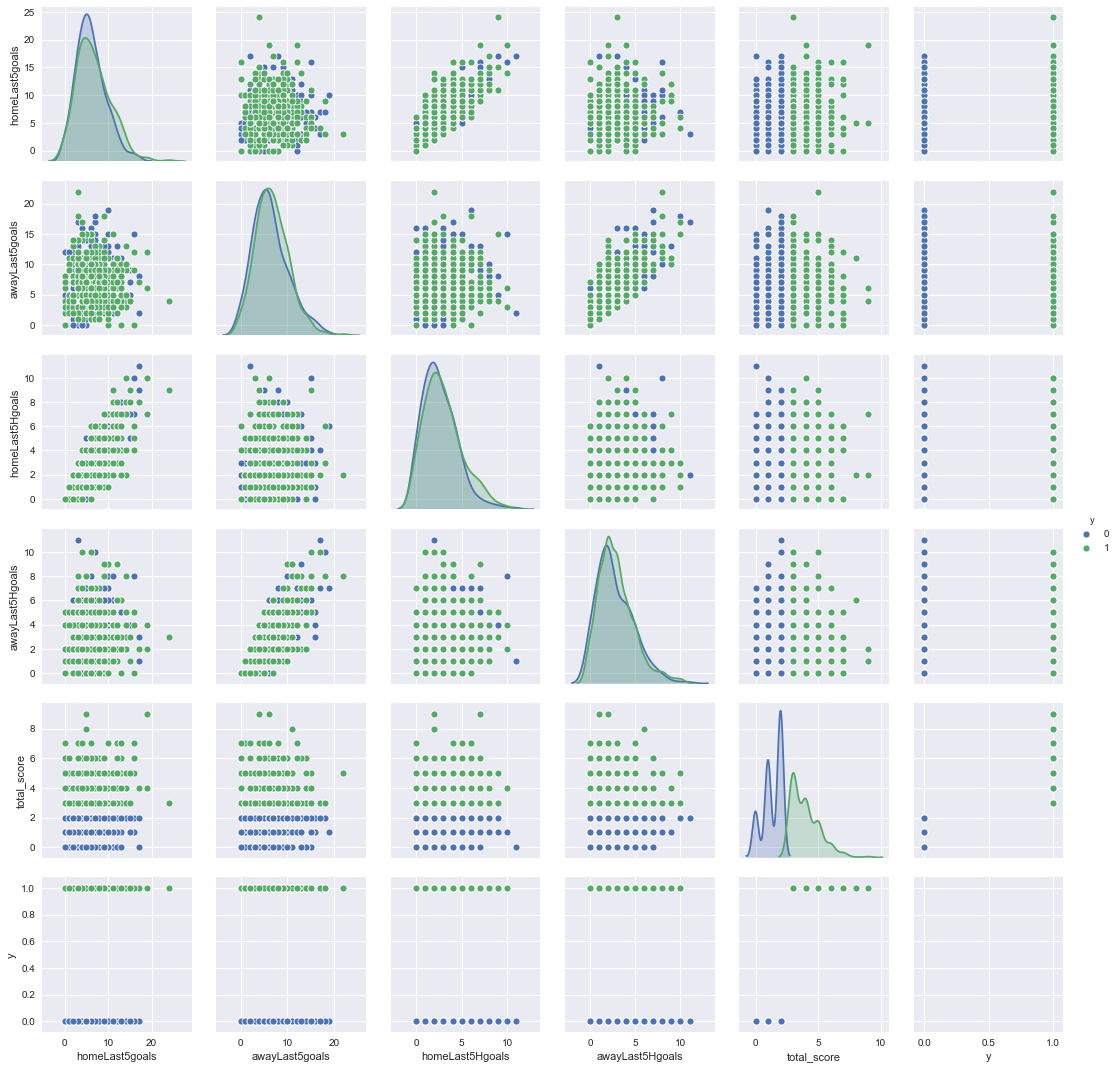

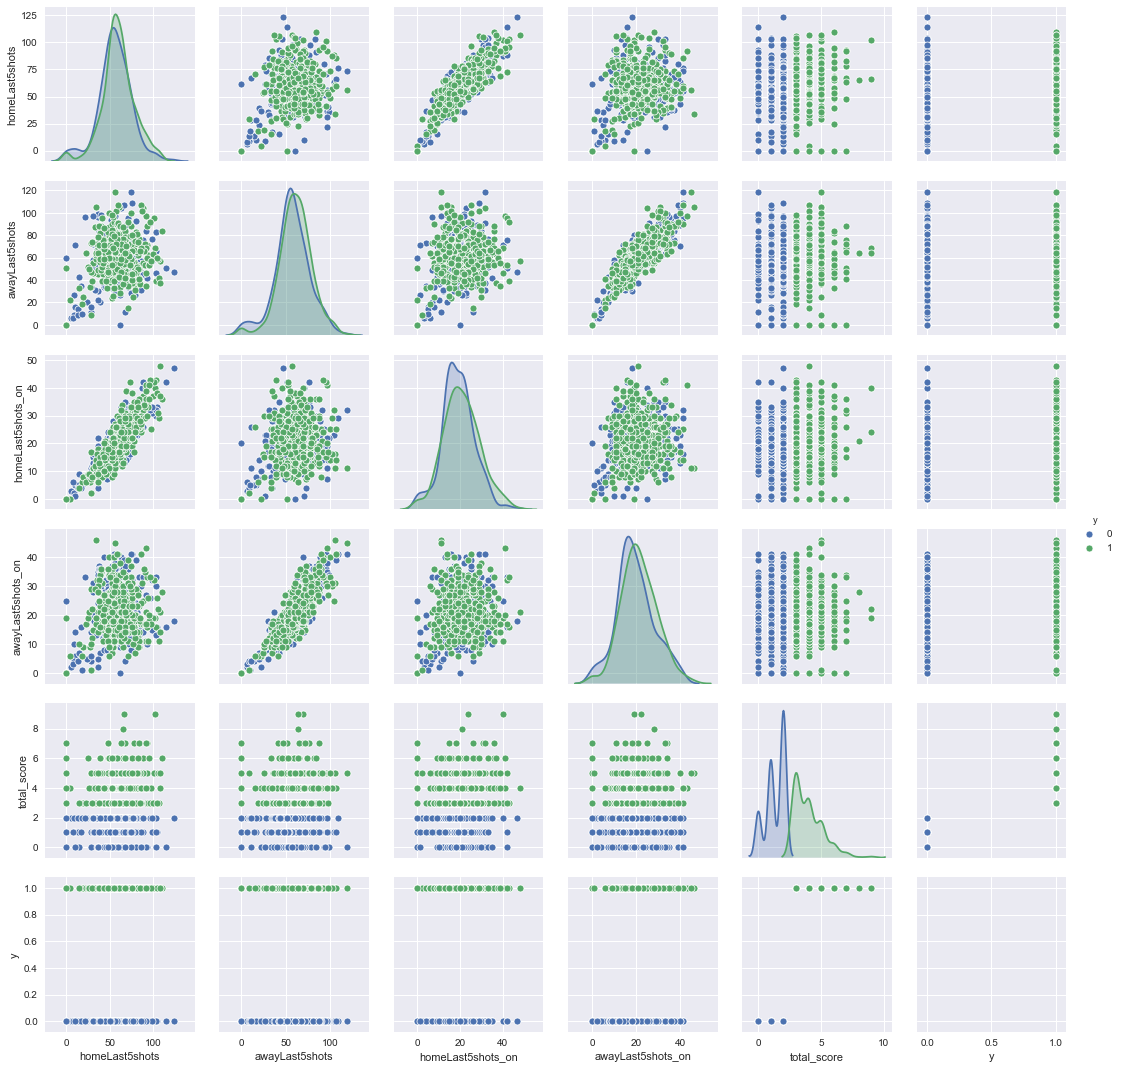

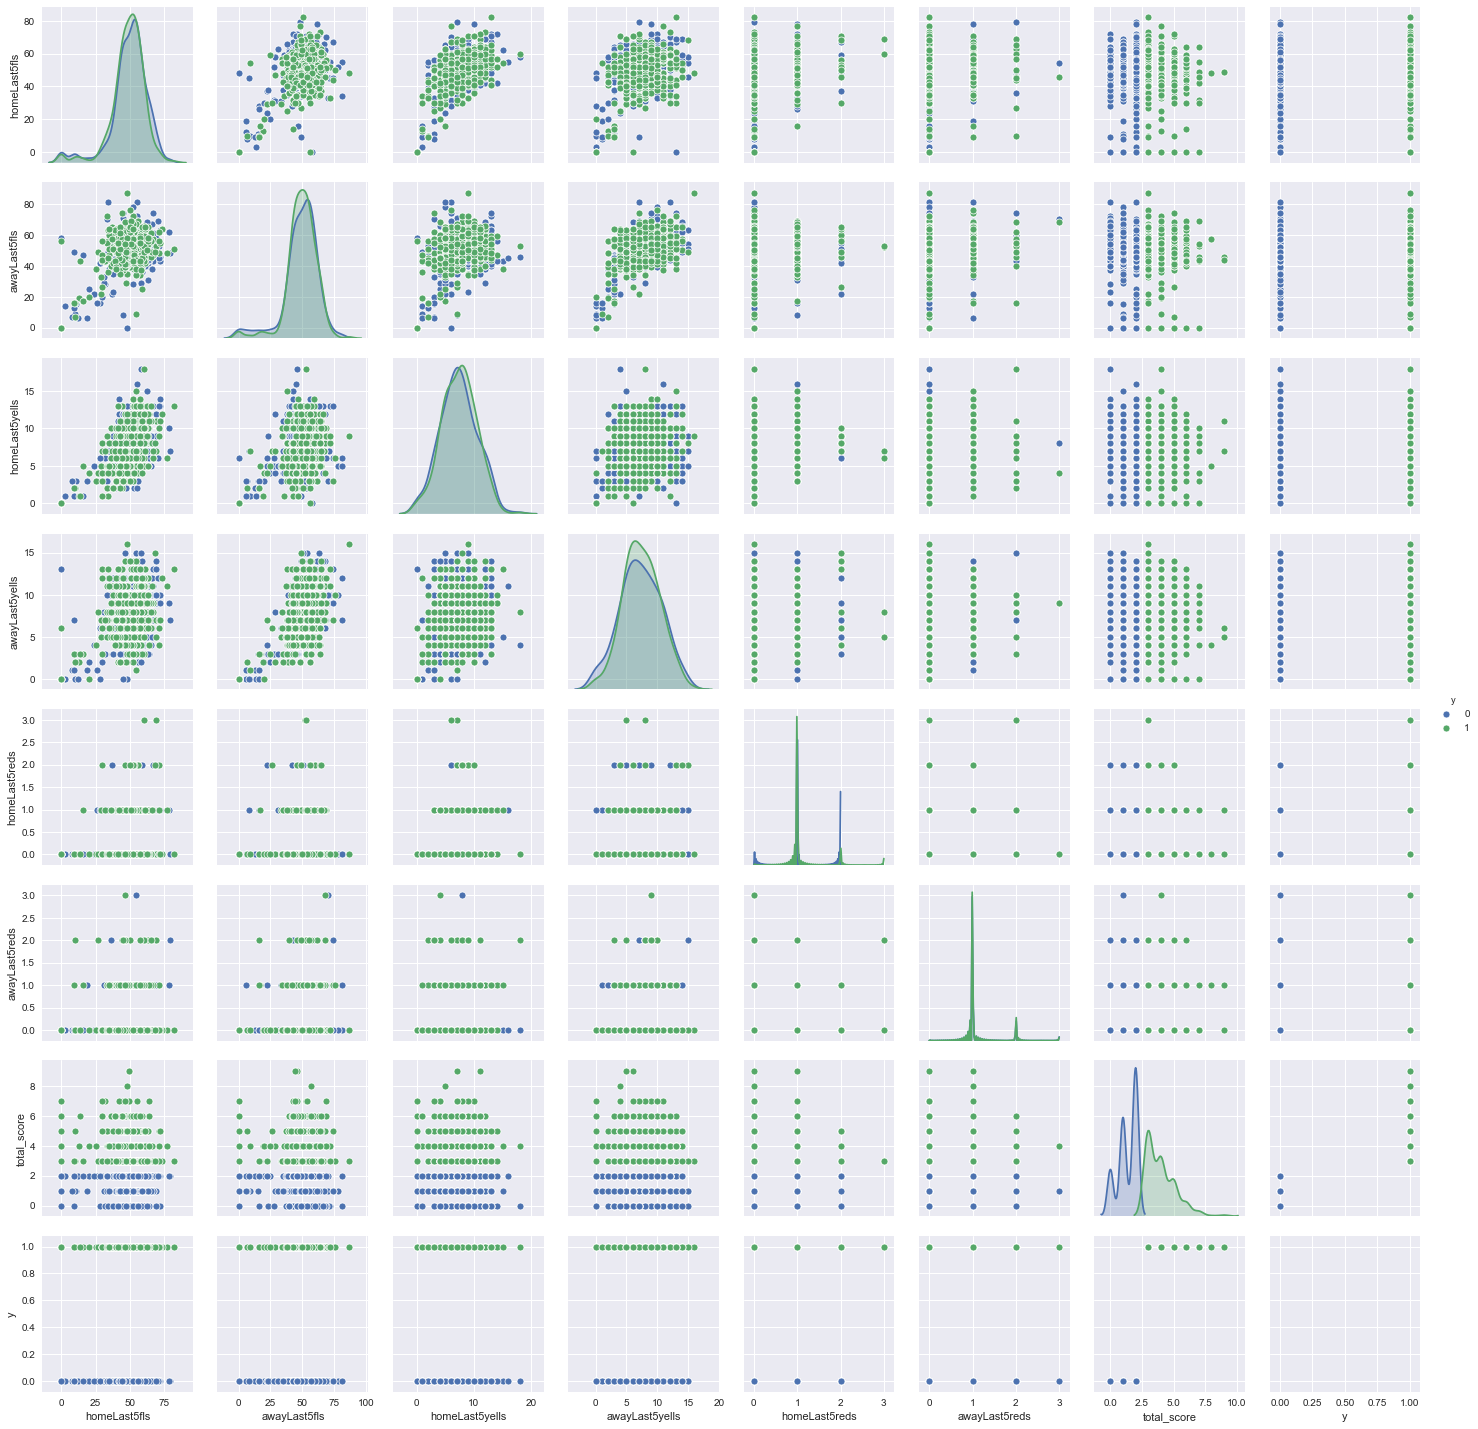

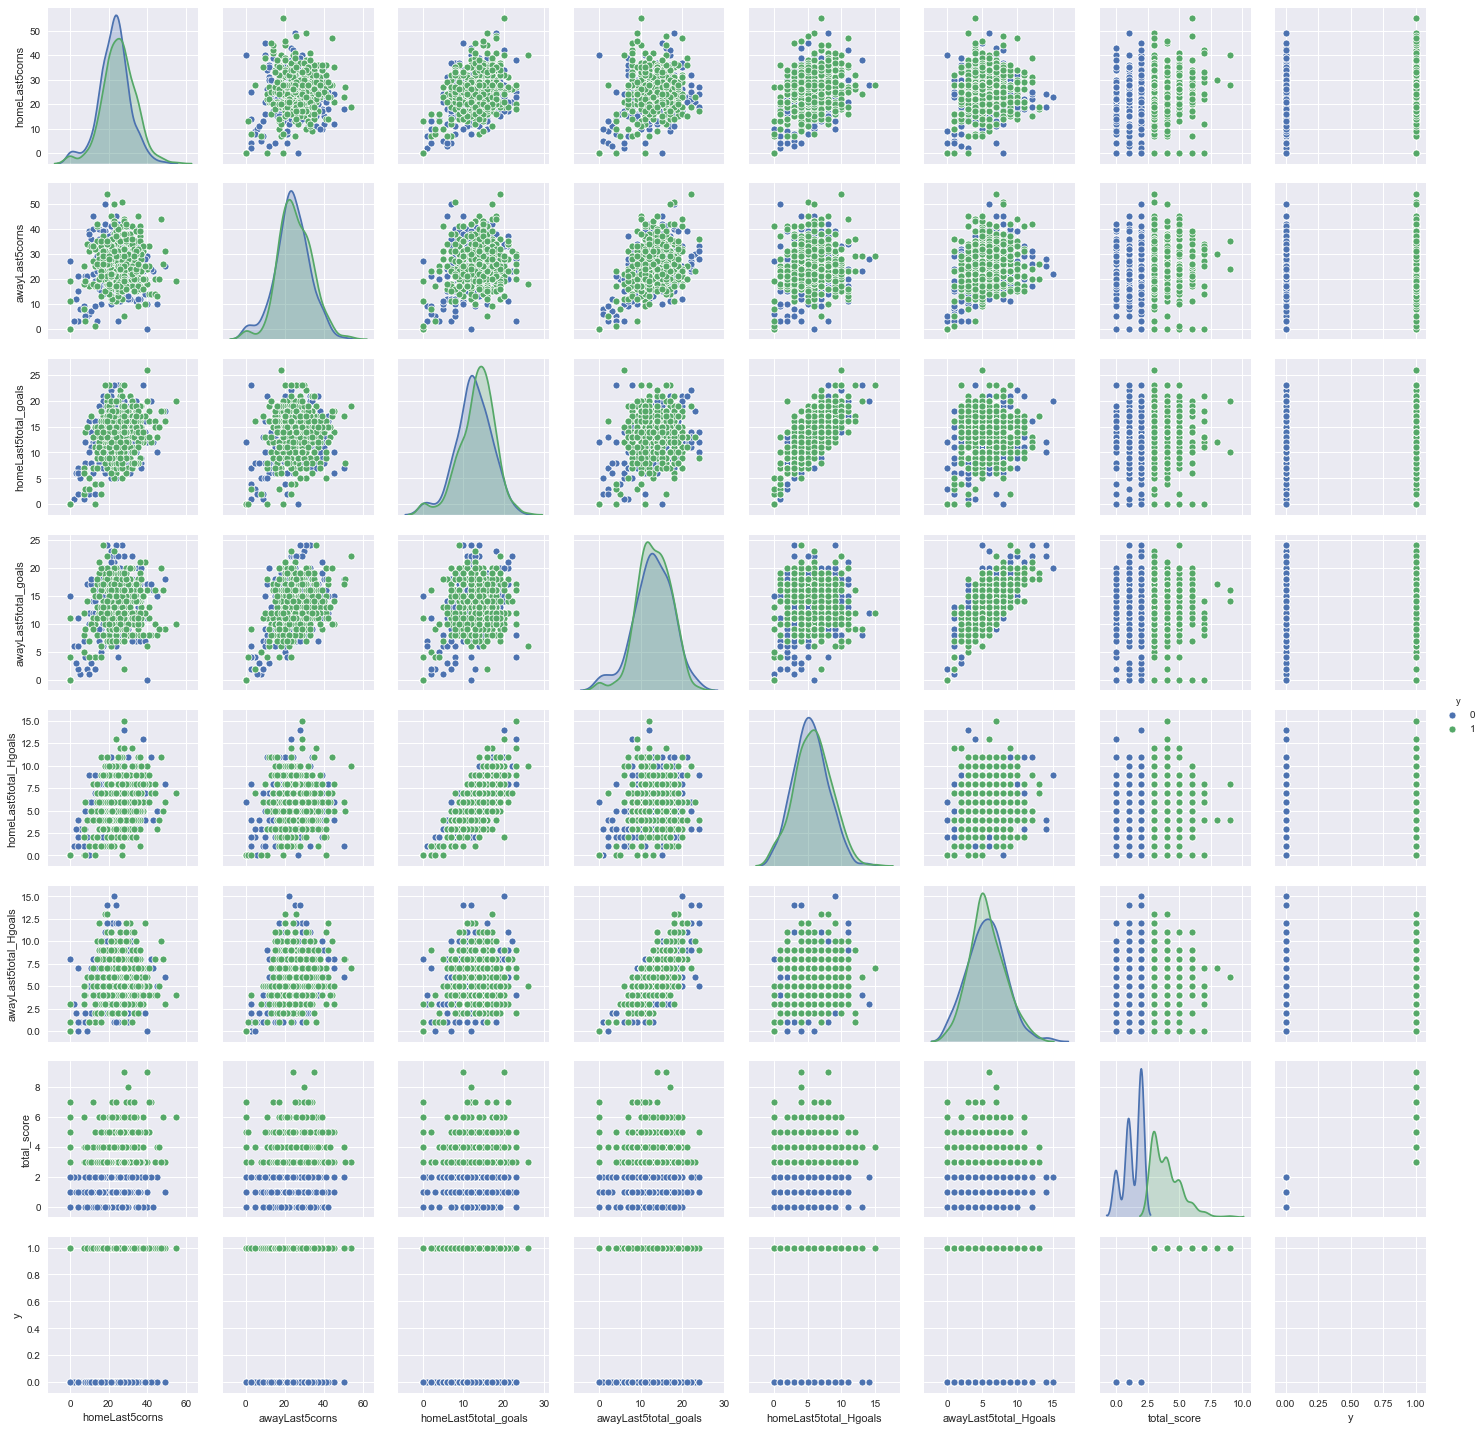

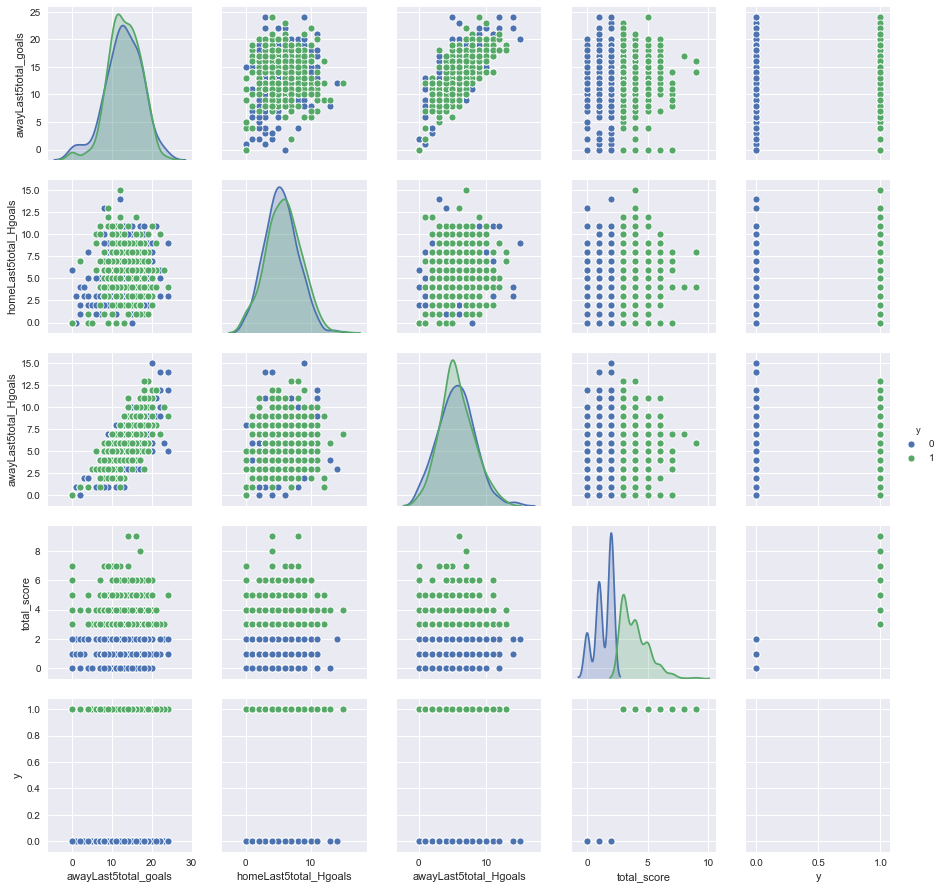

In [39]:
# last lets look at scatter plots of our new features and total score 
def crplt_func(input, df=df_final):
    """input: list"""
    for i in ['total_score', 'y']:
        input.append(i)
        
    pplot_df = df[input]    
    sns.pairplot(pplot_df, hue='y')
    
crplt_func(['homeLast5goals', 'awayLast5goals', 'homeLast5Hgoals', 
            'awayLast5Hgoals'])
crplt_func(['homeLast5shots', 'awayLast5shots', 
            'homeLast5shots_on', 'awayLast5shots_on'])
crplt_func(['homeLast5fls', 'awayLast5fls', 'homeLast5yells', 
            'awayLast5yells', 'homeLast5reds', 'awayLast5reds']) 
crplt_func(['homeLast5corns', 'awayLast5corns', 'homeLast5total_goals',
            'awayLast5total_goals', 'homeLast5total_Hgoals', 
            'awayLast5total_Hgoals'])
crplt_func(['awayLast5total_goals', 'homeLast5total_Hgoals', 
            'awayLast5total_Hgoals'])

<Figure size 1440x720 with 0 Axes>

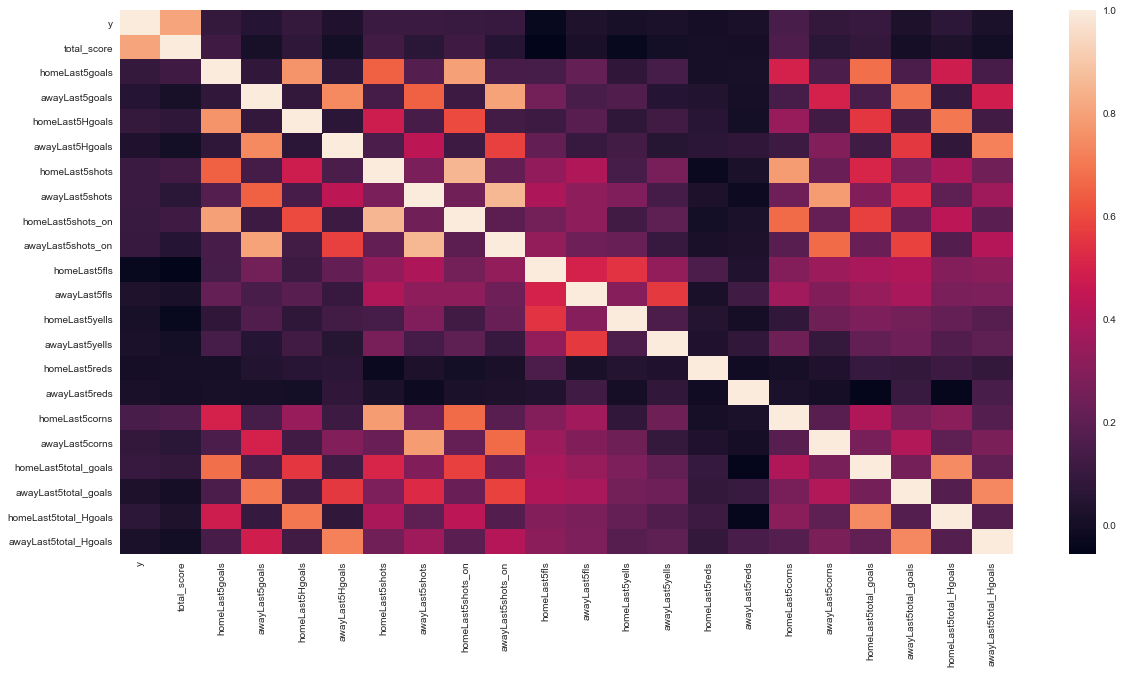

In [40]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_final.corr())
plt.show()

In [41]:
# filter above 5 gameweek so that we have enough data for last 5 fields
df_final = df_final[df_final.Date >= '2017-09-23'].reset_index(drop=True)
df_final.head()
df_final.tail()
df_final.info()

y        Date     HomeTeam        AwayTeam      Referee  total_score  \
0  0  2017-09-23      Burnley    Huddersfield   C Kavanagh            0   
1  1  2017-09-23      Everton     Bournemouth   M Atkinson            3   
2  1  2017-09-23    Leicester       Liverpool     A Taylor            5   
3  1  2017-09-23     Man City  Crystal Palace  N Swarbrick            5   
4  0  2017-09-23  Southampton      Man United     C Pawson            1   

   homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0             6.0             5.0              5.0              2.0   
1             2.0             3.0              2.0              1.0   
2             7.0             9.0              3.0              4.0   
3            16.0             0.0              6.0              0.0   
4             4.0            16.0              3.0              4.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0            52.0            56.0               14.0               20.0   
1            42.0            45.0               10.0               11.0   
2            49.0           100.0               14.0               40.0   
3            93.0            71.0               35.0               16.0   
4            71.0            95.0               15.0               36.0   

   homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  homeLast5reds  \
0          47.0          62.0             7.0             9.0            0.0   
1          57.0          35.0             9.0             8.0            1.0   
2          44.0          42.0             6.0             9.0            0.0   
3          46.0          57.0             9.0            14.0            2.0   
4          59.0          63.0             5.0             5.0            0.0   

   awayLast5reds  homeLast5corns  awayLast5corns  homeLast5total_goals  \
0            0.0            22.0            32.0                  11.0   
1            0.0            18.0            20.0                  12.0   
2            1.0            19.0            26.0                  16.0   
3            0.0            41.0            33.0                  18.0   
4            0.0            36.0            40.0                   8.0   

   awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  
0                   8.0                    6.0                    2.0  
1                  12.0                    7.0                    5.0  
2                  18.0                    6.0                    9.0  
3                   8.0                    8.0                    5.0  
4                  18.0                    5.0                    5.0

y        Date     HomeTeam      AwayTeam   Referee  total_score  \
629  1  2019-03-16      Burnley     Leicester  M Oliver            3   
630  1  2019-03-16  Bournemouth     Newcastle    M Dean            4   
631  1  2019-03-16     West Ham  Huddersfield    J Moss            7   
632  0  2019-03-17      Everton       Chelsea  A Taylor            2   
633  1  2019-03-17       Fulham     Liverpool  C Pawson            3   

     homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
629             8.0             8.0              2.0              2.0   
630             4.0             8.0              3.0              2.0   
631             6.0             2.0              5.0              0.0   
632             5.0            10.0              3.0              4.0   
633             3.0            12.0              2.0              6.0   

     homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
629            52.0            98.0               17.0               27.0   
630            43.0            86.0               15.0               27.0   
631            48.0            47.0               18.0               15.0   
632            39.0            88.0               15.0               25.0   
633            55.0            79.0               20.0               28.0   

     homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  \
629          40.0          38.0             6.0             5.0   
630          41.0          55.0            10.0            13.0   
631          46.0          54.0             7.0            10.0   
632          56.0          46.0             4.0             5.0   
633          62.0          50.0             9.0             9.0   

     homeLast5reds  awayLast5reds  homeLast5corns  awayLast5corns  \
629            0.0            0.0            28.0            32.0   
630            0.0            0.0            23.0            31.0   
631            0.0            1.0            24.0            17.0   
632            1.0            0.0            16.0            32.0   
633            0.0            0.0            19.0            35.0   

     homeLast5total_goals  awayLast5total_goals  homeLast5total_Hgoals  \
629                  19.0                  19.0                    7.0   
630                  14.0                  13.0                    7.0   
631                  11.0                   9.0                    7.0   
632                  11.0                  18.0                    4.0   
633                  16.0                  14.0                   11.0   

     awayLast5total_Hgoals  
629                    5.0  
630                    6.0  
631                    3.0  
632                    9.0  
633                    7.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 26 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
Referee                  object
total_score              int64
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(2), object(4)
memo

<Figure size 1440x720 with 0 Axes>

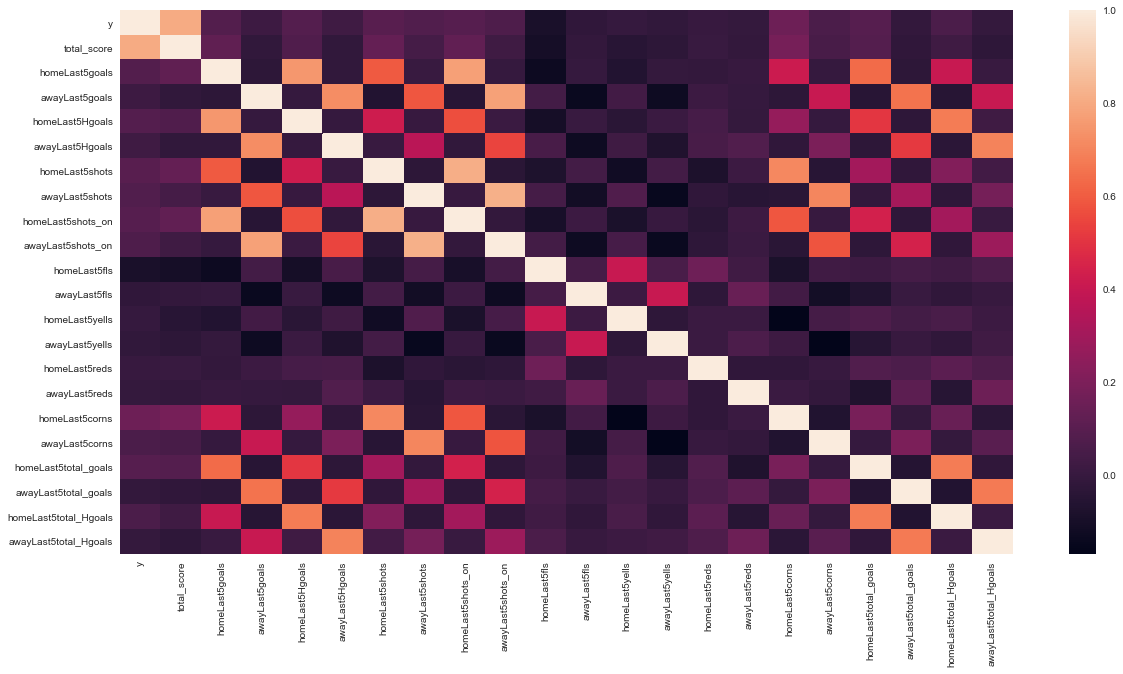

In [42]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_final.corr())
plt.show()

### notice that how the corr matrix got slight "better" for some 
### features after we removed the gameweek matches that didn't have 
### features regarding the last 5 weeks match statistics

# Modeling

In [43]:
# lets drop total score before moving on to model building 
df_final['label'] = df_final['y']
df_final = df_final.drop(columns=['total_score', 'y'])

# and get month to use in one hot encoding
# maybe fixture congested months like january
# can give insights into the number of potential
# goals a match will have
df_final['mon'] = pd.DatetimeIndex(df_final['Date']).month.astype(object)
df_final = df_final.drop(columns=['Date']) # then drop Date
df_final.head()
df_final.tail()
df_final.info(verbose=True, null_counts=True)

# lets check for label imbalance one last time
df_final.groupby('label')['HomeTeam'].count().divide(619)

HomeTeam        AwayTeam      Referee  homeLast5goals  awayLast5goals  \
0      Burnley    Huddersfield   C Kavanagh             6.0             5.0   
1      Everton     Bournemouth   M Atkinson             2.0             3.0   
2    Leicester       Liverpool     A Taylor             7.0             9.0   
3     Man City  Crystal Palace  N Swarbrick            16.0             0.0   
4  Southampton      Man United     C Pawson             4.0            16.0   

   homeLast5Hgoals  awayLast5Hgoals  homeLast5shots  awayLast5shots  \
0              5.0              2.0            52.0            56.0   
1              2.0              1.0            42.0            45.0   
2              3.0              4.0            49.0           100.0   
3              6.0              0.0            93.0            71.0   
4              3.0              4.0            71.0            95.0   

   homeLast5shots_on  awayLast5shots_on  homeLast5fls  awayLast5fls  \
0               14.0               20.0          47.0          62.0   
1               10.0               11.0          57.0          35.0   
2               14.0               40.0          44.0          42.0   
3               35.0               16.0          46.0          57.0   
4               15.0               36.0          59.0          63.0   

   homeLast5yells  awayLast5yells  homeLast5reds  awayLast5reds  \
0             7.0             9.0            0.0            0.0   
1             9.0             8.0            1.0            0.0   
2             6.0             9.0            0.0            1.0   
3             9.0            14.0            2.0            0.0   
4             5.0             5.0            0.0            0.0   

   homeLast5corns  awayLast5corns  homeLast5total_goals  awayLast5total_goals  \
0            22.0            32.0                  11.0                   8.0   
1            18.0            20.0                  12.0                  12.0   
2            19.0            26.0                  16.0                  18.0   
3            41.0            33.0                  18.0                   8.0   
4            36.0            40.0                   8.0                  18.0   

   homeLast5total_Hgoals  awayLast5total_Hgoals  label mon  
0                    6.0                    2.0      0   9  
1                    7.0                    5.0      1   9  
2                    6.0                    9.0      1   9  
3                    8.0                    5.0      1   9  
4                    5.0                    5.0      0   9

HomeTeam      AwayTeam   Referee  homeLast5goals  awayLast5goals  \
629      Burnley     Leicester  M Oliver             8.0             8.0   
630  Bournemouth     Newcastle    M Dean             4.0             8.0   
631     West Ham  Huddersfield    J Moss             6.0             2.0   
632      Everton       Chelsea  A Taylor             5.0            10.0   
633       Fulham     Liverpool  C Pawson             3.0            12.0   

     homeLast5Hgoals  awayLast5Hgoals  homeLast5shots  awayLast5shots  \
629              2.0              2.0            52.0            98.0   
630              3.0              2.0            43.0            86.0   
631              5.0              0.0            48.0            47.0   
632              3.0              4.0            39.0            88.0   
633              2.0              6.0            55.0            79.0   

     homeLast5shots_on  awayLast5shots_on  homeLast5fls  awayLast5fls  \
629               17.0               27.0          40.0          38.0   
630               15.0               27.0          41.0          55.0   
631               18.0               15.0          46.0          54.0   
632               15.0               25.0          56.0          46.0   
633               20.0               28.0          62.0          50.0   

     homeLast5yells  awayLast5yells  homeLast5reds  awayLast5reds  \
629             6.0             5.0            0.0            0.0   
630            10.0            13.0            0.0            0.0   
631             7.0            10.0            0.0            1.0   
632             4.0             5.0            1.0            0.0   
633             9.0             9.0            0.0            0.0   

     homeLast5corns  awayLast5corns  homeLast5total_goals  \
629            28.0            32.0                  19.0   
630            23.0            31.0                  14.0   
631            24.0            17.0                  11.0   
632            16.0            32.0                  11.0   
633            19.0            35.0                  16.0   

     awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  \
629                  19.0                    7.0                    5.0   
630                  13.0                    7.0                    6.0   
631                   9.0                    7.0                    3.0   
632                  18.0                    4.0                    9.0   
633                  14.0                   11.0                    7.0   

     label mon  
629      1   3  
630      1   3  
631      1   3  
632      0   3  
633      1   3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 25 columns):
HomeTeam                 634 non-null object
AwayTeam                 634 non-null object
Referee                  634 non-null object
homeLast5goals           634 non-null float64
awayLast5goals           634 non-null float64
homeLast5Hgoals          634 non-null float64
awayLast5Hgoals          634 non-null float64
homeLast5shots           634 non-null float64
awayLast5shots           634 non-null float64
homeLast5shots_on        634 non-null float64
awayLast5shots_on        634 non-null float64
homeLast5fls             634 non-null float64
awayLast5fls             634 non-null float64
homeLast5yells           634 non-null float64
awayLast5yells           634 non-null float64
homeLast5reds            634 non-null float64
awayLast5reds            634 non-null float64
homeLast5corns           634 non-null float64
awayLast5corns           634 non-null float64
homeLast5total_goals    

label
0    0.471729
1    0.552504
Name: HomeTeam, dtype: float64

In [44]:
# create dataframe for PySpark model
sp_final = spark.createDataFrame(df_final)

In [45]:
sp_final.show(5)
sp_final.schema

+-----------+--------------+-----------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+
|   HomeTeam|      AwayTeam|    Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|
+-----------+--------------+-----------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+----

StructType(List(StructField(HomeTeam,StringType,true),StructField(AwayTeam,StringType,true),StructField(Referee,StringType,true),StructField(homeLast5goals,DoubleType,true),StructField(awayLast5goals,DoubleType,true),StructField(homeLast5Hgoals,DoubleType,true),StructField(awayLast5Hgoals,DoubleType,true),StructField(homeLast5shots,DoubleType,true),StructField(awayLast5shots,DoubleType,true),StructField(homeLast5shots_on,DoubleType,true),StructField(awayLast5shots_on,DoubleType,true),StructField(homeLast5fls,DoubleType,true),StructField(awayLast5fls,DoubleType,true),StructField(homeLast5yells,DoubleType,true),StructField(awayLast5yells,DoubleType,true),StructField(homeLast5reds,DoubleType,true),StructField(awayLast5reds,DoubleType,true),StructField(homeLast5corns,DoubleType,true),StructField(awayLast5corns,DoubleType,true),StructField(homeLast5total_goals,DoubleType,true),StructField(awayLast5total_goals,DoubleType,true),StructField(homeLast5total_Hgoals,DoubleType,true),StructField(aw

In [51]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# lets first create pipeline to transform the categorical
# and numerical columns for logistic regression

categoricalColumns = ['HomeTeam', 'AwayTeam', 'Referee', 'mon']
cat_stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "catVec"])
    cat_stages += [stringIndexer, encoder]
    
    
assemblerInputs = [c + "catVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
cat_stages += [assembler] 

# create cat pipeline
pipelineCat = Pipeline(stages=cat_stages)     
    
numericCols = ['homeLast5goals', 'awayLast5goals', 
               'homeLast5Hgoals', 'awayLast5Hgoals',
               'homeLast5shots', 'awayLast5shots', 
               'homeLast5shots_on', 'awayLast5shots_on',
               'homeLast5fls', 'awayLast5fls', 
               'homeLast5yells', 'awayLast5yells',
               'homeLast5reds', 'awayLast5reds',
               'homeLast5corns', 'awayLast5corns',
               'homeLast5total_goals', 'awayLast5total_goals',
               'homeLast5total_Hgoals', 'awayLast5total_Hgoals'] 

assemblerNum = VectorAssembler(inputCols=numericCols, outputCol="featuresNum0")
standardScalerNum = StandardScaler(inputCol="featuresNum0", outputCol="featuresNum")
   
# create numeric feature pipeline
pipelineNum = Pipeline(stages=[assemblerNum, standardScalerNum])

pipeline = Pipeline(stages=[pipelineCat,pipelineNum,
                            VectorAssembler(inputCols=["featuresCat", "featuresNum"], 
                                        outputCol="features")])
pipedData = pipeline.fit(sp_final).transform(sp_final)

trainData, testData = pipedData.randomSplit([0.8, 0.2], seed=12345)

lr = LogisticRegression()

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, np.arange(0, 1, .1)) \
    .addGrid(lr.elasticNetParam, np.arange(0, 1, .1)) \
    .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # don't have much data yet

cvModel = crossval.fit(trainData)


# cross_val = StratifiedCrossValidator(estimator=pipeline,
#                                     estimatorParamMaps=paramGrid,
#                                     evaluator=BinaryClassificationEvaluator(),
#                                     numFolds=5) 

In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

trainingSummary = cvModel.bestModel.summary

predictions = cvModel.transform(testData)
predictions.show(1)
type(predictions)
predictions.select(predictions.probability).show(1)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + \
      str(evaluator.evaluate(predictions, 
                             {evaluator.metricName: "areaUnderROC"})))

+--------+---------+---------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+-------------+--------------+-------------+--------------+------------+---------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|HomeTeam| AwayTeam|  Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|HomeTeamIndex|Ho

pyspark.sql.dataframe.DataFrame

+--------------------+
|         probability|
+--------------------+
|[0.49527095216202...|
+--------------------+
only showing top 1 row

Test Area Under ROC: 0.5128676470588235


Text(0, 0.5, 'False Positive Rate')

Text(0.5, 0, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

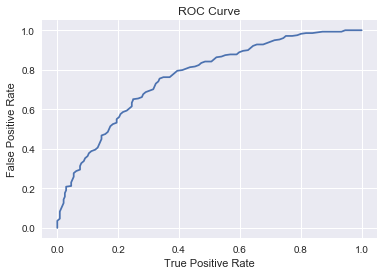

Training set areaUnderROC: 0.7626347055135976


In [53]:
# lets plot the ROC Curve
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'Recall')

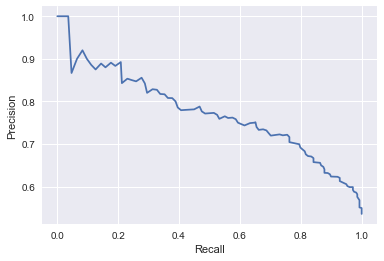

In [54]:
# lets plot the Precision-Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [56]:
# save logistic regression model code:
cvModel.save('bestLogmodel')
type(cvModel)

pyspark.ml.tuning.CrossValidatorModel

### you can see that the training set AUC was better than the test set - it seems it does not generalize on new data well. So far the logistic model is not very good and is only a bit better than a random choice guess.  This is most likely related to three things: 1) the amount of data we have is small ; 2) our features we created for predictive power only include historical offense metrics; they do not include, for example, how many goals a particular team has been SCORED ON the past 5 games; and 3) our dataset does not include features like which players are playing or other tournament games in between Premier League games like Champions League or FA Cup fames.  However, the purpose this full stack data science project is to exhibit all aspects of data science/engineering stack.  So far we have accomplished data transformation and manipulation, as well as machine learning.  We have utilized python, Pandas, Spark SQL, and Spark MLlib.  Next we will try out a gradient boosted tree to see if we can improve on the model's binary classification performance.  Then we will save the best model and serve as an API in a Flask API and app.

### Also, as a note, I had to split the model training part away from the pipeline of feature transformations since some of the dummies won't be included if I split the training and test set first since regelegation and promotion teams are only in parts half of the dataset.  I was having issues training the pipeline model when the model was included in the pipeline. 

In [55]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# lets first create pipeline to transform the categorical
# and numerical columns for logistic regression

categoricalColumns = ['HomeTeam', 'AwayTeam', 'Referee', 'mon']
cat_stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "catVec"])
    cat_stages += [stringIndexer, encoder]
    
    
assemblerInputs = [c + "catVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
cat_stages += [assembler] 

# create cat pipeline
pipelineCat = Pipeline(stages=cat_stages)     
    
numericCols = ['homeLast5goals', 'awayLast5goals', 
               'homeLast5Hgoals', 'awayLast5Hgoals',
               'homeLast5shots', 'awayLast5shots', 
               'homeLast5shots_on', 'awayLast5shots_on',
               'homeLast5fls', 'awayLast5fls', 
               'homeLast5yells', 'awayLast5yells',
               'homeLast5reds', 'awayLast5reds',
               'homeLast5corns', 'awayLast5corns',
               'homeLast5total_goals', 'awayLast5total_goals',
               'homeLast5total_Hgoals', 'awayLast5total_Hgoals'] 

assemblerNum = VectorAssembler(inputCols=numericCols, outputCol="featuresNum")

pipeline = Pipeline(stages=[pipelineCat,assemblerNum,
                            VectorAssembler(inputCols=["featuresCat", "featuresNum"], 
                                        outputCol="features")])
pipedData = pipeline.fit(sp_final).transform(sp_final)

trainData, testData = pipedData.randomSplit([0.75, 0.25], seed=12345)

gbtc = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.subsamplingRate, np.arange(0.1, 1.0, .1)) \
    .addGrid(gbtc.maxDepth, [1, 2, 4, 6, 8, 10, 12, 14, 16]) \
    .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

crossval = CrossValidator(estimator=gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # don't have much data yet

cvModel = crossval.fit(trainData)


# cross_val = StratifiedCrossValidator(estimator=pipeline,
#                                     estimatorParamMaps=paramGrid,
#                                     evaluator=BinaryClassificationEvaluator(),
#                                     numFolds=5) 

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = cvModel.transform(testData)
predictions.show(1)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + \
      str(evaluator.evaluate(predictions, 
                             {evaluator.metricName: "areaUnderROC"})))
print("numNodes = ", cvModel.bestModel.totalNumNodes)
print("numTrees = ", cvModel.bestModel.getNumTrees)

+--------+---------+---------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+-------------+--------------+-------------+--------------+------------+---------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|HomeTeam| AwayTeam|  Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|HomeTeamIndex|HomeTeamcatVec|AwayTeam

In [57]:
model = pd.DataFrame(cvModel.bestModel.featureImportances.toArray(), columns=["values"])
model
pandasDF = pd.DataFrame(predictions.schema["features"].metadata["ml_attr"] 
                        ["attrs"]["binary"]+predictions.schema["features"] \
                        .metadata["ml_attr"]["attrs"]["numeric"]) \
                        .sort_values("idx")
feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 
feature_dict
features_col = pd.Series(feature_dict)
model["features"] = features_col
model = model.sort_values(by=['values'], ascending=False).reset_index(drop=True)
model
model['features'] = model['features'].astype(str)
model.info()

values
0   0.000000
1   0.011006
2   0.007744
3   0.000005
4   0.000000
5   0.028923
6   0.022310
7   0.000000
8   0.000000
9   0.000000
10  0.000000
11  0.000024
12  0.000000
13  0.000000
14  0.000000
15  0.000000
16  0.000000
17  0.000000
18  0.001257
19  0.000000
20  0.022858
21  0.000000
22  0.000000
23  0.026645
24  0.000000
25  0.000000
26  0.000000
27  0.030072
28  0.000000
29  0.000000
..       ...
63  0.000000
64  0.000000
65  0.000000
66  0.000000
67  0.000000
68  0.025153
69  0.000000
70  0.000000
71  0.000000
72  0.000000
73  0.001680
74  0.064275
75  0.018265
76  0.001099
77  0.069469
78  0.025020
79  0.000000
80  0.059154
81  0.086786
82  0.055202
83  0.026846
84  0.020628
85  0.000000
86  0.000000
87  0.112259
88  0.041760
89  0.065538
90  0.046434
91  0.050192
92  0.000000

[93 rows x 1 columns]

{0: 'featuresCat_HomeTeamcatVec_West Ham',
 1: 'featuresCat_HomeTeamcatVec_Arsenal',
 2: 'featuresCat_HomeTeamcatVec_Man City',
 3: 'featuresCat_HomeTeamcatVec_Everton',
 4: 'featuresCat_HomeTeamcatVec_Bournemouth',
 5: 'featuresCat_HomeTeamcatVec_Huddersfield',
 6: 'featuresCat_HomeTeamcatVec_Newcastle',
 7: 'featuresCat_HomeTeamcatVec_Leicester',
 8: 'featuresCat_HomeTeamcatVec_Burnley',
 9: 'featuresCat_HomeTeamcatVec_Crystal Palace',
 10: 'featuresCat_HomeTeamcatVec_Southampton',
 11: 'featuresCat_HomeTeamcatVec_Chelsea',
 12: 'featuresCat_HomeTeamcatVec_Liverpool',
 13: 'featuresCat_HomeTeamcatVec_Brighton',
 14: 'featuresCat_HomeTeamcatVec_Tottenham',
 15: 'featuresCat_HomeTeamcatVec_Watford',
 16: 'featuresCat_HomeTeamcatVec_Man United',
 17: 'featuresCat_HomeTeamcatVec_Swansea',
 18: 'featuresCat_HomeTeamcatVec_Stoke',
 19: 'featuresCat_HomeTeamcatVec_West Brom',
 20: 'featuresCat_HomeTeamcatVec_Cardiff',
 21: 'featuresCat_HomeTeamcatVec_Fulham',
 22: 'featuresCat_AwayTeamcatVe

values                                   features
0   0.112259                 featuresNum_homeLast5corns
1   0.086786                   featuresNum_homeLast5fls
2   0.069469                 featuresNum_homeLast5shots
3   0.065538           featuresNum_homeLast5total_goals
4   0.064275                 featuresNum_awayLast5goals
5   0.059154              featuresNum_awayLast5shots_on
6   0.055202                   featuresNum_awayLast5fls
7   0.050192          featuresNum_homeLast5total_Hgoals
8   0.046434           featuresNum_awayLast5total_goals
9   0.041760                 featuresNum_awayLast5corns
10  0.030072     featuresCat_AwayTeamcatVec_Southampton
11  0.029180        featuresCat_RefereecatVec_P Tierney
12  0.028923    featuresCat_HomeTeamcatVec_Huddersfield
13  0.026901        featuresCat_AwayTeamcatVec_West Ham
14  0.026846                 featuresNum_homeLast5yells
15  0.026645         featuresCat_AwayTeamcatVec_Watford
16  0.025153                   featuresCat_moncatVec_10
17  0.025020                 featuresNum_awayLast5shots
18  0.022880         featuresCat_RefereecatVec_M Oliver
19  0.022858         featuresCat_HomeTeamcatVec_Cardiff
20  0.022310       featuresCat_HomeTeamcatVec_Newcastle
21  0.020628                 featuresNum_awayLast5yells
22  0.018265                featuresNum_homeLast5Hgoals
23  0.011006         featuresCat_HomeTeamcatVec_Arsenal
24  0.007744        featuresCat_HomeTeamcatVec_Man City
25  0.001680                 featuresNum_homeLast5goals
26  0.001257           featuresCat_HomeTeamcatVec_Stoke
27  0.001099                featuresNum_awayLast5Hgoals
28  0.000435         featuresCat_AwayTeamcatVec_Chelsea
29  0.000024         featuresCat_HomeTeamcatVec_Chelsea
..       ...                                        ...
63  0.000000       featuresCat_HomeTeamcatVec_Tottenham
64  0.000000     featuresCat_AwayTeamcatVec_Bournemouth
65  0.000000        featuresCat_HomeTeamcatVec_Brighton
66  0.000000       featuresCat_HomeTeamcatVec_Liverpool
67  0.000000     featuresCat_HomeTeamcatVec_Southampton
68  0.000000  featuresCat_HomeTeamcatVec_Crystal Palace
69  0.000000         featuresCat_HomeTeamcatVec_Burnley
70  0.000000       featuresCat_HomeTeamcatVec_Leicester
71  0.000000     featuresCat_HomeTeamcatVec_Bournemouth
72  0.000000  featuresCat_AwayTeamcatVec_Crystal Palace
73  0.000000    featuresCat_AwayTeamcatVec_Huddersfield
74  0.000000         featuresCat_RefereecatVec_K Friend
75  0.000000           featuresCat_AwayTeamcatVec_Stoke
76  0.000000         featuresCat_RefereecatVec_C Pawson
77  0.000000           featuresCat_RefereecatVec_M Dean
78  0.000000       featuresCat_RefereecatVec_A Marriner
79  0.000000           featuresCat_RefereecatVec_J Moss
80  0.000000         featuresCat_RefereecatVec_A Taylor
81  0.000000          featuresCat_AwayTeamcatVec_Wolves
82  0.000000          featuresCat_AwayTeamcatVec_Fulham
83  0.000000         featuresCat_AwayTeamcatVec_Swansea
84  0.000000       featuresCat_AwayTeamcatVec_Newcastle
85  0.000000       featuresCat_AwayTeamcatVec_West Brom
86  0.000000        featuresCat_AwayTeamcatVec_Man City
87  0.000000         featuresCat_AwayTeamcatVec_Arsenal
88  0.000000        featuresCat_AwayTeamcatVec_Brighton
89  0.000000         featuresCat_AwayTeamcatVec_Everton
90  0.000000         featuresCat_AwayTeamcatVec_Burnley
91  0.000000       featuresCat_AwayTeamcatVec_Leicester
92  0.000000          featuresNum_awayLast5total_Hgoals

[93 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 2 columns):
values      93 non-null float64
features    93 non-null object
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [47]:
# create dataframe for PySpark model
sp_testdd = spark.createDataFrame(df_final[['HomeTeam', 
                                            'AwayTeam',
                                            'homeLast5goals', 
                                            'awayLast5goals',
                                            'homeLast5shots', 
                                            'awayLast5shots', 
                                            'homeLast5shots_on', 
                                            'awayLast5shots_on',
                                            'homeLast5corns', 
                                            'awayLast5corns',
                                            'label']])
sp_testdd.show()

+------------+--------------+--------------+--------------+--------------+--------------+-----------------+-----------------+--------------+--------------+-----+
|    HomeTeam|      AwayTeam|homeLast5goals|awayLast5goals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5corns|awayLast5corns|label|
+------------+--------------+--------------+--------------+--------------+--------------+-----------------+-----------------+--------------+--------------+-----+
|     Burnley|  Huddersfield|           6.0|           5.0|          52.0|          56.0|             14.0|             20.0|          22.0|          32.0|    0|
|     Everton|   Bournemouth|           2.0|           3.0|          42.0|          45.0|             10.0|             11.0|          18.0|          20.0|    1|
|   Leicester|     Liverpool|           7.0|           9.0|          49.0|         100.0|             14.0|             40.0|          19.0|          26.0|    1|
|    Man City|Crystal Palace

In [51]:
# lets train a LogisticRegression on only HomeTeam, AwayTeam,
# homeLast5goals, and awayLast5goals
# to simplify the model api so as to not overcomplicate
# how we show how to implement the model as an Flask API
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

trainData, testData = sp_testdd.randomSplit([0.75, 0.25], seed=12345)

# lets first create pipeline to transform the categorical
# and numerical columns for logistic regression

categoricalColumns = ['HomeTeam', 'AwayTeam']
cat_stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, 
                                  outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                     outputCols=[categoricalCol + "catVec"])
    cat_stages += [stringIndexer, encoder]
    
    
assemblerInputs = [c + "catVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
cat_stages += [assembler] 

# create cat pipeline
pipelineCat = Pipeline(stages=cat_stages)     
    
numericCols = ['homeLast5goals', 'awayLast5goals',
               'homeLast5shots_on', 'awayLast5shots_on'] 

assemblerNum = VectorAssembler(inputCols=numericCols, 
                               outputCol="featuresNum0")
standardScalerNum = StandardScaler(inputCol="featuresNum0", 
                                   outputCol="featuresNum")
   
# create numeric feature pipeline
pipelineNum = Pipeline(stages=[assemblerNum, standardScalerNum])

lr = LogisticRegression()

pipeline = Pipeline(stages=[pipelineCat,pipelineNum,
                            VectorAssembler(inputCols=["featuresCat", "featuresNum"], 
                                            outputCol="features"),
                            lr])

#pipedData = pipeline.fit(sp_testdd).transform(sp_testdd)

#trainData, testData = pipedData.randomSplit([0.8, 0.2], seed=12345)

#lr = LogisticRegression()

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, np.arange(0, 1, .1)) \
    .addGrid(lr.elasticNetParam, np.arange(0, 1, .1)) \
    .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3) # don't have much data yet

cvModel = crossval.fit(trainData)

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

bestPipeline = cvModel.bestModel
bestLRModel = bestPipeline.stages[-1]

trainingSummary = bestLRModel.summary

predictions = cvModel.transform(testData)
predictions.show(1)
type(predictions)
predictions.select(predictions.probability).show(1)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + \
      str(evaluator.evaluate(predictions, 
                             {evaluator.metricName: "areaUnderROC"})))

+--------+---------+--------------+--------------+--------------+--------------+-----------------+-----------------+--------------+--------------+-----+-------------+--------------+-------------+---------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------+
|HomeTeam| AwayTeam|homeLast5goals|awayLast5goals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5corns|awayLast5corns|label|HomeTeamIndex|HomeTeamcatVec|AwayTeamIndex| AwayTeamcatVec|         featuresCat|       featuresNum0|         featuresNum|            features|       rawPrediction|         probability|prediction|
+--------+---------+--------------+--------------+--------------+--------------+-----------------+-----------------+--------------+--------------+-----+-------------+--------------+-------------+---------------+--------------------+-------------------+--------------------+--------------------+----------

pyspark.sql.dataframe.DataFrame

+--------------------+
|         probability|
+--------------------+
|[0.48623199034491...|
+--------------------+
only showing top 1 row

Test Area Under ROC: 0.5360700790106493


In [66]:
# test our model on some predictions we create
dataTest2 = pd.read_json('dataTest.json', orient='columns')
dataTest2.head()

df_testdd = spark.createDataFrame(dataTest2)
df_testdd.show()

predictions_test = bestPipeline.transform(df_testdd)
predictions_test.show()
predictions_test.select(predictions_test.probability).show(2, False)
predictions_test.select(predictions_test.prediction).show(2)

AwayTeam  HomeTeam  awayLast5goals  awayLast5shots_on  homeLast5goals  \
0  Huddersfield   Burnley               2                 10               5   
1        Wolves  Man City              10                 25              10   

   homeLast5shots_on  
0                 10  
1                 30

+------------+--------+--------------+-----------------+--------------+-----------------+
|    AwayTeam|HomeTeam|awayLast5goals|awayLast5shots_on|homeLast5goals|homeLast5shots_on|
+------------+--------+--------------+-----------------+--------------+-----------------+
|Huddersfield| Burnley|             2|               10|             5|               10|
|      Wolves|Man City|            10|               25|            10|               30|
+------------+--------+--------------+-----------------+--------------+-----------------+

+------------+--------+--------------+-----------------+--------------+-----------------+-------------+--------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    AwayTeam|HomeTeam|awayLast5goals|awayLast5shots_on|homeLast5goals|homeLast5shots_on|HomeTeamIndex|HomeTeamcatVec|AwayTeamIndex| AwayTeamcatVec|         featuresCat|    

In [67]:
# save new logistic regression model as:
cvModel.bestModel.write().overwrite().save('bestPipeLogReg')

AttributeError: 'Pipeline' object has no attribute '_transfer_param_map_to_java'

In [48]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

trainData, testData = sp_testdd.randomSplit([0.8, 0.2], seed=12345)

# lets first create pipeline to transform the categorical
# and numerical columns for logistic regression

categoricalColumns = ['HomeTeam', 'AwayTeam']
cat_stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "catVec"])
    cat_stages += [stringIndexer, encoder]
    
    
assemblerInputs = [c + "catVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
cat_stages += [assembler] 

# create cat pipeline
pipelineCat = Pipeline(stages=cat_stages)     
    
numericCols = ['homeLast5goals', 'awayLast5goals','homeLast5shots', 
               'awayLast5shots', 'homeLast5shots_on', 'awayLast5shots_on',
               'homeLast5corns', 'awayLast5corns']  

assemblerNum = VectorAssembler(inputCols=numericCols, outputCol="featuresNum")

gbtc = GBTClassifier()

pipeline = Pipeline(stages=[pipelineCat,assemblerNum,
                            VectorAssembler(inputCols=["featuresCat", 
                                                       "featuresNum"], 
                                            outputCol="features"),
                            gbtc])

paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.subsamplingRate, np.arange(0.1, 1.0, .1)) \
    .addGrid(gbtc.maxDepth, [1, 2, 3, 4, 5, 6, 8, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3) # don't have much data yet

cvModel = crossval.fit(trainData)


# cross_val = StratifiedCrossValidator(estimator=pipeline,
#                                     estimatorParamMaps=paramGrid,
#                                     evaluator=BinaryClassificationEvaluator(),
#                                     numFolds=5) 

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

bestPipeline = cvModel.bestModel
bestGBTCModel = bestPipeline.stages[-1]

predictions = bestPipeline.transform(testData)
predictions.show(1)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + \
      str(evaluator.evaluate(predictions, 
                             {evaluator.metricName: "areaUnderROC"})))
print("numNodes = ", bestGBTCModel.totalNumNodes)
print("numTrees = ", bestGBTCModel.getNumTrees)
print("maxDepth = ", bestGBTCModel.maxDepth)

+--------+---------+--------------+--------------+--------------+--------------+-----------------+-----------------+--------------+--------------+-----+-------------+--------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|HomeTeam| AwayTeam|homeLast5goals|awayLast5goals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5corns|awayLast5corns|label|HomeTeamIndex|HomeTeamcatVec|AwayTeamIndex| AwayTeamcatVec|         featuresCat|         featuresNum|            features|       rawPrediction|         probability|prediction|
+--------+---------+--------------+--------------+--------------+--------------+-----------------+-----------------+--------------+--------------+-----+-------------+--------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| Arsenal|Newcas

In [50]:
model = pd.DataFrame(bestGBTCModel.featureImportances.toArray(), columns=["values"])
model
pandasDF = pd.DataFrame(predictions.schema["features"].metadata["ml_attr"] 
                        ["attrs"]["binary"]+predictions.schema["features"] \
                        .metadata["ml_attr"]["attrs"]["numeric"]) \
                        .sort_values("idx")
feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 
feature_dict
features_col = pd.Series(feature_dict)
model["features"] = features_col
model = model.sort_values(by=['values'], ascending=False).reset_index(drop=True)
model
model['features'] = model['features'].astype(str)
model.info()

values
0     0.00
1     0.00
2     0.00
3     0.05
4     0.00
5     0.05
6     0.00
7     0.00
8     0.05
9     0.00
10    0.05
11    0.00
12    0.00
13    0.00
14    0.00
15    0.00
16    0.00
17    0.00
18    0.05
19    0.00
20    0.00
21    0.05
22    0.00
23    0.00
24    0.00
25    0.00
26    0.00
27    0.00
28    0.00
29    0.00
30    0.00
31    0.00
32    0.00
33    0.00
34    0.00
35    0.00
36    0.00
37    0.00
38    0.00
39    0.00
40    0.00
41    0.00
42    0.05
43    0.00
44    0.00
45    0.10
46    0.10
47    0.00
48    0.15
49    0.15
50    0.10
51    0.05

{0: 'featuresCat_HomeTeamcatVec_Newcastle',
 1: 'featuresCat_HomeTeamcatVec_Everton',
 2: 'featuresCat_HomeTeamcatVec_Leicester',
 3: 'featuresCat_HomeTeamcatVec_Brighton',
 4: 'featuresCat_HomeTeamcatVec_Bournemouth',
 5: 'featuresCat_HomeTeamcatVec_Man City',
 6: 'featuresCat_HomeTeamcatVec_West Ham',
 7: 'featuresCat_HomeTeamcatVec_Arsenal',
 8: 'featuresCat_HomeTeamcatVec_Chelsea',
 9: 'featuresCat_HomeTeamcatVec_Burnley',
 10: 'featuresCat_HomeTeamcatVec_Tottenham',
 11: 'featuresCat_HomeTeamcatVec_Southampton',
 12: 'featuresCat_HomeTeamcatVec_Huddersfield',
 13: 'featuresCat_HomeTeamcatVec_Watford',
 14: 'featuresCat_HomeTeamcatVec_Crystal Palace',
 15: 'featuresCat_HomeTeamcatVec_Man United',
 16: 'featuresCat_HomeTeamcatVec_Liverpool',
 17: 'featuresCat_HomeTeamcatVec_Swansea',
 18: 'featuresCat_HomeTeamcatVec_Stoke',
 19: 'featuresCat_HomeTeamcatVec_West Brom',
 20: 'featuresCat_HomeTeamcatVec_Fulham',
 21: 'featuresCat_HomeTeamcatVec_Wolves',
 22: 'featuresCat_AwayTeamcatVec

values                                   features
0     0.15              featuresNum_awayLast5shots_on
1     0.15              featuresNum_homeLast5shots_on
2     0.10                 featuresNum_homeLast5shots
3     0.10                 featuresNum_homeLast5corns
4     0.10                 featuresNum_awayLast5goals
5     0.05                 featuresNum_awayLast5corns
6     0.05          featuresCat_HomeTeamcatVec_Wolves
7     0.05           featuresCat_HomeTeamcatVec_Stoke
8     0.05       featuresCat_HomeTeamcatVec_Tottenham
9     0.05          featuresCat_AwayTeamcatVec_Wolves
10    0.05         featuresCat_HomeTeamcatVec_Chelsea
11    0.05        featuresCat_HomeTeamcatVec_Man City
12    0.05        featuresCat_HomeTeamcatVec_Brighton
13    0.00        featuresCat_AwayTeamcatVec_West Ham
14    0.00         featuresCat_AwayTeamcatVec_Watford
15    0.00        featuresCat_AwayTeamcatVec_Brighton
16    0.00     featuresCat_AwayTeamcatVec_Bournemouth
17    0.00       featuresCat_AwayTeamcatVec_Newcastle
18    0.00     featuresCat_AwayTeamcatVec_Southampton
19    0.00         featuresCat_AwayTeamcatVec_Chelsea
20    0.00         featuresCat_AwayTeamcatVec_Arsenal
21    0.00                 featuresNum_awayLast5shots
22    0.00           featuresCat_AwayTeamcatVec_Stoke
23    0.00         featuresCat_AwayTeamcatVec_Cardiff
24    0.00          featuresCat_AwayTeamcatVec_Fulham
25    0.00         featuresCat_AwayTeamcatVec_Everton
26    0.00         featuresCat_AwayTeamcatVec_Swansea
27    0.00                 featuresNum_homeLast5goals
28    0.00         featuresCat_AwayTeamcatVec_Burnley
29    0.00       featuresCat_HomeTeamcatVec_Newcastle
30    0.00        featuresCat_AwayTeamcatVec_Man City
31    0.00       featuresCat_AwayTeamcatVec_Tottenham
32    0.00       featuresCat_HomeTeamcatVec_Leicester
33    0.00     featuresCat_HomeTeamcatVec_Bournemouth
34    0.00        featuresCat_HomeTeamcatVec_West Ham
35    0.00         featuresCat_HomeTeamcatVec_Arsenal
36    0.00         featuresCat_HomeTeamcatVec_Burnley
37    0.00     featuresCat_HomeTeamcatVec_Southampton
38    0.00    featuresCat_HomeTeamcatVec_Huddersfield
39    0.00         featuresCat_HomeTeamcatVec_Watford
40    0.00  featuresCat_HomeTeamcatVec_Crystal Palace
41    0.00      featuresCat_HomeTeamcatVec_Man United
42    0.00       featuresCat_HomeTeamcatVec_Liverpool
43    0.00         featuresCat_HomeTeamcatVec_Swansea
44    0.00       featuresCat_HomeTeamcatVec_West Brom
45    0.00          featuresCat_HomeTeamcatVec_Fulham
46    0.00    featuresCat_AwayTeamcatVec_Huddersfield
47    0.00       featuresCat_AwayTeamcatVec_Liverpool
48    0.00  featuresCat_AwayTeamcatVec_Crystal Palace
49    0.00       featuresCat_AwayTeamcatVec_Leicester
50    0.00         featuresCat_HomeTeamcatVec_Everton
51    0.00      featuresCat_AwayTeamcatVec_Man United

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
values      52 non-null float64
features    52 non-null object
dtypes: float64(1), object(1)
memory usage: 912.0+ bytes


#### we can see from the AUC of the test data that the logistic model outperforms the GBTClassifier using the simplified, smaller feature set.  However, both models don't perform very well overall and are only slight better than flipping a coin.  Regardless, we have shown how to use Python, pandas, matploblib, seaborn, PySpark, Spark SQL, and Spark MLlib to read in data, do some exploratory data analysis, further data manipulation, and build a pipeline model that performance some feature engineering and using cross validation to train a logistic regression and gradient boosted tree model.   We will now use the saved best logitic model and serve it as a Flask API to make predictions given a list of JSON values to predict on. 

#### Note: some ways to possibly improve the model's performance are collecting more data and in particular, more features.  I believe if we could add in defensive-record type features like number of goals scored on a team in the last 5 games could potentially improve the models performance in addition to other features.  This would allow us to get goal differential from number of goals scored for and on.  Also if we could get more data like matches outside of the Premier League that PL teams play in between PL gameweeks.  